In [1]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import KFold

from load_data import create_eeg_data

from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
import pickle
from scipy.stats import zscore

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2
import mne
from mne import io
from mne.datasets import sample
from mne.minimum_norm import read_inverse_operator, compute_source_psd
from PIL import Image

%matplotlib inline

In [2]:
#set path
path = 'D:/NISE_project_data/eeg-motor-movementimagery-dataset-1.0.0/files/'
#path = '/home/matthijspals/physionet.org/files/eegmmidb/1.0.0'


In [3]:
def create_spectrogram(epochs,trial,frequencies=np.arange(8, 30, 1),n_cycles=10,average=False,tmin=0.25,tmax=4,verbose=True, n_ch=3):
    power = mne.time_frequency.tfr_morlet(epochs ,n_cycles=n_cycles,
                                      freqs=frequencies, average=False, return_itc=False,verbose=False, use_fft=True)
    times=np.linspace(start=tmin,stop=tmax,num=epochs.get_data().shape[2])
    if verbose:
        #plt.figure(figsize=(15, 10))
        #plt.subplot(1,3,1)
        #plt.pcolormesh(times,frequencies,power.data[trial,0,:,:])
        #plt.subplot(1,3,2)
        #plt.pcolormesh(times,frequencies,power.data[trial,1,:,:])
        #plt.subplot(1,3,3)
        #plt.pcolormesh(times,frequencies,power.data[trial,2,:,:])
        img=plt.imshow(power.data[trial,0:n_ch,:,:].reshape(n_ch*frequencies.shape[0],601),aspect="auto",origin="lower")
    
    return power.data[trial,0:n_ch,:,:].reshape(n_ch*frequencies.shape[0],601),img #(trials,channels,spectogram1,spectogram2)

def rgba2rgb( rgba, background=(255,255,255) ):
    row, col, ch = rgba.shape

    if ch == 3:
        return rgba

    assert ch == 4, 'RGBA image has 4 channels.'

    rgb = np.zeros( (row, col, 3), dtype='float32' )
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]

    a = np.asarray( a, dtype='float32' ) / 255.0

    R, G, B = background

    rgb[:,:,0] = r * a + (1.0 - a) * R
    rgb[:,:,1] = g * a + (1.0 - a) * G
    rgb[:,:,2] = b * a + (1.0 - a) * B

    return np.asarray( rgb, dtype='uint8' )

Preprocessing

D:/NISE_project_data/eeg-motor-movementimagery-dataset-1.0.0/files/S007/
Used Annotations descriptions: ['T0']
Not setting metadata
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 64 components
Fitting ICA took 4.9s.
Using channel Fpz as EOG channel
Transforming to ICA space (64 components)
Zeroing out 0 ICA components


C:\Users\rjpbe\Anaconda3\envs\neuromorphic\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


Fitting ICA to data using 64 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 64 components
Fitting ICA took 8.6s.
Using channel Fpz as EOG channel
Transforming to ICA space (64 components)
Zeroing out 3 ICA components
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 64 components
Fitting ICA took 8.9s.
Using channel Fpz as EOG channel
Transforming to ICA space (64 components)


C:\Users\rjpbe\Anaconda3\envs\neuromorphic\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


Zeroing out 0 ICA components


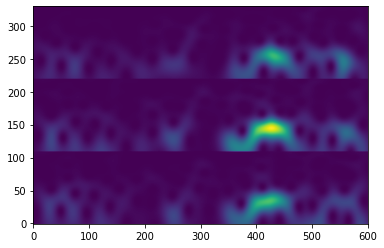

In [4]:
import sys
#participants = [1, 2, 3, 6, 7, 12, 14, 15, 18, 20, 21, 22, 29, 30, 31, 32, 33, 36, 37, 40]
n_ch = 3
participants =[7]
tmax = 4
tmin = -0.25
fs = 160.
trials=21
samples = int((tmax+tmin)*fs+1)
data = np.zeros((0,samples,n_ch))
labels = np.zeros(0)
lfreq, hfreq= 8, 30
freq_spec =  np.logspace(*np.log10([lfreq, hfreq]), num=110)
part_idx=0
n_cycles = freq_spec/2
im_chan=4
for part in participants:

    #load and filter data
    eeg_data = create_eeg_data(path, part = part, task = [0,1,0,1],baseline=True, filt=[lfreq,hfreq])
    epochs2 = eeg_data['t2'][0].all_sessions().copy()
    epochs4 = eeg_data['t4'][0].all_sessions().copy()




    count = 0

    sampl = np.random.randint(low=0, high=eeg_data["cl_eyes"][0].get_data().shape[1]-samples, size=(trials,), dtype='l')
    events_array = np.zeros([trials,samples,64])

    raw0 = eeg_data['cl_eyes'][0].copy()
    count = 0
    events=[]
    for i in range(trials):
        events_array[i,:,:]=raw0.get_data()[:,sampl[count]:sampl[count]+samples].T

        count = count+1
    labels0 = np.zeros([trials,])

    new_baseline_raw=mne.io.RawArray(events_array.reshape([64,trials*samples]),epochs2.info,verbose=False)
    onsets=np.arange(0,new_baseline_raw.get_data().shape[1]/fs,samples/fs)
    duration = np.ones([trials,])*(samples/fs)
    description = []
    for i in range(trials):
        description.append("T0")

    annot_base= mne.Annotations(onset=onsets,duration=duration,description=description)
    new_baseline_raw = new_baseline_raw.copy().set_annotations(annot_base)
    epochs0 = mne.EpochsArray(events_array.transpose([0,2,1]), epochs2.info, events=mne.events_from_annotations(new_baseline_raw,
                                    event_id={"T0":0})[0], tmin=0.25, event_id=None, reject=None, flat=None, reject_tmin=None,
                                    reject_tmax=None, baseline=None, proj=True, on_missing='raise', metadata=None, 
                                      selection=None, verbose=None)
    epochs0.info["highpass"]=lfreq
    epochs0.info["lowpass"]=hfreq


    epochs_train0 = epochs0.copy().crop(tmin=-tmin, tmax=tmax)
    ica = ICA(n_components=64, random_state=97)
    ica.fit(epochs_train0)
    ica.exclude = []
    # find which ICs match the EOG pattern
    eog_indices, eog_scores = ica.find_bads_eog(epochs_train0,ch_name='Fpz')
    ica.exclude = eog_indices
    #aply ICA
    ica.apply(epochs0)
    epochs_train0 = epochs0.copy().crop(tmin=-tmin, tmax=tmax).pick_channels(["C3","Cz","C4"])
    
    
    spec_data_train0 = np.zeros([len(participants),trials,n_ch*freq_spec.shape[0],samples])
    img_data_train0 = np.zeros([len(participants),trials,n_ch*freq_spec.shape[0],samples,im_chan]) 
    for i in range(trials):
        spec_data_train0[part_idx,i,:,:],img0=create_spectrogram(epochs_train0,i,frequencies=freq_spec,n_cycles=n_cycles,verbose=True)
        img_data_train0[part_idx,i,:,:,:]= img0.cmap(img0.norm(img0.get_array()))
    
    

    
    #crop
    epochs_train2 = epochs2.copy().crop(tmin=-tmin, tmax=tmax)
    
    #ICA epochs2
    ica = ICA(n_components=64, random_state=97)
    ica.fit(epochs_train2)
    ica.exclude = []
    # find which ICs match the EOG pattern
    eog_indices, eog_scores = ica.find_bads_eog(epochs_train2,ch_name='Fpz')
    ica.exclude = eog_indices
    #aply ICA
    ica.apply(epochs2)
    
    #ICA applied
    epochs_train2 = epochs2.copy().crop(tmin=-tmin, tmax=tmax).pick_channels(["C3","Cz","C4"])
    
    spec_data_train2 = np.zeros([len(participants),trials*2,n_ch*freq_spec.shape[0],samples]) 
    img_data_train2 = np.zeros([len(participants),trials*2,n_ch*freq_spec.shape[0],samples,im_chan]) 
    for i in range(trials*2):
            spec_data_train2[part_idx,i,:,:],img2=create_spectrogram(epochs_train2,i,frequencies=freq_spec,n_cycles=n_cycles,verbose=True)
            img_data_train2[part_idx,i,:,:,:]= img2.cmap(img2.norm(img2.get_array()))
    labels2 = epochs2.events[:, -1] - 1
    epochs_data_train2 = epochs_train2.get_data().transpose([0,2,1])
    
    
    
    #crop
    epochs_train4 = epochs4.copy().crop(tmin=-tmin, tmax=tmax)
    
    #ICA preprocessing
    ica = ICA(n_components=64, random_state=97)
    ica.fit(epochs_train4)
    ica.exclude = []
    # find which ICs match the EOG pattern
    eog_indices, eog_scores = ica.find_bads_eog(epochs_train4,ch_name='Fpz')
    ica.exclude = eog_indices
    #aply ICA
    ica.apply(epochs4)
    
    #ICA applied
    epochs_train4 = epochs4.copy().crop(tmin=-tmin, tmax=tmax).pick_channels(["C3","Cz","C4"])
    
    spec_data_train4 = np.zeros([len(participants),trials*2,n_ch*freq_spec.shape[0],samples])
    img_data_train4 = np.zeros([len(participants),trials*2,n_ch*freq_spec.shape[0],samples,im_chan])
    for i in range(trials*2):
            spec_data_train4[part_idx,i,:,:],img4=create_spectrogram(epochs_train4,i,frequencies=freq_spec,n_cycles=n_cycles,verbose=True)
            img_data_train4[part_idx,i,:,:,:]= img4.cmap(img4.norm(img4.get_array()))
            
    labels4 = epochs4.events[:, -1] +1
    epochs_data_train4 = epochs_train4.get_data().transpose([0,2,1])

    #concatenate to bigg file
    labels240 = np.concatenate((labels2, labels4,labels0))
    #data24 = np.concatenate((epochs_data_train2, epochs_data_train4, epochs_data_train0),axis=0)
    spec240 = np.concatenate((spec_data_train2,spec_data_train4,spec_data_train0),axis=1)
    img240 = np.concatenate((img_data_train2,img_data_train4,img_data_train0),axis=1)
    #data = np.concatenate((data, data24))
    part_idx = part_idx+1
    with open('data.pickle', 'wb') as f:
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
    with open('labels.pickle', 'wb') as f:
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(labels, f, pickle.HIGHEST_PROTOCOL)

In [5]:
#USE ONLY TASK 2 FOR NOW
#------------------

#img240 = img_data_train2.squeeze()[:,:,:,0:3]

In [6]:
"""
#IMAGE COMPRESSION AND NORMALIZATION

#for i in range(np.shape(img240)[0]):
#    for freq in range(np.shape(img240)[1]):
#            img240[i, freq] #-= np.mean(img240[i, freq])
#            img240[i, freq] /= np.var(img240[i, freq])
            #img240[i, freq] -= np.min(img240[i, freq])

img_comp = (np.zeros((np.shape(img240)[0],66,66, 3)))
for i in range(np.shape(img240)[0]):
    img_comp[i] =  cv2.resize(img240[i], dsize=(66, 66), interpolation=cv2.INTER_CUBIC)
#img_comp -= np.min(img_comp)
img_comp /=np.max(img_comp)
#img_comp = np.expand_dims(img_comp, axis = 3)
"""

'\n#IMAGE COMPRESSION AND NORMALIZATION\n\n#for i in range(np.shape(img240)[0]):\n#    for freq in range(np.shape(img240)[1]):\n#            img240[i, freq] #-= np.mean(img240[i, freq])\n#            img240[i, freq] /= np.var(img240[i, freq])\n            #img240[i, freq] -= np.min(img240[i, freq])\n\nimg_comp = (np.zeros((np.shape(img240)[0],66,66, 3)))\nfor i in range(np.shape(img240)[0]):\n    img_comp[i] =  cv2.resize(img240[i], dsize=(66, 66), interpolation=cv2.INTER_CUBIC)\n#img_comp -= np.min(img_comp)\nimg_comp /=np.max(img_comp)\n#img_comp = np.expand_dims(img_comp, axis = 3)\n'

In [7]:
img_old = img240
img240 = img240.squeeze()[:,:,:,:3]
img_comp = (np.zeros((np.shape(img240)[0],32,32, 3)))
for i in range(np.shape(img240)[0]):
    img_comp[i] =  cv2.resize(img240[i], dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
img_comp -= np.min(img_comp)
img_comp /=np.max(img_comp)
img240 = img_comp
#img_comp = np.expand_dims(img_comp, axis = 3)

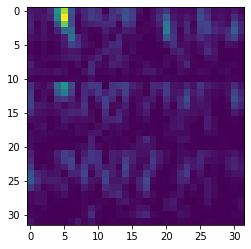

In [8]:
plt.imshow(img240[3])

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=1)


In [10]:
for train_index, test_index in sss.split(img240.squeeze(), labels240):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = img240.squeeze()[train_index,:,:,:3], img240.squeeze()[test_index,:,:,:3]
    y_train, y_test = labels240[train_index], labels240[test_index]

TRAIN: [ 34   2   6  14  87  16  77  90  32  86  88  35  98  48  52  37  78  80
  71  40  66  39  44  94   5  24  10  83  49  27  56   3  72  51  75   4
  65  68  41  69  53  18  45  97  91  63  64  26  59  30  67  20  25 104
  96   1  23  74  57  92  70  76   8  22  29  38  11 103  33 101  60  55
 102] TEST: [ 31  61  17  28  73   9  47  42  46  99  85  50  21   7 100  43  62   0
  58  89  95  12  84  19  15  79  81  93  36  54  82  13]


In [11]:
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=1)

In [12]:
for val_index, test_index in sss1.split(X_test, y_test):
    print("Val:", val_index, "TEST:", test_index)
    X_val, X_test = X_test[val_index,:,:,:3], X_test[test_index,:,:,:3]
    y_val, y_test = y_test[val_index], y_test[test_index]

Val: [27 10 21  0 17 18  4 14  8 15 30  2  5 22 29 13] TEST: [19 26  3  9 11 25 20 28 12 16 24 31  1  7 23  6]


In [13]:
X_test.shape

(16, 32, 32, 3)

In [14]:
#ONE HOT ENCODING
from keras.utils import to_categorical
y_train_OH = to_categorical(y_train)
y_test_OH = to_categorical(y_test)
y_val_OH = to_categorical(y_val)


Using TensorFlow backend.


In [15]:
#X_train, X_test, y_train, y_test = train_test_split(img240.squeeze()[:,:,:,0:3], labels240, test_size=0.20)

In [16]:
#np.savez("db/x_norm", X_train[:10], allow_pickle=True)
#np.savez_compressed(os.path.join(path_wd, 'x_norm'), x_train[::10])

In [17]:
np.shape(X_train[::40])

(2, 32, 32, 3)

In [18]:
y_val_OH[0]

array([1., 0., 0., 0., 0.], dtype=float32)

In [19]:
y_train_OH[3]

array([0., 1., 0., 0., 0.], dtype=float32)

In [20]:
X_grey = np.zeros((len(X_train),32,32))
for i in range(len(X_train)):
    X_grey[i]=cv2.cvtColor(np.float32(X_train[i]), cv2.COLOR_BGR2GRAY)
X_train = X_grey


In [21]:
X_grey = np.zeros((len(X_test),32,32))
for i in range(len(X_test)):
    X_grey[i]=cv2.cvtColor(np.float32(X_test[i]), cv2.COLOR_BGR2GRAY)
X_test= X_grey

In [22]:
X_grey = np.zeros((len(X_val),32,32))
for i in range(len(X_val)):
    X_grey[i]=cv2.cvtColor(np.float32(X_val[i]), cv2.COLOR_BGR2GRAY)
X_val= X_grey

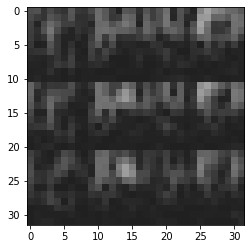

In [23]:
plt.imshow(X_val[0], cmap='gray', vmin=0, vmax=1)

In [24]:
X_test = np.expand_dims(X_test, axis = 3)
X_train = np.expand_dims(X_train, axis = 3)
X_val = np.expand_dims(X_val, axis = 3)

In [25]:

np.savez_compressed("x_train", X_train)
np.savez_compressed("x_test", X_test)
np.savez_compressed("x_val",X_val)
np.savez_compressed("x_norm", X_train[::20])
np.savez_compressed("y_train", y_train_OH)
np.savez_compressed("y_test", y_test_OH)
np.savez_compressed("y_val", y_val_OH)

In [26]:
X_val.shape

(16, 32, 32, 1)

In [28]:
#from keras.models import Sequential, InputLayer
#from keras.layers import Dense, Activation, Flatten
#from keras.layers import BatchNormalization, Dropout, Conv2D, MaxPooling2D
#from tensorflow import keras

#from tensorflow.keras import Sequential, Input
#from tensorflow.keras.layers import Conv2D, Flatten, Dense, Activation, BatchNormalization, Dropout, Conv2D, MaxPooling2D, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, \
    Dropout




In [ ]:
#del model

In [ ]:
import tensorflow as tf
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["val_accuracy"]
        if accuracy >= self.threshold:
            self.model.stop_training = True

In [ ]:
np.arange(1e-4,1e-2,2e-4)

In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
scores=[]
#for i in [16,24,32,40,48,56,64]:
for i in [16,24,32,40,48,56,64]:
    batch_size=i
    no_epochs= 500
    for j in np.arange(1e-4,1e-2,2e-4):
        
        input_shape = X_test[0].shape
        input_layer = Input(input_shape)

        layer = Conv2D(filters=16,
                       kernel_size=(5, 5),
                       strides=(2, 2),
                       activation='relu',
                       use_bias=False)(input_layer)

        layer = Conv2D(filters=32,
                       kernel_size=(3, 3),
                       activation='relu',
                       use_bias=False)(layer)
        #layer = AveragePooling2D()(layer)
        layer = Conv2D(filters=8,
                       kernel_size=(3, 3),
                       padding='same',
                       activation='relu',
                       use_bias=False)(layer)

        layer = Flatten()(layer)
        layer = Dropout(0.01)(layer)
        layer = Dense(units=5,
                      activation='softmax')(layer)
        
        model = Model(input_layer, layer)

        # compile the model
        opt = Adam(learning_rate = j)
        model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    # Fit data to model
        history = model.fit(X_train,  y_train_OH,
                  batch_size=batch_size,
                  epochs=no_epochs,
                  verbose=True,
                validation_data=(X_val, y_val_OH), callbacks=[EarlyStopping(monitor='val_loss', verbose=1, patience=20),ModelCheckpoint('D:/TUMbackup/NiseModels/bm'+str(i)+'-'+str(j)+'.h5', monitor='val_loss', save_best_only=True)])

        #callbacks=[MyThresholdCallback(threshold=0.6)]

        scores.append([i,j,model.evaluate(X_test, y_test_OH, verbose=1)])
        del model
        del layer
        del input_layer



Epoch 1/500
5/5 [==============================] - 0s 88ms/step - loss: 1.6113 - accuracy: 0.1918 - val_loss: 1.6087 - val_accuracy: 0.1875
Epoch 2/500
5/5 [==============================] - 0s 11ms/step - loss: 1.6109 - accuracy: 0.1781 - val_loss: 1.6086 - val_accuracy: 0.2500
Epoch 3/500
5/5 [==============================] - 0s 11ms/step - loss: 1.6096 - accuracy: 0.1644 - val_loss: 1.6085 - val_accuracy: 0.2500
Epoch 4/500
5/5 [==============================] - 0s 11ms/step - loss: 1.6094 - accuracy: 0.2192 - val_loss: 1.6084 - val_accuracy: 0.1875
Epoch 5/500
5/5 [==============================] - 0s 11ms/step - loss: 1.6079 - accuracy: 0.2192 - val_loss: 1.6082 - val_accuracy: 0.1875
Epoch 6/500
5/5 [==============================] - 0s 11ms/step - loss: 1.6073 - accuracy: 0.2466 - val_loss: 1.6079 - val_accuracy: 0.1875
Epoch 7/500
5/5 [==============================] - 0s 11ms/step - loss: 1.6067 - accuracy: 0.2192 - val_loss: 1.6077 - val_accuracy: 0.1875
Epoch 8/500
5/5 [===

5/5 [==============================] - 0s 11ms/step - loss: 1.4855 - accuracy: 0.6164 - val_loss: 1.5455 - val_accuracy: 0.4375
Epoch 60/500
5/5 [==============================] - 0s 10ms/step - loss: 1.4843 - accuracy: 0.6164 - val_loss: 1.5410 - val_accuracy: 0.3750
Epoch 61/500
5/5 [==============================] - 0s 10ms/step - loss: 1.4747 - accuracy: 0.6164 - val_loss: 1.5387 - val_accuracy: 0.3750
Epoch 62/500
5/5 [==============================] - 0s 11ms/step - loss: 1.4663 - accuracy: 0.6575 - val_loss: 1.5337 - val_accuracy: 0.3750
Epoch 63/500
5/5 [==============================] - 0s 10ms/step - loss: 1.4585 - accuracy: 0.5753 - val_loss: 1.5283 - val_accuracy: 0.4375
Epoch 64/500
5/5 [==============================] - 0s 12ms/step - loss: 1.4595 - accuracy: 0.6438 - val_loss: 1.5212 - val_accuracy: 0.4375
Epoch 65/500
5/5 [==============================] - 0s 12ms/step - loss: 1.4463 - accuracy: 0.6575 - val_loss: 1.5156 - val_accuracy: 0.4375
Epoch 66/500
5/5 [========

5/5 [==============================] - 0s 12ms/step - loss: 0.8961 - accuracy: 0.7123 - val_loss: 1.1353 - val_accuracy: 0.5625
Epoch 118/500
5/5 [==============================] - 0s 16ms/step - loss: 0.8547 - accuracy: 0.7397 - val_loss: 1.1166 - val_accuracy: 0.5000
Epoch 119/500
5/5 [==============================] - 0s 15ms/step - loss: 0.8707 - accuracy: 0.7260 - val_loss: 1.1153 - val_accuracy: 0.5000
Epoch 120/500
5/5 [==============================] - 0s 13ms/step - loss: 0.8657 - accuracy: 0.7671 - val_loss: 1.1121 - val_accuracy: 0.5000
Epoch 121/500
5/5 [==============================] - 0s 13ms/step - loss: 0.8506 - accuracy: 0.7671 - val_loss: 1.1096 - val_accuracy: 0.5625
Epoch 122/500
5/5 [==============================] - 0s 10ms/step - loss: 0.8490 - accuracy: 0.7123 - val_loss: 1.1170 - val_accuracy: 0.5625
Epoch 123/500
5/5 [==============================] - 0s 11ms/step - loss: 0.8378 - accuracy: 0.6849 - val_loss: 1.1203 - val_accuracy: 0.5000
Epoch 124/500
5/5 [=

Epoch 175/500
5/5 [==============================] - 0s 9ms/step - loss: 0.5880 - accuracy: 0.7945 - val_loss: 1.0333 - val_accuracy: 0.5625
Epoch 176/500
5/5 [==============================] - 0s 9ms/step - loss: 0.6147 - accuracy: 0.7808 - val_loss: 1.0132 - val_accuracy: 0.6250
Epoch 177/500
5/5 [==============================] - 0s 13ms/step - loss: 0.5957 - accuracy: 0.8219 - val_loss: 0.9897 - val_accuracy: 0.5000
Epoch 178/500
5/5 [==============================] - 0s 9ms/step - loss: 0.5849 - accuracy: 0.8082 - val_loss: 1.0088 - val_accuracy: 0.6875
Epoch 179/500
5/5 [==============================] - 0s 9ms/step - loss: 0.5897 - accuracy: 0.8082 - val_loss: 1.0324 - val_accuracy: 0.5625
Epoch 180/500
5/5 [==============================] - 0s 9ms/step - loss: 0.6270 - accuracy: 0.7534 - val_loss: 1.0513 - val_accuracy: 0.5625
Epoch 181/500
5/5 [==============================] - 0s 10ms/step - loss: 0.6175 - accuracy: 0.7397 - val_loss: 1.0060 - val_accuracy: 0.5625
Epoch 182/5

5/5 [==============================] - 0s 11ms/step - loss: 1.2176 - accuracy: 0.7397 - val_loss: 1.3515 - val_accuracy: 0.5625
Epoch 36/500
5/5 [==============================] - 0s 12ms/step - loss: 1.1826 - accuracy: 0.7397 - val_loss: 1.3244 - val_accuracy: 0.5000
Epoch 37/500
5/5 [==============================] - 0s 11ms/step - loss: 1.1712 - accuracy: 0.6986 - val_loss: 1.2932 - val_accuracy: 0.4375
Epoch 38/500
5/5 [==============================] - 0s 12ms/step - loss: 1.1267 - accuracy: 0.7397 - val_loss: 1.2830 - val_accuracy: 0.5000
Epoch 39/500
5/5 [==============================] - 0s 11ms/step - loss: 1.0784 - accuracy: 0.7123 - val_loss: 1.2602 - val_accuracy: 0.4375
Epoch 40/500
5/5 [==============================] - 0s 11ms/step - loss: 1.0292 - accuracy: 0.7260 - val_loss: 1.2295 - val_accuracy: 0.3750
Epoch 41/500
5/5 [==============================] - 0s 11ms/step - loss: 1.0067 - accuracy: 0.7123 - val_loss: 1.1966 - val_accuracy: 0.5000
Epoch 42/500
5/5 [========

1/1 [==============================] - 0s 1ms/step - loss: 2.5333 - accuracy: 0.2500
Epoch 1/500
5/5 [==============================] - 0s 42ms/step - loss: 1.6096 - accuracy: 0.2466 - val_loss: 1.6082 - val_accuracy: 0.1250
Epoch 2/500
5/5 [==============================] - 0s 12ms/step - loss: 1.6070 - accuracy: 0.4110 - val_loss: 1.6078 - val_accuracy: 0.2500
Epoch 3/500
5/5 [==============================] - 0s 11ms/step - loss: 1.6050 - accuracy: 0.4384 - val_loss: 1.6075 - val_accuracy: 0.2500
Epoch 4/500
5/5 [==============================] - 0s 11ms/step - loss: 1.6031 - accuracy: 0.5205 - val_loss: 1.6074 - val_accuracy: 0.2500
Epoch 5/500
5/5 [==============================] - 0s 12ms/step - loss: 1.5994 - accuracy: 0.5616 - val_loss: 1.6074 - val_accuracy: 0.1875
Epoch 6/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5954 - accuracy: 0.5616 - val_loss: 1.6074 - val_accuracy: 0.1875
Epoch 7/500
5/5 [==============================] - 0s 14ms/step - loss: 1.58

Epoch 59/500
5/5 [==============================] - 0s 10ms/step - loss: 0.3284 - accuracy: 0.8904 - val_loss: 1.2420 - val_accuracy: 0.5000
Epoch 60/500
5/5 [==============================] - 0s 10ms/step - loss: 0.3262 - accuracy: 0.8904 - val_loss: 1.3389 - val_accuracy: 0.5000
Epoch 00060: early stopping
1/1 [==============================] - 0s 998us/step - loss: 3.1096 - accuracy: 0.1875
Epoch 1/500
5/5 [==============================] - 0s 38ms/step - loss: 1.6105 - accuracy: 0.2055 - val_loss: 1.6120 - val_accuracy: 0.3125
Epoch 2/500
5/5 [==============================] - 0s 11ms/step - loss: 1.6038 - accuracy: 0.3973 - val_loss: 1.6104 - val_accuracy: 0.3750
Epoch 3/500
5/5 [==============================] - 0s 13ms/step - loss: 1.5989 - accuracy: 0.4521 - val_loss: 1.6090 - val_accuracy: 0.2500
Epoch 4/500
5/5 [==============================] - 0s 13ms/step - loss: 1.5943 - accuracy: 0.4658 - val_loss: 1.6067 - val_accuracy: 0.3125
Epoch 5/500
5/5 [==========================

Epoch 12/500
5/5 [==============================] - 0s 11ms/step - loss: 1.2871 - accuracy: 0.7534 - val_loss: 1.4228 - val_accuracy: 0.3125
Epoch 13/500
5/5 [==============================] - 0s 11ms/step - loss: 1.2080 - accuracy: 0.6575 - val_loss: 1.3594 - val_accuracy: 0.5625
Epoch 14/500
5/5 [==============================] - 0s 11ms/step - loss: 1.0984 - accuracy: 0.6986 - val_loss: 1.3004 - val_accuracy: 0.4375
Epoch 15/500
5/5 [==============================] - 0s 11ms/step - loss: 1.0596 - accuracy: 0.6712 - val_loss: 1.2710 - val_accuracy: 0.5000
Epoch 16/500
5/5 [==============================] - 0s 12ms/step - loss: 1.0550 - accuracy: 0.6849 - val_loss: 1.2298 - val_accuracy: 0.3750
Epoch 17/500
5/5 [==============================] - 0s 9ms/step - loss: 0.8889 - accuracy: 0.7260 - val_loss: 1.4053 - val_accuracy: 0.5000
Epoch 18/500
5/5 [==============================] - 0s 14ms/step - loss: 0.8971 - accuracy: 0.6712 - val_loss: 1.1634 - val_accuracy: 0.5625
Epoch 19/500
5

5/5 [==============================] - 0s 8ms/step - loss: 0.2454 - accuracy: 0.9178 - val_loss: 1.4137 - val_accuracy: 0.5000
Epoch 32/500
5/5 [==============================] - 0s 8ms/step - loss: 0.1976 - accuracy: 0.9315 - val_loss: 1.4816 - val_accuracy: 0.3750
Epoch 33/500
5/5 [==============================] - 0s 8ms/step - loss: 0.2117 - accuracy: 0.9589 - val_loss: 1.4896 - val_accuracy: 0.4375
Epoch 34/500
5/5 [==============================] - 0s 8ms/step - loss: 0.1943 - accuracy: 0.9726 - val_loss: 1.5834 - val_accuracy: 0.3750
Epoch 35/500
5/5 [==============================] - 0s 8ms/step - loss: 0.1814 - accuracy: 0.9863 - val_loss: 1.4608 - val_accuracy: 0.4375
Epoch 36/500
5/5 [==============================] - 0s 8ms/step - loss: 0.1784 - accuracy: 0.9589 - val_loss: 1.6292 - val_accuracy: 0.5000
Epoch 37/500
5/5 [==============================] - 0s 8ms/step - loss: 0.1819 - accuracy: 0.9726 - val_loss: 1.6526 - val_accuracy: 0.2500
Epoch 00037: early stopping
1/1 [

Epoch 11/500
5/5 [==============================] - 0s 11ms/step - loss: 0.8636 - accuracy: 0.7397 - val_loss: 1.2845 - val_accuracy: 0.3750
Epoch 12/500
5/5 [==============================] - 0s 12ms/step - loss: 0.8252 - accuracy: 0.7260 - val_loss: 1.2324 - val_accuracy: 0.3750
Epoch 13/500
5/5 [==============================] - 0s 8ms/step - loss: 0.7548 - accuracy: 0.6849 - val_loss: 1.3212 - val_accuracy: 0.3750
Epoch 14/500
5/5 [==============================] - 0s 8ms/step - loss: 0.7950 - accuracy: 0.7397 - val_loss: 1.2407 - val_accuracy: 0.5000
Epoch 15/500
5/5 [==============================] - 0s 8ms/step - loss: 0.6520 - accuracy: 0.7671 - val_loss: 1.4815 - val_accuracy: 0.4375
Epoch 16/500
5/5 [==============================] - 0s 9ms/step - loss: 0.5669 - accuracy: 0.7945 - val_loss: 1.3744 - val_accuracy: 0.3125
Epoch 17/500
5/5 [==============================] - 0s 8ms/step - loss: 0.5026 - accuracy: 0.8767 - val_loss: 1.3990 - val_accuracy: 0.3125
Epoch 18/500
5/5 [

Epoch 2/500
5/5 [==============================] - 0s 8ms/step - loss: 1.6069 - accuracy: 0.2192 - val_loss: 1.6080 - val_accuracy: 0.3125
Epoch 3/500
5/5 [==============================] - 0s 8ms/step - loss: 1.6031 - accuracy: 0.2466 - val_loss: 1.6071 - val_accuracy: 0.1875
Epoch 4/500
5/5 [==============================] - 0s 11ms/step - loss: 1.5922 - accuracy: 0.3973 - val_loss: 1.5993 - val_accuracy: 0.2500
Epoch 5/500
5/5 [==============================] - 0s 11ms/step - loss: 1.5772 - accuracy: 0.4658 - val_loss: 1.5844 - val_accuracy: 0.3125
Epoch 6/500
5/5 [==============================] - 0s 11ms/step - loss: 1.5453 - accuracy: 0.4247 - val_loss: 1.5770 - val_accuracy: 0.2500
Epoch 7/500
5/5 [==============================] - 0s 11ms/step - loss: 1.5041 - accuracy: 0.3562 - val_loss: 1.5380 - val_accuracy: 0.3750
Epoch 8/500
5/5 [==============================] - 0s 11ms/step - loss: 1.4521 - accuracy: 0.4384 - val_loss: 1.4867 - val_accuracy: 0.3125
Epoch 9/500
5/5 [=====

5/5 [==============================] - 0s 11ms/step - loss: 0.3051 - accuracy: 0.9041 - val_loss: 1.8280 - val_accuracy: 0.4375
Epoch 21/500
5/5 [==============================] - 0s 11ms/step - loss: 0.2733 - accuracy: 0.8904 - val_loss: 1.8943 - val_accuracy: 0.3125
Epoch 22/500
5/5 [==============================] - 0s 11ms/step - loss: 0.2022 - accuracy: 0.9589 - val_loss: 1.8715 - val_accuracy: 0.3125
Epoch 23/500
5/5 [==============================] - 0s 10ms/step - loss: 0.1575 - accuracy: 0.9726 - val_loss: 2.0090 - val_accuracy: 0.4375
Epoch 24/500
5/5 [==============================] - 0s 10ms/step - loss: 0.1328 - accuracy: 0.9726 - val_loss: 2.1295 - val_accuracy: 0.3750
Epoch 25/500
5/5 [==============================] - 0s 11ms/step - loss: 0.1403 - accuracy: 0.9452 - val_loss: 2.1856 - val_accuracy: 0.3125
Epoch 26/500
5/5 [==============================] - 0s 10ms/step - loss: 0.1550 - accuracy: 0.9589 - val_loss: 2.2795 - val_accuracy: 0.3750
Epoch 27/500
5/5 [========

Epoch 10/500
5/5 [==============================] - 0s 12ms/step - loss: 0.9848 - accuracy: 0.6849 - val_loss: 1.2961 - val_accuracy: 0.5000
Epoch 11/500
5/5 [==============================] - 0s 8ms/step - loss: 0.9560 - accuracy: 0.6301 - val_loss: 1.3548 - val_accuracy: 0.3750
Epoch 12/500
5/5 [==============================] - 0s 8ms/step - loss: 0.9036 - accuracy: 0.6712 - val_loss: 1.3843 - val_accuracy: 0.5000
Epoch 13/500
5/5 [==============================] - 0s 9ms/step - loss: 0.7709 - accuracy: 0.7123 - val_loss: 1.3441 - val_accuracy: 0.4375
Epoch 14/500
5/5 [==============================] - 0s 9ms/step - loss: 0.7639 - accuracy: 0.7397 - val_loss: 1.3511 - val_accuracy: 0.4375
Epoch 15/500
5/5 [==============================] - 0s 8ms/step - loss: 0.7590 - accuracy: 0.7534 - val_loss: 1.3986 - val_accuracy: 0.3125
Epoch 16/500
5/5 [==============================] - 0s 12ms/step - loss: 0.6342 - accuracy: 0.7397 - val_loss: 1.2848 - val_accuracy: 0.5625
Epoch 17/500
5/5 [

5/5 [==============================] - 0s 8ms/step - loss: 0.0168 - accuracy: 1.0000 - val_loss: 2.3934 - val_accuracy: 0.4375
Epoch 32/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 2.4690 - val_accuracy: 0.4375
Epoch 33/500
5/5 [==============================] - 0s 9ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 2.5116 - val_accuracy: 0.4375
Epoch 34/500
5/5 [==============================] - 0s 8ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 2.5158 - val_accuracy: 0.4375
Epoch 35/500
5/5 [==============================] - 0s 8ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 2.5312 - val_accuracy: 0.4375
Epoch 36/500
5/5 [==============================] - 0s 9ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 2.6016 - val_accuracy: 0.4375
Epoch 00036: early stopping
1/1 [==============================] - 0s 1ms/step - loss: 4.3953 - accuracy: 0.1250
Epoch 1/500
5/5 [==============================] - 0s 38ms/

Epoch 18/500
5/5 [==============================] - 0s 9ms/step - loss: 0.2639 - accuracy: 0.9178 - val_loss: 1.9877 - val_accuracy: 0.3125
Epoch 19/500
5/5 [==============================] - 0s 10ms/step - loss: 0.2158 - accuracy: 0.9452 - val_loss: 2.1571 - val_accuracy: 0.3125
Epoch 20/500
5/5 [==============================] - 0s 10ms/step - loss: 0.1277 - accuracy: 0.9863 - val_loss: 2.2225 - val_accuracy: 0.3750
Epoch 21/500
5/5 [==============================] - 0s 10ms/step - loss: 0.1404 - accuracy: 0.9315 - val_loss: 2.6269 - val_accuracy: 0.2500
Epoch 22/500
5/5 [==============================] - 0s 11ms/step - loss: 0.1331 - accuracy: 0.9452 - val_loss: 2.5683 - val_accuracy: 0.2500
Epoch 23/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0922 - accuracy: 0.9863 - val_loss: 2.6642 - val_accuracy: 0.3125
Epoch 24/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0815 - accuracy: 0.9863 - val_loss: 2.7215 - val_accuracy: 0.3750
Epoch 25/500
5

Epoch 15/500
5/5 [==============================] - 0s 9ms/step - loss: 0.5280 - accuracy: 0.7260 - val_loss: 1.6908 - val_accuracy: 0.3125
Epoch 16/500
5/5 [==============================] - 0s 9ms/step - loss: 0.4477 - accuracy: 0.8082 - val_loss: 1.7265 - val_accuracy: 0.3125
Epoch 17/500
5/5 [==============================] - 0s 9ms/step - loss: 0.2743 - accuracy: 0.9041 - val_loss: 1.7427 - val_accuracy: 0.3125
Epoch 18/500
5/5 [==============================] - 0s 8ms/step - loss: 0.2134 - accuracy: 0.9726 - val_loss: 2.0744 - val_accuracy: 0.3125
Epoch 19/500
5/5 [==============================] - 0s 9ms/step - loss: 0.1432 - accuracy: 1.0000 - val_loss: 1.9803 - val_accuracy: 0.3750
Epoch 20/500
5/5 [==============================] - 0s 10ms/step - loss: 0.1206 - accuracy: 0.9726 - val_loss: 2.6089 - val_accuracy: 0.3750
Epoch 21/500
5/5 [==============================] - 0s 10ms/step - loss: 0.1316 - accuracy: 0.9589 - val_loss: 2.2280 - val_accuracy: 0.2500
Epoch 22/500
5/5 [

Epoch 10/500
5/5 [==============================] - 0s 11ms/step - loss: 1.1884 - accuracy: 0.5342 - val_loss: 1.3751 - val_accuracy: 0.4375
Epoch 11/500
5/5 [==============================] - 0s 9ms/step - loss: 0.9488 - accuracy: 0.6027 - val_loss: 1.4535 - val_accuracy: 0.3750
Epoch 12/500
5/5 [==============================] - 0s 8ms/step - loss: 1.0809 - accuracy: 0.6301 - val_loss: 1.3964 - val_accuracy: 0.3750
Epoch 13/500
5/5 [==============================] - 0s 12ms/step - loss: 0.8783 - accuracy: 0.6849 - val_loss: 1.3731 - val_accuracy: 0.3750
Epoch 14/500
5/5 [==============================] - 0s 12ms/step - loss: 0.8057 - accuracy: 0.6986 - val_loss: 1.3125 - val_accuracy: 0.5000
Epoch 15/500
5/5 [==============================] - 0s 9ms/step - loss: 0.7330 - accuracy: 0.7534 - val_loss: 1.5629 - val_accuracy: 0.3750
Epoch 16/500
5/5 [==============================] - 0s 8ms/step - loss: 0.6966 - accuracy: 0.6986 - val_loss: 1.4750 - val_accuracy: 0.4375
Epoch 17/500
5/5 

Epoch 3/500
5/5 [==============================] - 0s 11ms/step - loss: 1.6050 - accuracy: 0.2877 - val_loss: 1.5987 - val_accuracy: 0.1875
Epoch 4/500
5/5 [==============================] - 0s 12ms/step - loss: 1.5962 - accuracy: 0.2192 - val_loss: 1.5873 - val_accuracy: 0.1875
Epoch 5/500
5/5 [==============================] - 0s 11ms/step - loss: 1.6207 - accuracy: 0.2603 - val_loss: 1.5809 - val_accuracy: 0.3750
Epoch 6/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5829 - accuracy: 0.4658 - val_loss: 1.5905 - val_accuracy: 0.3125
Epoch 7/500
5/5 [==============================] - 0s 12ms/step - loss: 1.5629 - accuracy: 0.3836 - val_loss: 1.5626 - val_accuracy: 0.3125
Epoch 8/500
5/5 [==============================] - 0s 12ms/step - loss: 1.5083 - accuracy: 0.4247 - val_loss: 1.4868 - val_accuracy: 0.3750
Epoch 9/500
5/5 [==============================] - 0s 12ms/step - loss: 1.3603 - accuracy: 0.5068 - val_loss: 1.3736 - val_accuracy: 0.4375
Epoch 10/500
5/5 [===

5/5 [==============================] - 0s 10ms/step - loss: 0.1385 - accuracy: 0.9726 - val_loss: 2.2869 - val_accuracy: 0.0625
Epoch 29/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0943 - accuracy: 0.9726 - val_loss: 2.5610 - val_accuracy: 0.1250
Epoch 30/500
5/5 [==============================] - 0s 9ms/step - loss: 0.1025 - accuracy: 0.9863 - val_loss: 2.4382 - val_accuracy: 0.1875
Epoch 31/500
5/5 [==============================] - 0s 8ms/step - loss: 0.1359 - accuracy: 0.9589 - val_loss: 3.1358 - val_accuracy: 0.1875
Epoch 32/500
5/5 [==============================] - 0s 9ms/step - loss: 0.1299 - accuracy: 0.9452 - val_loss: 2.5460 - val_accuracy: 0.0625
Epoch 33/500
5/5 [==============================] - 0s 8ms/step - loss: 0.1393 - accuracy: 0.9589 - val_loss: 2.5475 - val_accuracy: 0.1250
Epoch 34/500
5/5 [==============================] - 0s 9ms/step - loss: 0.0879 - accuracy: 0.9726 - val_loss: 3.5739 - val_accuracy: 0.2500
Epoch 35/500
5/5 [=============

Epoch 18/500
5/5 [==============================] - 0s 9ms/step - loss: 0.7632 - accuracy: 0.6712 - val_loss: 1.7106 - val_accuracy: 0.3750
Epoch 19/500
5/5 [==============================] - 0s 11ms/step - loss: 0.7138 - accuracy: 0.6986 - val_loss: 1.8284 - val_accuracy: 0.4375
Epoch 20/500
5/5 [==============================] - 0s 11ms/step - loss: 0.7302 - accuracy: 0.7671 - val_loss: 1.8448 - val_accuracy: 0.3750
Epoch 21/500
5/5 [==============================] - 0s 11ms/step - loss: 0.5987 - accuracy: 0.8082 - val_loss: 2.3609 - val_accuracy: 0.1250
Epoch 22/500
5/5 [==============================] - 0s 10ms/step - loss: 0.5632 - accuracy: 0.8082 - val_loss: 2.4204 - val_accuracy: 0.1250
Epoch 23/500
5/5 [==============================] - 0s 10ms/step - loss: 0.4341 - accuracy: 0.8630 - val_loss: 2.5135 - val_accuracy: 0.2500
Epoch 24/500
5/5 [==============================] - 0s 10ms/step - loss: 0.4215 - accuracy: 0.8493 - val_loss: 3.2264 - val_accuracy: 0.1250
Epoch 25/500
5

Epoch 12/500
5/5 [==============================] - 0s 9ms/step - loss: 0.8691 - accuracy: 0.6712 - val_loss: 1.4872 - val_accuracy: 0.5000
Epoch 13/500
5/5 [==============================] - 0s 9ms/step - loss: 0.8390 - accuracy: 0.6986 - val_loss: 1.6689 - val_accuracy: 0.4375
Epoch 14/500
5/5 [==============================] - 0s 8ms/step - loss: 0.7513 - accuracy: 0.7123 - val_loss: 1.5997 - val_accuracy: 0.5000
Epoch 15/500
5/5 [==============================] - 0s 9ms/step - loss: 0.8311 - accuracy: 0.6712 - val_loss: 1.8958 - val_accuracy: 0.4375
Epoch 16/500
5/5 [==============================] - 0s 9ms/step - loss: 0.7959 - accuracy: 0.7397 - val_loss: 1.7539 - val_accuracy: 0.4375
Epoch 17/500
5/5 [==============================] - 0s 9ms/step - loss: 0.6082 - accuracy: 0.7534 - val_loss: 1.7452 - val_accuracy: 0.4375
Epoch 18/500
5/5 [==============================] - 0s 9ms/step - loss: 0.5291 - accuracy: 0.8219 - val_loss: 1.9191 - val_accuracy: 0.5000
Epoch 19/500
5/5 [==

Epoch 10/500
5/5 [==============================] - 0s 9ms/step - loss: 0.8699 - accuracy: 0.6712 - val_loss: 1.3522 - val_accuracy: 0.3750
Epoch 11/500
5/5 [==============================] - 0s 9ms/step - loss: 0.8123 - accuracy: 0.7123 - val_loss: 1.4595 - val_accuracy: 0.3125
Epoch 12/500
5/5 [==============================] - 0s 9ms/step - loss: 0.7290 - accuracy: 0.7808 - val_loss: 1.4039 - val_accuracy: 0.3125
Epoch 13/500
5/5 [==============================] - 0s 9ms/step - loss: 0.6568 - accuracy: 0.7808 - val_loss: 1.6051 - val_accuracy: 0.3750
Epoch 14/500
5/5 [==============================] - 0s 9ms/step - loss: 0.6374 - accuracy: 0.7808 - val_loss: 1.7211 - val_accuracy: 0.3125
Epoch 15/500
5/5 [==============================] - 0s 9ms/step - loss: 0.6718 - accuracy: 0.7397 - val_loss: 1.5176 - val_accuracy: 0.3750
Epoch 16/500
5/5 [==============================] - 0s 9ms/step - loss: 0.6617 - accuracy: 0.7123 - val_loss: 1.5988 - val_accuracy: 0.2500
Epoch 17/500
5/5 [==

Epoch 12/500
5/5 [==============================] - 0s 9ms/step - loss: 0.7190 - accuracy: 0.7534 - val_loss: 2.0631 - val_accuracy: 0.3750
Epoch 13/500
5/5 [==============================] - 0s 9ms/step - loss: 0.6285 - accuracy: 0.6712 - val_loss: 1.9557 - val_accuracy: 0.4375
Epoch 14/500
5/5 [==============================] - 0s 8ms/step - loss: 0.5607 - accuracy: 0.7808 - val_loss: 2.1142 - val_accuracy: 0.4375
Epoch 15/500
5/5 [==============================] - 0s 8ms/step - loss: 0.4380 - accuracy: 0.8630 - val_loss: 2.4841 - val_accuracy: 0.3125
Epoch 16/500
5/5 [==============================] - 0s 9ms/step - loss: 0.4010 - accuracy: 0.8904 - val_loss: 2.0158 - val_accuracy: 0.3750
Epoch 17/500
5/5 [==============================] - 0s 9ms/step - loss: 0.2823 - accuracy: 0.8767 - val_loss: 2.5502 - val_accuracy: 0.3125
Epoch 18/500
5/5 [==============================] - 0s 9ms/step - loss: 0.2434 - accuracy: 0.8904 - val_loss: 2.6107 - val_accuracy: 0.3750
Epoch 19/500
5/5 [==

Epoch 9/500
5/5 [==============================] - 0s 11ms/step - loss: 1.0790 - accuracy: 0.6027 - val_loss: 1.3059 - val_accuracy: 0.3750
Epoch 10/500
5/5 [==============================] - 0s 9ms/step - loss: 0.7678 - accuracy: 0.7260 - val_loss: 1.5661 - val_accuracy: 0.4375
Epoch 11/500
5/5 [==============================] - 0s 9ms/step - loss: 0.6756 - accuracy: 0.7260 - val_loss: 1.6735 - val_accuracy: 0.3750
Epoch 12/500
5/5 [==============================] - 0s 9ms/step - loss: 0.6158 - accuracy: 0.7534 - val_loss: 1.3419 - val_accuracy: 0.5625
Epoch 13/500
5/5 [==============================] - 0s 9ms/step - loss: 0.5167 - accuracy: 0.7808 - val_loss: 1.6474 - val_accuracy: 0.3750
Epoch 14/500
5/5 [==============================] - 0s 9ms/step - loss: 0.3333 - accuracy: 0.8630 - val_loss: 1.6672 - val_accuracy: 0.4375
Epoch 15/500
5/5 [==============================] - 0s 9ms/step - loss: 0.4016 - accuracy: 0.8082 - val_loss: 2.3321 - val_accuracy: 0.4375
Epoch 16/500
5/5 [==

Epoch 7/500
5/5 [==============================] - 0s 11ms/step - loss: 1.5086 - accuracy: 0.4110 - val_loss: 1.5157 - val_accuracy: 0.3750
Epoch 8/500
5/5 [==============================] - 0s 12ms/step - loss: 1.3898 - accuracy: 0.4795 - val_loss: 1.4709 - val_accuracy: 0.3750
Epoch 9/500
5/5 [==============================] - 0s 11ms/step - loss: 1.2367 - accuracy: 0.4795 - val_loss: 1.4515 - val_accuracy: 0.4375
Epoch 10/500
5/5 [==============================] - 0s 9ms/step - loss: 1.0863 - accuracy: 0.6301 - val_loss: 1.4583 - val_accuracy: 0.3750
Epoch 11/500
5/5 [==============================] - 0s 9ms/step - loss: 0.7420 - accuracy: 0.7534 - val_loss: 1.5128 - val_accuracy: 0.3750
Epoch 12/500
5/5 [==============================] - 0s 9ms/step - loss: 0.7066 - accuracy: 0.6986 - val_loss: 1.9436 - val_accuracy: 0.3750
Epoch 13/500
5/5 [==============================] - 0s 8ms/step - loss: 0.5920 - accuracy: 0.7671 - val_loss: 1.6395 - val_accuracy: 0.4375
Epoch 14/500
5/5 [==

5/5 [==============================] - 0s 9ms/step - loss: 0.3048 - accuracy: 0.8630 - val_loss: 1.7885 - val_accuracy: 0.3125
Epoch 36/500
5/5 [==============================] - 0s 9ms/step - loss: 0.2991 - accuracy: 0.9041 - val_loss: 1.6365 - val_accuracy: 0.3750
Epoch 37/500
5/5 [==============================] - 0s 9ms/step - loss: 0.2439 - accuracy: 0.9041 - val_loss: 1.7631 - val_accuracy: 0.3750
Epoch 38/500
5/5 [==============================] - 0s 9ms/step - loss: 0.2543 - accuracy: 0.8767 - val_loss: 2.0148 - val_accuracy: 0.3750
Epoch 39/500
5/5 [==============================] - 0s 9ms/step - loss: 0.2760 - accuracy: 0.9178 - val_loss: 2.2916 - val_accuracy: 0.2500
Epoch 40/500
5/5 [==============================] - 0s 9ms/step - loss: 0.2381 - accuracy: 0.9178 - val_loss: 2.6977 - val_accuracy: 0.3750
Epoch 41/500
5/5 [==============================] - 0s 10ms/step - loss: 0.2671 - accuracy: 0.9041 - val_loss: 2.5033 - val_accuracy: 0.3125
Epoch 00041: early stopping
1/1 

Epoch 20/500
5/5 [==============================] - 0s 9ms/step - loss: 1.6090 - accuracy: 0.2055 - val_loss: 1.6117 - val_accuracy: 0.1875
Epoch 21/500
5/5 [==============================] - 0s 9ms/step - loss: 1.6093 - accuracy: 0.2055 - val_loss: 1.6114 - val_accuracy: 0.1875
Epoch 00021: early stopping
1/1 [==============================] - 0s 1ms/step - loss: 1.6124 - accuracy: 0.1875
Epoch 1/500
5/5 [==============================] - 0s 45ms/step - loss: 1.6425 - accuracy: 0.1644 - val_loss: 1.6098 - val_accuracy: 0.1875
Epoch 2/500
5/5 [==============================] - 0s 12ms/step - loss: 1.6097 - accuracy: 0.2055 - val_loss: 1.6085 - val_accuracy: 0.1875
Epoch 3/500
5/5 [==============================] - 0s 12ms/step - loss: 1.6112 - accuracy: 0.1781 - val_loss: 1.6040 - val_accuracy: 0.1875
Epoch 4/500
5/5 [==============================] - 0s 8ms/step - loss: 1.6067 - accuracy: 0.2192 - val_loss: 1.6073 - val_accuracy: 0.1250
Epoch 5/500
5/5 [==============================]

5/5 [==============================] - 0s 43ms/step - loss: 1.6159 - accuracy: 0.2055 - val_loss: 1.6106 - val_accuracy: 0.1875
Epoch 2/500
5/5 [==============================] - 0s 11ms/step - loss: 1.6090 - accuracy: 0.2329 - val_loss: 1.6103 - val_accuracy: 0.1875
Epoch 3/500
5/5 [==============================] - 0s 11ms/step - loss: 1.6075 - accuracy: 0.2192 - val_loss: 1.6070 - val_accuracy: 0.1875
Epoch 4/500
5/5 [==============================] - 0s 11ms/step - loss: 1.6045 - accuracy: 0.2055 - val_loss: 1.6051 - val_accuracy: 0.1875
Epoch 5/500
5/5 [==============================] - 0s 11ms/step - loss: 1.6018 - accuracy: 0.2192 - val_loss: 1.5953 - val_accuracy: 0.1875
Epoch 6/500
5/5 [==============================] - 0s 12ms/step - loss: 1.5746 - accuracy: 0.2055 - val_loss: 1.5783 - val_accuracy: 0.2500
Epoch 7/500
5/5 [==============================] - 0s 12ms/step - loss: 1.5320 - accuracy: 0.2740 - val_loss: 1.5229 - val_accuracy: 0.3750
Epoch 8/500
5/5 [===============

Epoch 4/500
5/5 [==============================] - 0s 9ms/step - loss: 1.6093 - accuracy: 0.2055 - val_loss: 1.6109 - val_accuracy: 0.1875
Epoch 5/500
5/5 [==============================] - 0s 9ms/step - loss: 1.6095 - accuracy: 0.2055 - val_loss: 1.6111 - val_accuracy: 0.1875
Epoch 6/500
5/5 [==============================] - 0s 9ms/step - loss: 1.6094 - accuracy: 0.2055 - val_loss: 1.6116 - val_accuracy: 0.1875
Epoch 7/500
5/5 [==============================] - 0s 9ms/step - loss: 1.6094 - accuracy: 0.2055 - val_loss: 1.6116 - val_accuracy: 0.1875
Epoch 8/500
5/5 [==============================] - 0s 9ms/step - loss: 1.6093 - accuracy: 0.2055 - val_loss: 1.6117 - val_accuracy: 0.1875
Epoch 9/500
5/5 [==============================] - 0s 9ms/step - loss: 1.6091 - accuracy: 0.2055 - val_loss: 1.6119 - val_accuracy: 0.1875
Epoch 10/500
5/5 [==============================] - 0s 9ms/step - loss: 1.6091 - accuracy: 0.2055 - val_loss: 1.6121 - val_accuracy: 0.1875
Epoch 11/500
5/5 [========

Epoch 17/500
5/5 [==============================] - 0s 9ms/step - loss: 0.6098 - accuracy: 0.7808 - val_loss: 1.9086 - val_accuracy: 0.4375
Epoch 18/500
5/5 [==============================] - 0s 9ms/step - loss: 0.5607 - accuracy: 0.8219 - val_loss: 1.6900 - val_accuracy: 0.3750
Epoch 19/500
5/5 [==============================] - 0s 10ms/step - loss: 0.5351 - accuracy: 0.7534 - val_loss: 1.8444 - val_accuracy: 0.5000
Epoch 20/500
5/5 [==============================] - 0s 11ms/step - loss: 0.5031 - accuracy: 0.8082 - val_loss: 1.8450 - val_accuracy: 0.3750
Epoch 21/500
5/5 [==============================] - 0s 10ms/step - loss: 0.4080 - accuracy: 0.8493 - val_loss: 1.9443 - val_accuracy: 0.5000
Epoch 22/500
5/5 [==============================] - 0s 11ms/step - loss: 0.4655 - accuracy: 0.8493 - val_loss: 2.0467 - val_accuracy: 0.3750
Epoch 23/500
5/5 [==============================] - 0s 10ms/step - loss: 0.4274 - accuracy: 0.8082 - val_loss: 1.9912 - val_accuracy: 0.3125
Epoch 24/500
5/

Epoch 13/500
5/5 [==============================] - 0s 8ms/step - loss: 0.5387 - accuracy: 0.7945 - val_loss: 2.5082 - val_accuracy: 0.3125
Epoch 14/500
5/5 [==============================] - 0s 9ms/step - loss: 0.4691 - accuracy: 0.8356 - val_loss: 2.6589 - val_accuracy: 0.4375
Epoch 15/500
5/5 [==============================] - 0s 9ms/step - loss: 0.3865 - accuracy: 0.8630 - val_loss: 2.7767 - val_accuracy: 0.3750
Epoch 16/500
5/5 [==============================] - 0s 9ms/step - loss: 0.2824 - accuracy: 0.9452 - val_loss: 3.1504 - val_accuracy: 0.4375
Epoch 17/500
5/5 [==============================] - 0s 9ms/step - loss: 0.1634 - accuracy: 0.9589 - val_loss: 3.8555 - val_accuracy: 0.3750
Epoch 18/500
5/5 [==============================] - 0s 9ms/step - loss: 0.1299 - accuracy: 0.9863 - val_loss: 4.3475 - val_accuracy: 0.4375
Epoch 19/500
5/5 [==============================] - 0s 9ms/step - loss: 0.0932 - accuracy: 0.9726 - val_loss: 4.6981 - val_accuracy: 0.3125
Epoch 20/500
5/5 [==

Epoch 18/500
5/5 [==============================] - 0s 9ms/step - loss: 0.1996 - accuracy: 0.9726 - val_loss: 2.9279 - val_accuracy: 0.1875
Epoch 19/500
5/5 [==============================] - 0s 10ms/step - loss: 0.1217 - accuracy: 0.9589 - val_loss: 4.6533 - val_accuracy: 0.2500
Epoch 20/500
5/5 [==============================] - 0s 12ms/step - loss: 0.1131 - accuracy: 0.9726 - val_loss: 4.4564 - val_accuracy: 0.2500
Epoch 21/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0755 - accuracy: 1.0000 - val_loss: 4.6189 - val_accuracy: 0.2500
Epoch 22/500
5/5 [==============================] - 0s 11ms/step - loss: 0.1120 - accuracy: 0.9589 - val_loss: 4.3532 - val_accuracy: 0.2500
Epoch 23/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0775 - accuracy: 0.9863 - val_loss: 4.1501 - val_accuracy: 0.2500
Epoch 24/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0276 - accuracy: 1.0000 - val_loss: 4.5852 - val_accuracy: 0.2500
Epoch 25/500
5

Epoch 21/500
4/4 [==============================] - 0s 11ms/step - loss: 1.6067 - accuracy: 0.2466 - val_loss: 1.6104 - val_accuracy: 0.1875
Epoch 22/500
4/4 [==============================] - 0s 11ms/step - loss: 1.6063 - accuracy: 0.2192 - val_loss: 1.6104 - val_accuracy: 0.1875
Epoch 23/500
4/4 [==============================] - 0s 12ms/step - loss: 1.6061 - accuracy: 0.2192 - val_loss: 1.6106 - val_accuracy: 0.1875
Epoch 00023: early stopping
1/1 [==============================] - 0s 1000us/step - loss: 1.6076 - accuracy: 0.1875
Epoch 1/500
4/4 [==============================] - 0s 46ms/step - loss: 1.6107 - accuracy: 0.1918 - val_loss: 1.6072 - val_accuracy: 0.1875
Epoch 2/500
4/4 [==============================] - 0s 9ms/step - loss: 1.6076 - accuracy: 0.2192 - val_loss: 1.6074 - val_accuracy: 0.1875
Epoch 3/500
4/4 [==============================] - 0s 13ms/step - loss: 1.6065 - accuracy: 0.2192 - val_loss: 1.6069 - val_accuracy: 0.1875
Epoch 4/500
4/4 [=========================

4/4 [==============================] - 0s 13ms/step - loss: 1.4359 - accuracy: 0.5479 - val_loss: 1.5360 - val_accuracy: 0.3750
Epoch 56/500
4/4 [==============================] - 0s 13ms/step - loss: 1.4209 - accuracy: 0.6712 - val_loss: 1.5209 - val_accuracy: 0.4375
Epoch 57/500
4/4 [==============================] - 0s 13ms/step - loss: 1.4105 - accuracy: 0.6712 - val_loss: 1.5102 - val_accuracy: 0.4375
Epoch 58/500
4/4 [==============================] - 0s 13ms/step - loss: 1.4041 - accuracy: 0.4932 - val_loss: 1.5096 - val_accuracy: 0.3125
Epoch 59/500
4/4 [==============================] - 0s 10ms/step - loss: 1.4017 - accuracy: 0.4658 - val_loss: 1.5192 - val_accuracy: 0.3750
Epoch 60/500
4/4 [==============================] - 0s 10ms/step - loss: 1.4030 - accuracy: 0.4247 - val_loss: 1.5353 - val_accuracy: 0.3125
Epoch 61/500
4/4 [==============================] - 0s 9ms/step - loss: 1.3921 - accuracy: 0.4110 - val_loss: 1.5278 - val_accuracy: 0.3125
Epoch 62/500
4/4 [=========

4/4 [==============================] - 0s 13ms/step - loss: 0.7093 - accuracy: 0.7534 - val_loss: 1.2049 - val_accuracy: 0.4375
Epoch 114/500
4/4 [==============================] - 0s 10ms/step - loss: 0.6656 - accuracy: 0.7945 - val_loss: 1.2636 - val_accuracy: 0.5000
Epoch 115/500
4/4 [==============================] - 0s 11ms/step - loss: 0.6578 - accuracy: 0.8082 - val_loss: 1.5179 - val_accuracy: 0.3125
Epoch 116/500
4/4 [==============================] - 0s 10ms/step - loss: 0.7600 - accuracy: 0.7260 - val_loss: 1.6885 - val_accuracy: 0.2500
Epoch 117/500
4/4 [==============================] - 0s 10ms/step - loss: 0.8013 - accuracy: 0.7123 - val_loss: 1.5835 - val_accuracy: 0.2500
Epoch 118/500
4/4 [==============================] - 0s 10ms/step - loss: 0.6992 - accuracy: 0.7808 - val_loss: 1.4066 - val_accuracy: 0.4375
Epoch 119/500
4/4 [==============================] - 0s 10ms/step - loss: 0.6099 - accuracy: 0.8356 - val_loss: 1.2687 - val_accuracy: 0.4375
Epoch 120/500
4/4 [=

4/4 [==============================] - 0s 12ms/step - loss: 1.5060 - accuracy: 0.4521 - val_loss: 1.5988 - val_accuracy: 0.1250
Epoch 28/500
4/4 [==============================] - 0s 17ms/step - loss: 1.4960 - accuracy: 0.4521 - val_loss: 1.5977 - val_accuracy: 0.1875
Epoch 29/500
4/4 [==============================] - 0s 12ms/step - loss: 1.4809 - accuracy: 0.4795 - val_loss: 1.5978 - val_accuracy: 0.4375
Epoch 30/500
4/4 [==============================] - 0s 11ms/step - loss: 1.4723 - accuracy: 0.4247 - val_loss: 1.6199 - val_accuracy: 0.1875
Epoch 31/500
4/4 [==============================] - 0s 10ms/step - loss: 1.4954 - accuracy: 0.2877 - val_loss: 1.6200 - val_accuracy: 0.1875
Epoch 32/500
4/4 [==============================] - 0s 14ms/step - loss: 1.4711 - accuracy: 0.2603 - val_loss: 1.5472 - val_accuracy: 0.2500
Epoch 33/500
4/4 [==============================] - 0s 14ms/step - loss: 1.4295 - accuracy: 0.3973 - val_loss: 1.5336 - val_accuracy: 0.3750
Epoch 34/500
4/4 [========

4/4 [==============================] - 0s 10ms/step - loss: 0.7081 - accuracy: 0.6986 - val_loss: 1.4767 - val_accuracy: 0.5000
Epoch 86/500
4/4 [==============================] - 0s 10ms/step - loss: 0.7150 - accuracy: 0.7123 - val_loss: 1.4196 - val_accuracy: 0.3750
Epoch 87/500
4/4 [==============================] - 0s 9ms/step - loss: 0.6362 - accuracy: 0.7397 - val_loss: 1.3341 - val_accuracy: 0.4375
Epoch 88/500
4/4 [==============================] - 0s 10ms/step - loss: 0.6016 - accuracy: 0.8082 - val_loss: 1.3771 - val_accuracy: 0.3750
Epoch 89/500
4/4 [==============================] - 0s 9ms/step - loss: 0.5829 - accuracy: 0.7808 - val_loss: 1.4649 - val_accuracy: 0.3750
Epoch 90/500
4/4 [==============================] - 0s 10ms/step - loss: 0.5757 - accuracy: 0.8082 - val_loss: 1.4093 - val_accuracy: 0.3125
Epoch 91/500
4/4 [==============================] - 0s 10ms/step - loss: 0.5349 - accuracy: 0.7945 - val_loss: 1.3694 - val_accuracy: 0.3125
Epoch 92/500
4/4 [==========

4/4 [==============================] - 0s 14ms/step - loss: 1.0490 - accuracy: 0.5616 - val_loss: 1.3747 - val_accuracy: 0.4375
Epoch 46/500
4/4 [==============================] - 0s 13ms/step - loss: 0.9423 - accuracy: 0.6712 - val_loss: 1.3169 - val_accuracy: 0.4375
Epoch 47/500
4/4 [==============================] - 0s 10ms/step - loss: 0.8983 - accuracy: 0.7123 - val_loss: 1.4202 - val_accuracy: 0.3750
Epoch 48/500
4/4 [==============================] - 0s 10ms/step - loss: 0.9466 - accuracy: 0.6027 - val_loss: 1.3421 - val_accuracy: 0.5000
Epoch 49/500
4/4 [==============================] - 0s 10ms/step - loss: 0.8384 - accuracy: 0.7397 - val_loss: 1.3774 - val_accuracy: 0.3750
Epoch 50/500
4/4 [==============================] - 0s 10ms/step - loss: 0.8576 - accuracy: 0.6986 - val_loss: 1.3474 - val_accuracy: 0.4375
Epoch 51/500
4/4 [==============================] - 0s 14ms/step - loss: 0.8740 - accuracy: 0.7534 - val_loss: 1.3003 - val_accuracy: 0.3750
Epoch 52/500
4/4 [========

4/4 [==============================] - 0s 12ms/step - loss: 1.4236 - accuracy: 0.2740 - val_loss: 1.6905 - val_accuracy: 0.1875
Epoch 26/500
4/4 [==============================] - 0s 12ms/step - loss: 1.5017 - accuracy: 0.2055 - val_loss: 1.6543 - val_accuracy: 0.1875
Epoch 27/500
4/4 [==============================] - 0s 17ms/step - loss: 1.3835 - accuracy: 0.2603 - val_loss: 1.4932 - val_accuracy: 0.2500
Epoch 28/500
4/4 [==============================] - 0s 16ms/step - loss: 1.2860 - accuracy: 0.6301 - val_loss: 1.4727 - val_accuracy: 0.2500
Epoch 29/500
4/4 [==============================] - 0s 10ms/step - loss: 1.2827 - accuracy: 0.5068 - val_loss: 1.4946 - val_accuracy: 0.2500
Epoch 30/500
4/4 [==============================] - 0s 10ms/step - loss: 1.2654 - accuracy: 0.4795 - val_loss: 1.4960 - val_accuracy: 0.3125
Epoch 31/500
4/4 [==============================] - 0s 10ms/step - loss: 1.2471 - accuracy: 0.5479 - val_loss: 1.5210 - val_accuracy: 0.1875
Epoch 32/500
4/4 [========

4/4 [==============================] - 0s 9ms/step - loss: 1.5766 - accuracy: 0.2466 - val_loss: 1.6178 - val_accuracy: 0.1875
Epoch 15/500
4/4 [==============================] - 0s 10ms/step - loss: 1.5578 - accuracy: 0.2055 - val_loss: 1.6095 - val_accuracy: 0.1875
Epoch 16/500
4/4 [==============================] - 0s 10ms/step - loss: 1.5427 - accuracy: 0.2192 - val_loss: 1.6093 - val_accuracy: 0.1875
Epoch 17/500
4/4 [==============================] - 0s 14ms/step - loss: 1.5265 - accuracy: 0.2192 - val_loss: 1.5893 - val_accuracy: 0.1875
Epoch 18/500
4/4 [==============================] - 0s 13ms/step - loss: 1.5019 - accuracy: 0.3836 - val_loss: 1.5760 - val_accuracy: 0.3125
Epoch 19/500
4/4 [==============================] - 0s 14ms/step - loss: 1.4989 - accuracy: 0.5890 - val_loss: 1.5745 - val_accuracy: 0.2500
Epoch 20/500
4/4 [==============================] - 0s 16ms/step - loss: 1.4917 - accuracy: 0.4795 - val_loss: 1.5690 - val_accuracy: 0.2500
Epoch 21/500
4/4 [=========

4/4 [==============================] - 0s 18ms/step - loss: 1.3948 - accuracy: 0.5616 - val_loss: 1.5008 - val_accuracy: 0.3750
Epoch 21/500
4/4 [==============================] - 0s 18ms/step - loss: 1.3313 - accuracy: 0.7945 - val_loss: 1.4897 - val_accuracy: 0.3125
Epoch 22/500
4/4 [==============================] - 0s 19ms/step - loss: 1.2794 - accuracy: 0.5753 - val_loss: 1.4433 - val_accuracy: 0.3750
Epoch 23/500
4/4 [==============================] - 0s 17ms/step - loss: 1.2224 - accuracy: 0.6438 - val_loss: 1.4314 - val_accuracy: 0.3750
Epoch 24/500
4/4 [==============================] - 0s 17ms/step - loss: 1.1693 - accuracy: 0.6164 - val_loss: 1.3524 - val_accuracy: 0.3750
Epoch 25/500
4/4 [==============================] - 0s 12ms/step - loss: 1.1312 - accuracy: 0.5068 - val_loss: 1.3558 - val_accuracy: 0.2500
Epoch 26/500
4/4 [==============================] - 0s 12ms/step - loss: 1.0590 - accuracy: 0.5890 - val_loss: 1.5620 - val_accuracy: 0.3125
Epoch 27/500
4/4 [========

4/4 [==============================] - 0s 16ms/step - loss: 1.5438 - accuracy: 0.2055 - val_loss: 1.5157 - val_accuracy: 0.2500
Epoch 21/500
4/4 [==============================] - 0s 19ms/step - loss: 1.3968 - accuracy: 0.4110 - val_loss: 1.5121 - val_accuracy: 0.3125
Epoch 22/500
4/4 [==============================] - 0s 17ms/step - loss: 1.3979 - accuracy: 0.3836 - val_loss: 1.4926 - val_accuracy: 0.2500
Epoch 23/500
4/4 [==============================] - 0s 17ms/step - loss: 1.3632 - accuracy: 0.3973 - val_loss: 1.4410 - val_accuracy: 0.3750
Epoch 24/500
4/4 [==============================] - 0s 16ms/step - loss: 1.2813 - accuracy: 0.5342 - val_loss: 1.3594 - val_accuracy: 0.5625
Epoch 25/500
4/4 [==============================] - 0s 12ms/step - loss: 1.1949 - accuracy: 0.6027 - val_loss: 1.3799 - val_accuracy: 0.5000
Epoch 26/500
4/4 [==============================] - 0s 12ms/step - loss: 1.1739 - accuracy: 0.5342 - val_loss: 1.4232 - val_accuracy: 0.3750
Epoch 27/500
4/4 [========

4/4 [==============================] - 0s 12ms/step - loss: 0.9230 - accuracy: 0.5753 - val_loss: 1.5780 - val_accuracy: 0.2500
Epoch 28/500
4/4 [==============================] - 0s 10ms/step - loss: 0.9089 - accuracy: 0.6849 - val_loss: 1.8296 - val_accuracy: 0.3750
Epoch 29/500
4/4 [==============================] - 0s 10ms/step - loss: 1.0225 - accuracy: 0.5890 - val_loss: 1.3779 - val_accuracy: 0.3750
Epoch 30/500
4/4 [==============================] - 0s 10ms/step - loss: 0.7357 - accuracy: 0.7945 - val_loss: 1.3153 - val_accuracy: 0.4375
Epoch 31/500
4/4 [==============================] - 0s 10ms/step - loss: 0.7690 - accuracy: 0.7397 - val_loss: 1.4457 - val_accuracy: 0.4375
Epoch 32/500
4/4 [==============================] - 0s 10ms/step - loss: 0.7614 - accuracy: 0.7123 - val_loss: 1.6140 - val_accuracy: 0.3125
Epoch 33/500
4/4 [==============================] - 0s 10ms/step - loss: 0.7725 - accuracy: 0.7397 - val_loss: 1.6529 - val_accuracy: 0.3125
Epoch 34/500
4/4 [========

4/4 [==============================] - 0s 9ms/step - loss: 0.5610 - accuracy: 0.8493 - val_loss: 1.5911 - val_accuracy: 0.3125
Epoch 40/500
4/4 [==============================] - 0s 10ms/step - loss: 0.5128 - accuracy: 0.8493 - val_loss: 1.6966 - val_accuracy: 0.3125
Epoch 41/500
4/4 [==============================] - 0s 10ms/step - loss: 0.4455 - accuracy: 0.8356 - val_loss: 1.7735 - val_accuracy: 0.3750
Epoch 42/500
4/4 [==============================] - 0s 10ms/step - loss: 0.3703 - accuracy: 0.8767 - val_loss: 1.9074 - val_accuracy: 0.3125
Epoch 43/500
4/4 [==============================] - 0s 10ms/step - loss: 0.3574 - accuracy: 0.9041 - val_loss: 1.9788 - val_accuracy: 0.3125
Epoch 44/500
4/4 [==============================] - 0s 11ms/step - loss: 0.3249 - accuracy: 0.8904 - val_loss: 2.0724 - val_accuracy: 0.3750
Epoch 45/500
4/4 [==============================] - 0s 10ms/step - loss: 0.2780 - accuracy: 0.9315 - val_loss: 2.1677 - val_accuracy: 0.3750
Epoch 00045: early stopping

Epoch 10/500
4/4 [==============================] - 0s 14ms/step - loss: 1.5841 - accuracy: 0.4247 - val_loss: 1.5856 - val_accuracy: 0.2500
Epoch 11/500
4/4 [==============================] - 0s 14ms/step - loss: 1.5707 - accuracy: 0.2466 - val_loss: 1.5785 - val_accuracy: 0.2500
Epoch 12/500
4/4 [==============================] - 0s 10ms/step - loss: 1.5598 - accuracy: 0.3151 - val_loss: 1.5860 - val_accuracy: 0.1875
Epoch 13/500
4/4 [==============================] - 0s 10ms/step - loss: 1.5498 - accuracy: 0.2603 - val_loss: 1.5866 - val_accuracy: 0.2500
Epoch 14/500
4/4 [==============================] - 0s 13ms/step - loss: 1.5389 - accuracy: 0.3014 - val_loss: 1.5691 - val_accuracy: 0.2500
Epoch 15/500
4/4 [==============================] - 0s 14ms/step - loss: 1.4768 - accuracy: 0.3836 - val_loss: 1.5508 - val_accuracy: 0.3125
Epoch 16/500
4/4 [==============================] - 0s 10ms/step - loss: 1.4684 - accuracy: 0.4110 - val_loss: 1.5743 - val_accuracy: 0.2500
Epoch 17/500


4/4 [==============================] - 0s 12ms/step - loss: 0.9334 - accuracy: 0.6301 - val_loss: 1.6667 - val_accuracy: 0.2500
Epoch 25/500
4/4 [==============================] - 0s 12ms/step - loss: 0.8477 - accuracy: 0.6438 - val_loss: 1.6469 - val_accuracy: 0.2500
Epoch 26/500
4/4 [==============================] - 0s 12ms/step - loss: 0.6712 - accuracy: 0.7808 - val_loss: 1.9313 - val_accuracy: 0.1875
Epoch 27/500
4/4 [==============================] - 0s 12ms/step - loss: 0.7311 - accuracy: 0.6575 - val_loss: 2.0653 - val_accuracy: 0.1875
Epoch 28/500
4/4 [==============================] - 0s 12ms/step - loss: 0.7272 - accuracy: 0.6849 - val_loss: 1.7920 - val_accuracy: 0.2500
Epoch 29/500
4/4 [==============================] - 0s 11ms/step - loss: 0.6709 - accuracy: 0.7808 - val_loss: 1.7223 - val_accuracy: 0.2500
Epoch 30/500
4/4 [==============================] - 0s 12ms/step - loss: 0.5502 - accuracy: 0.7945 - val_loss: 1.7076 - val_accuracy: 0.3125
Epoch 31/500
4/4 [========

Epoch 5/500
4/4 [==============================] - 0s 14ms/step - loss: 1.5895 - accuracy: 0.3288 - val_loss: 1.5959 - val_accuracy: 0.3125
Epoch 6/500
4/4 [==============================] - 0s 10ms/step - loss: 1.5810 - accuracy: 0.3288 - val_loss: 1.5983 - val_accuracy: 0.1875
Epoch 7/500
4/4 [==============================] - 0s 10ms/step - loss: 1.5776 - accuracy: 0.2192 - val_loss: 1.6065 - val_accuracy: 0.1875
Epoch 8/500
4/4 [==============================] - 0s 14ms/step - loss: 1.5550 - accuracy: 0.2192 - val_loss: 1.5937 - val_accuracy: 0.2500
Epoch 9/500
4/4 [==============================] - 0s 11ms/step - loss: 1.5244 - accuracy: 0.2877 - val_loss: 1.5988 - val_accuracy: 0.2500
Epoch 10/500
4/4 [==============================] - 0s 10ms/step - loss: 1.4843 - accuracy: 0.3699 - val_loss: 1.6118 - val_accuracy: 0.2500
Epoch 11/500
4/4 [==============================] - 0s 10ms/step - loss: 1.5068 - accuracy: 0.2466 - val_loss: 1.6117 - val_accuracy: 0.1875
Epoch 12/500
4/4 [

4/4 [==============================] - 0s 66ms/step - loss: 1.6194 - accuracy: 0.1507 - val_loss: 1.6085 - val_accuracy: 0.1875
Epoch 2/500
4/4 [==============================] - 0s 12ms/step - loss: 1.6085 - accuracy: 0.2329 - val_loss: 1.6086 - val_accuracy: 0.2500
Epoch 3/500
4/4 [==============================] - 0s 25ms/step - loss: 1.6085 - accuracy: 0.1918 - val_loss: 1.6074 - val_accuracy: 0.2500
Epoch 4/500
4/4 [==============================] - 0s 17ms/step - loss: 1.6071 - accuracy: 0.1918 - val_loss: 1.6056 - val_accuracy: 0.2500
Epoch 5/500
4/4 [==============================] - 0s 12ms/step - loss: 1.6058 - accuracy: 0.1918 - val_loss: 1.6062 - val_accuracy: 0.2500
Epoch 6/500
4/4 [==============================] - 0s 18ms/step - loss: 1.6019 - accuracy: 0.1918 - val_loss: 1.6026 - val_accuracy: 0.3125
Epoch 7/500
4/4 [==============================] - 0s 18ms/step - loss: 1.5966 - accuracy: 0.3425 - val_loss: 1.5978 - val_accuracy: 0.2500
Epoch 8/500
4/4 [===============

4/4 [==============================] - 0s 12ms/step - loss: 1.1560 - accuracy: 0.5068 - val_loss: 1.4617 - val_accuracy: 0.3750
Epoch 15/500
4/4 [==============================] - 0s 11ms/step - loss: 1.1550 - accuracy: 0.5616 - val_loss: 1.4666 - val_accuracy: 0.3125
Epoch 16/500
4/4 [==============================] - 0s 13ms/step - loss: 1.0372 - accuracy: 0.6575 - val_loss: 1.4589 - val_accuracy: 0.3750
Epoch 17/500
4/4 [==============================] - 0s 13ms/step - loss: 1.0452 - accuracy: 0.5753 - val_loss: 1.3638 - val_accuracy: 0.3750
Epoch 18/500
4/4 [==============================] - 0s 10ms/step - loss: 0.9531 - accuracy: 0.6301 - val_loss: 1.7860 - val_accuracy: 0.2500
Epoch 19/500
4/4 [==============================] - 0s 11ms/step - loss: 1.1641 - accuracy: 0.6027 - val_loss: 1.6122 - val_accuracy: 0.4375
Epoch 20/500
4/4 [==============================] - 0s 12ms/step - loss: 0.9953 - accuracy: 0.6027 - val_loss: 1.4284 - val_accuracy: 0.5000
Epoch 21/500
4/4 [========

4/4 [==============================] - 0s 10ms/step - loss: 0.6635 - accuracy: 0.7671 - val_loss: 1.8002 - val_accuracy: 0.3125
Epoch 35/500
4/4 [==============================] - 0s 10ms/step - loss: 0.5781 - accuracy: 0.8219 - val_loss: 1.7668 - val_accuracy: 0.3750
Epoch 36/500
4/4 [==============================] - 0s 11ms/step - loss: 0.6653 - accuracy: 0.7397 - val_loss: 1.8905 - val_accuracy: 0.2500
Epoch 37/500
4/4 [==============================] - 0s 10ms/step - loss: 0.6465 - accuracy: 0.7534 - val_loss: 1.9158 - val_accuracy: 0.3125
Epoch 00037: early stopping
1/1 [==============================] - 0s 999us/step - loss: 3.2611 - accuracy: 0.2500
Epoch 1/500
4/4 [==============================] - 0s 48ms/step - loss: 1.6113 - accuracy: 0.1233 - val_loss: 1.6095 - val_accuracy: 0.2500
Epoch 2/500
4/4 [==============================] - 0s 10ms/step - loss: 1.6046 - accuracy: 0.3288 - val_loss: 1.6180 - val_accuracy: 0.1875
Epoch 3/500
4/4 [==============================] - 0s 

Epoch 19/500
4/4 [==============================] - 0s 12ms/step - loss: 1.0818 - accuracy: 0.5890 - val_loss: 1.6613 - val_accuracy: 0.3750
Epoch 20/500
4/4 [==============================] - 0s 13ms/step - loss: 1.0862 - accuracy: 0.5342 - val_loss: 1.7726 - val_accuracy: 0.2500
Epoch 21/500
4/4 [==============================] - 0s 12ms/step - loss: 1.0359 - accuracy: 0.6027 - val_loss: 1.3867 - val_accuracy: 0.1875
Epoch 22/500
4/4 [==============================] - 0s 18ms/step - loss: 0.9630 - accuracy: 0.7397 - val_loss: 1.3759 - val_accuracy: 0.4375
Epoch 23/500
4/4 [==============================] - 0s 12ms/step - loss: 0.9758 - accuracy: 0.6986 - val_loss: 1.4396 - val_accuracy: 0.4375
Epoch 24/500
4/4 [==============================] - 0s 13ms/step - loss: 0.8758 - accuracy: 0.7123 - val_loss: 1.7277 - val_accuracy: 0.2500
Epoch 25/500
4/4 [==============================] - 0s 12ms/step - loss: 0.9303 - accuracy: 0.6164 - val_loss: 1.8131 - val_accuracy: 0.2500
Epoch 26/500


4/4 [==============================] - 0s 11ms/step - loss: 0.3434 - accuracy: 0.9041 - val_loss: 1.7914 - val_accuracy: 0.3750
Epoch 35/500
4/4 [==============================] - 0s 10ms/step - loss: 0.2802 - accuracy: 0.9452 - val_loss: 1.9320 - val_accuracy: 0.2500
Epoch 36/500
4/4 [==============================] - 0s 10ms/step - loss: 0.2748 - accuracy: 0.9178 - val_loss: 1.9205 - val_accuracy: 0.2500
Epoch 37/500
4/4 [==============================] - 0s 10ms/step - loss: 0.2095 - accuracy: 0.9452 - val_loss: 1.8896 - val_accuracy: 0.3750
Epoch 38/500
4/4 [==============================] - 0s 10ms/step - loss: 0.1386 - accuracy: 0.9726 - val_loss: 1.9636 - val_accuracy: 0.4375
Epoch 39/500
4/4 [==============================] - 0s 9ms/step - loss: 0.1115 - accuracy: 0.9863 - val_loss: 2.1056 - val_accuracy: 0.4375
Epoch 40/500
4/4 [==============================] - 0s 10ms/step - loss: 0.1689 - accuracy: 0.9452 - val_loss: 2.5445 - val_accuracy: 0.2500
Epoch 41/500
4/4 [=========

Epoch 3/500
4/4 [==============================] - 0s 13ms/step - loss: 1.6002 - accuracy: 0.2192 - val_loss: 1.6032 - val_accuracy: 0.2500
Epoch 4/500
4/4 [==============================] - 0s 14ms/step - loss: 1.6104 - accuracy: 0.1918 - val_loss: 1.5937 - val_accuracy: 0.2500
Epoch 5/500
4/4 [==============================] - 0s 9ms/step - loss: 1.5986 - accuracy: 0.1918 - val_loss: 1.6022 - val_accuracy: 0.1875
Epoch 6/500
4/4 [==============================] - 0s 10ms/step - loss: 1.6034 - accuracy: 0.2603 - val_loss: 1.6102 - val_accuracy: 0.1875
Epoch 7/500
4/4 [==============================] - 0s 9ms/step - loss: 1.5955 - accuracy: 0.2192 - val_loss: 1.6105 - val_accuracy: 0.3125
Epoch 8/500
4/4 [==============================] - 0s 10ms/step - loss: 1.5956 - accuracy: 0.3151 - val_loss: 1.6556 - val_accuracy: 0.3125
Epoch 9/500
4/4 [==============================] - 0s 10ms/step - loss: 1.6113 - accuracy: 0.3014 - val_loss: 1.6420 - val_accuracy: 0.2500
Epoch 10/500
4/4 [====

4/4 [==============================] - 0s 13ms/step - loss: 0.5863 - accuracy: 0.8356 - val_loss: 1.5883 - val_accuracy: 0.1875
Epoch 24/500
4/4 [==============================] - 0s 12ms/step - loss: 0.4870 - accuracy: 0.8767 - val_loss: 1.8820 - val_accuracy: 0.1875
Epoch 25/500
4/4 [==============================] - 0s 12ms/step - loss: 0.4721 - accuracy: 0.8630 - val_loss: 2.5798 - val_accuracy: 0.1875
Epoch 26/500
4/4 [==============================] - 0s 12ms/step - loss: 0.4442 - accuracy: 0.8219 - val_loss: 1.8832 - val_accuracy: 0.2500
Epoch 27/500
4/4 [==============================] - 0s 12ms/step - loss: 0.2948 - accuracy: 0.9178 - val_loss: 2.3302 - val_accuracy: 0.3125
Epoch 28/500
4/4 [==============================] - 0s 12ms/step - loss: 0.3714 - accuracy: 0.8630 - val_loss: 2.0942 - val_accuracy: 0.3125
Epoch 29/500
4/4 [==============================] - 0s 12ms/step - loss: 0.3977 - accuracy: 0.8493 - val_loss: 2.5419 - val_accuracy: 0.3125
Epoch 30/500
4/4 [========

4/4 [==============================] - 0s 10ms/step - loss: 0.1406 - accuracy: 0.9589 - val_loss: 2.0641 - val_accuracy: 0.5000
Epoch 39/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0963 - accuracy: 0.9863 - val_loss: 2.1796 - val_accuracy: 0.3750
Epoch 40/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0746 - accuracy: 0.9863 - val_loss: 2.3512 - val_accuracy: 0.4375
Epoch 00040: early stopping
1/1 [==============================] - 0s 0s/step - loss: 4.1115 - accuracy: 0.3750
Epoch 1/500
4/4 [==============================] - 0s 55ms/step - loss: 1.6197 - accuracy: 0.0959 - val_loss: 1.6076 - val_accuracy: 0.3125
Epoch 2/500
4/4 [==============================] - 0s 12ms/step - loss: 1.6055 - accuracy: 0.2877 - val_loss: 1.6030 - val_accuracy: 0.2500
Epoch 3/500
4/4 [==============================] - 0s 14ms/step - loss: 1.6047 - accuracy: 0.1918 - val_loss: 1.5947 - val_accuracy: 0.2500
Epoch 4/500
4/4 [==============================] - 0s 14ms/

Epoch 22/500
4/4 [==============================] - 0s 13ms/step - loss: 0.9021 - accuracy: 0.6575 - val_loss: 1.8052 - val_accuracy: 0.3750
Epoch 23/500
4/4 [==============================] - 0s 13ms/step - loss: 0.8448 - accuracy: 0.6575 - val_loss: 1.7221 - val_accuracy: 0.3750
Epoch 24/500
4/4 [==============================] - 0s 13ms/step - loss: 0.7103 - accuracy: 0.7397 - val_loss: 1.8203 - val_accuracy: 0.4375
Epoch 25/500
4/4 [==============================] - 0s 13ms/step - loss: 0.6695 - accuracy: 0.7671 - val_loss: 1.8473 - val_accuracy: 0.5000
Epoch 26/500
4/4 [==============================] - 0s 12ms/step - loss: 0.5762 - accuracy: 0.8082 - val_loss: 1.7887 - val_accuracy: 0.5625
Epoch 27/500
4/4 [==============================] - 0s 12ms/step - loss: 0.4985 - accuracy: 0.7808 - val_loss: 2.1650 - val_accuracy: 0.4375
Epoch 28/500
4/4 [==============================] - 0s 14ms/step - loss: 0.5765 - accuracy: 0.7671 - val_loss: 2.0534 - val_accuracy: 0.5625
Epoch 29/500


4/4 [==============================] - 0s 10ms/step - loss: 0.4624 - accuracy: 0.8630 - val_loss: 2.2853 - val_accuracy: 0.3750
Epoch 49/500
4/4 [==============================] - 0s 10ms/step - loss: 0.2995 - accuracy: 0.9452 - val_loss: 2.2959 - val_accuracy: 0.3750
Epoch 50/500
4/4 [==============================] - 0s 10ms/step - loss: 0.2349 - accuracy: 0.9452 - val_loss: 2.8934 - val_accuracy: 0.1875
Epoch 51/500
4/4 [==============================] - 0s 9ms/step - loss: 0.3599 - accuracy: 0.9178 - val_loss: 3.2368 - val_accuracy: 0.1875
Epoch 52/500
4/4 [==============================] - 0s 10ms/step - loss: 0.4638 - accuracy: 0.8219 - val_loss: 3.1825 - val_accuracy: 0.3750
Epoch 53/500
4/4 [==============================] - 0s 10ms/step - loss: 0.3810 - accuracy: 0.8493 - val_loss: 3.1691 - val_accuracy: 0.3125
Epoch 54/500
4/4 [==============================] - 0s 10ms/step - loss: 0.3279 - accuracy: 0.8630 - val_loss: 3.1828 - val_accuracy: 0.2500
Epoch 00054: early stopping

Epoch 14/500
4/4 [==============================] - 0s 13ms/step - loss: 1.5902 - accuracy: 0.3699 - val_loss: 1.6424 - val_accuracy: 0.1875
Epoch 15/500
4/4 [==============================] - 0s 13ms/step - loss: 1.5790 - accuracy: 0.3973 - val_loss: 1.6858 - val_accuracy: 0.1875
Epoch 16/500
4/4 [==============================] - 0s 15ms/step - loss: 1.5922 - accuracy: 0.3699 - val_loss: 1.6043 - val_accuracy: 0.3125
Epoch 17/500
4/4 [==============================] - 0s 15ms/step - loss: 1.4705 - accuracy: 0.5342 - val_loss: 1.5869 - val_accuracy: 0.2500
Epoch 18/500
4/4 [==============================] - 0s 20ms/step - loss: 1.4960 - accuracy: 0.2329 - val_loss: 1.5695 - val_accuracy: 0.1875
Epoch 19/500
4/4 [==============================] - 0s 12ms/step - loss: 1.3838 - accuracy: 0.5205 - val_loss: 1.6126 - val_accuracy: 0.3125
Epoch 20/500
4/4 [==============================] - 0s 13ms/step - loss: 1.3535 - accuracy: 0.5068 - val_loss: 1.6321 - val_accuracy: 0.2500
Epoch 21/500


4/4 [==============================] - 0s 13ms/step - loss: 0.3125 - accuracy: 0.9315 - val_loss: 2.2642 - val_accuracy: 0.3750
Epoch 26/500
4/4 [==============================] - 0s 14ms/step - loss: 0.4629 - accuracy: 0.7945 - val_loss: 2.1391 - val_accuracy: 0.3125
Epoch 27/500
4/4 [==============================] - 0s 13ms/step - loss: 0.4702 - accuracy: 0.8356 - val_loss: 2.1516 - val_accuracy: 0.3750
Epoch 28/500
4/4 [==============================] - 0s 14ms/step - loss: 0.4107 - accuracy: 0.8219 - val_loss: 2.9224 - val_accuracy: 0.3125
Epoch 29/500
4/4 [==============================] - 0s 14ms/step - loss: 0.6250 - accuracy: 0.7123 - val_loss: 2.2586 - val_accuracy: 0.3125
Epoch 30/500
4/4 [==============================] - 0s 11ms/step - loss: 0.1713 - accuracy: 0.9726 - val_loss: 2.4774 - val_accuracy: 0.3125
Epoch 31/500
4/4 [==============================] - 0s 11ms/step - loss: 0.3220 - accuracy: 0.8767 - val_loss: 2.5297 - val_accuracy: 0.2500
Epoch 32/500
4/4 [========

Epoch 15/500
4/4 [==============================] - 0s 11ms/step - loss: 1.6083 - accuracy: 0.2055 - val_loss: 1.6088 - val_accuracy: 0.1875
Epoch 16/500
4/4 [==============================] - 0s 10ms/step - loss: 1.6079 - accuracy: 0.2055 - val_loss: 1.6085 - val_accuracy: 0.1875
Epoch 17/500
4/4 [==============================] - 0s 11ms/step - loss: 1.6079 - accuracy: 0.2055 - val_loss: 1.6075 - val_accuracy: 0.1875
Epoch 18/500
4/4 [==============================] - 0s 22ms/step - loss: 1.6052 - accuracy: 0.2055 - val_loss: 1.6052 - val_accuracy: 0.2500
Epoch 19/500
4/4 [==============================] - 0s 12ms/step - loss: 1.6016 - accuracy: 0.2192 - val_loss: 1.6062 - val_accuracy: 0.2500
Epoch 20/500
4/4 [==============================] - 0s 13ms/step - loss: 1.5942 - accuracy: 0.2603 - val_loss: 1.6146 - val_accuracy: 0.2500
Epoch 21/500
4/4 [==============================] - 0s 13ms/step - loss: 1.5917 - accuracy: 0.2603 - val_loss: 1.6166 - val_accuracy: 0.1875
Epoch 22/500


4/4 [==============================] - 0s 10ms/step - loss: 1.3783 - accuracy: 0.3151 - val_loss: 1.6329 - val_accuracy: 0.2500
Epoch 17/500
4/4 [==============================] - 0s 10ms/step - loss: 1.3174 - accuracy: 0.3288 - val_loss: 1.5136 - val_accuracy: 0.3125
Epoch 18/500
4/4 [==============================] - 0s 12ms/step - loss: 1.1856 - accuracy: 0.5890 - val_loss: 1.6651 - val_accuracy: 0.2500
Epoch 19/500
4/4 [==============================] - 0s 12ms/step - loss: 1.1780 - accuracy: 0.4110 - val_loss: 1.8195 - val_accuracy: 0.3125
Epoch 20/500
4/4 [==============================] - 0s 14ms/step - loss: 1.1548 - accuracy: 0.5205 - val_loss: 1.6598 - val_accuracy: 0.1250
Epoch 21/500
4/4 [==============================] - 0s 15ms/step - loss: 1.0463 - accuracy: 0.5753 - val_loss: 1.5141 - val_accuracy: 0.3750
Epoch 22/500
4/4 [==============================] - 0s 15ms/step - loss: 0.9877 - accuracy: 0.6849 - val_loss: 1.5384 - val_accuracy: 0.2500
Epoch 23/500
4/4 [========

Epoch 17/500
4/4 [==============================] - 0s 11ms/step - loss: 1.6100 - accuracy: 0.2055 - val_loss: 1.6114 - val_accuracy: 0.1875
Epoch 18/500
4/4 [==============================] - 0s 10ms/step - loss: 1.6075 - accuracy: 0.1918 - val_loss: 1.6110 - val_accuracy: 0.0625
Epoch 19/500
4/4 [==============================] - 0s 11ms/step - loss: 1.6072 - accuracy: 0.2740 - val_loss: 1.6108 - val_accuracy: 0.1250
Epoch 20/500
4/4 [==============================] - 0s 11ms/step - loss: 1.6087 - accuracy: 0.2466 - val_loss: 1.6104 - val_accuracy: 0.1250
Epoch 21/500
4/4 [==============================] - 0s 11ms/step - loss: 1.6088 - accuracy: 0.2055 - val_loss: 1.6102 - val_accuracy: 0.1875
Epoch 22/500
4/4 [==============================] - 0s 12ms/step - loss: 1.6080 - accuracy: 0.2055 - val_loss: 1.6099 - val_accuracy: 0.1250
Epoch 23/500
4/4 [==============================] - 0s 12ms/step - loss: 1.6055 - accuracy: 0.2192 - val_loss: 1.6090 - val_accuracy: 0.0000e+00
Epoch 24/

4/4 [==============================] - 0s 13ms/step - loss: 1.6093 - accuracy: 0.2055 - val_loss: 1.6142 - val_accuracy: 0.1875
Epoch 00024: early stopping
1/1 [==============================] - 0s 999us/step - loss: 1.6153 - accuracy: 0.1875
Epoch 1/500
4/4 [==============================] - 0s 57ms/step - loss: 1.6359 - accuracy: 0.1096 - val_loss: 1.6090 - val_accuracy: 0.3125
Epoch 2/500
4/4 [==============================] - 0s 14ms/step - loss: 1.6093 - accuracy: 0.2055 - val_loss: 1.6083 - val_accuracy: 0.2500
Epoch 3/500
4/4 [==============================] - 0s 13ms/step - loss: 1.6097 - accuracy: 0.1918 - val_loss: 1.6083 - val_accuracy: 0.2500
Epoch 4/500
4/4 [==============================] - 0s 10ms/step - loss: 1.6099 - accuracy: 0.1644 - val_loss: 1.6083 - val_accuracy: 0.1875
Epoch 5/500
4/4 [==============================] - 0s 9ms/step - loss: 1.6096 - accuracy: 0.2055 - val_loss: 1.6085 - val_accuracy: 0.1875
Epoch 6/500
4/4 [==============================] - 0s 10ms

Epoch 12/500
4/4 [==============================] - 0s 11ms/step - loss: 1.6077 - accuracy: 0.2055 - val_loss: 1.6141 - val_accuracy: 0.1875
Epoch 13/500
4/4 [==============================] - 0s 10ms/step - loss: 1.6079 - accuracy: 0.2055 - val_loss: 1.6153 - val_accuracy: 0.1875
Epoch 14/500
4/4 [==============================] - 0s 10ms/step - loss: 1.6083 - accuracy: 0.2055 - val_loss: 1.6158 - val_accuracy: 0.1875
Epoch 15/500
4/4 [==============================] - 0s 11ms/step - loss: 1.6069 - accuracy: 0.2055 - val_loss: 1.6132 - val_accuracy: 0.1875
Epoch 16/500
4/4 [==============================] - 0s 12ms/step - loss: 1.6040 - accuracy: 0.2055 - val_loss: 1.6095 - val_accuracy: 0.1875
Epoch 17/500
4/4 [==============================] - 0s 15ms/step - loss: 1.5956 - accuracy: 0.2603 - val_loss: 1.6073 - val_accuracy: 0.1875
Epoch 18/500
4/4 [==============================] - 0s 15ms/step - loss: 1.6196 - accuracy: 0.1918 - val_loss: 1.5879 - val_accuracy: 0.2500
Epoch 19/500


4/4 [==============================] - 0s 11ms/step - loss: 1.6093 - accuracy: 0.2055 - val_loss: 1.6134 - val_accuracy: 0.1875
Epoch 00021: early stopping
1/1 [==============================] - 0s 2ms/step - loss: 1.6096 - accuracy: 0.1875
Epoch 1/500
4/4 [==============================] - 0s 85ms/step - loss: 1.6286 - accuracy: 0.1918 - val_loss: 1.6099 - val_accuracy: 0.2500
Epoch 2/500
4/4 [==============================] - 0s 12ms/step - loss: 1.6091 - accuracy: 0.1781 - val_loss: 1.6102 - val_accuracy: 0.1875
Epoch 3/500
4/4 [==============================] - 0s 10ms/step - loss: 1.6092 - accuracy: 0.2055 - val_loss: 1.6116 - val_accuracy: 0.1875
Epoch 4/500
4/4 [==============================] - 0s 9ms/step - loss: 1.6081 - accuracy: 0.2055 - val_loss: 1.6120 - val_accuracy: 0.1875
Epoch 5/500
4/4 [==============================] - 0s 10ms/step - loss: 1.6066 - accuracy: 0.2055 - val_loss: 1.6106 - val_accuracy: 0.2500
Epoch 6/500
4/4 [==============================] - 0s 13ms/s

Epoch 19/500
4/4 [==============================] - 0s 17ms/step - loss: 1.2328 - accuracy: 0.4795 - val_loss: 1.4832 - val_accuracy: 0.3750
Epoch 20/500
4/4 [==============================] - 0s 13ms/step - loss: 1.1515 - accuracy: 0.5342 - val_loss: 1.7576 - val_accuracy: 0.3125
Epoch 21/500
4/4 [==============================] - 0s 12ms/step - loss: 1.2988 - accuracy: 0.4247 - val_loss: 1.6110 - val_accuracy: 0.2500
Epoch 22/500
4/4 [==============================] - 0s 12ms/step - loss: 1.1640 - accuracy: 0.5753 - val_loss: 1.5264 - val_accuracy: 0.3750
Epoch 23/500
4/4 [==============================] - 0s 13ms/step - loss: 1.1455 - accuracy: 0.5479 - val_loss: 1.5291 - val_accuracy: 0.4375
Epoch 24/500
4/4 [==============================] - 0s 12ms/step - loss: 1.1373 - accuracy: 0.5068 - val_loss: 1.6915 - val_accuracy: 0.2500
Epoch 25/500
4/4 [==============================] - 0s 12ms/step - loss: 1.0046 - accuracy: 0.5890 - val_loss: 1.5106 - val_accuracy: 0.3125
Epoch 26/500


4/4 [==============================] - 0s 10ms/step - loss: 1.6050 - accuracy: 0.2055 - val_loss: 1.6101 - val_accuracy: 0.1875
Epoch 15/500
4/4 [==============================] - 0s 14ms/step - loss: 1.6043 - accuracy: 0.2329 - val_loss: 1.6082 - val_accuracy: 0.1875
Epoch 16/500
4/4 [==============================] - 0s 16ms/step - loss: 1.5963 - accuracy: 0.2603 - val_loss: 1.5940 - val_accuracy: 0.1875
Epoch 17/500
4/4 [==============================] - 0s 10ms/step - loss: 1.5930 - accuracy: 0.2466 - val_loss: 1.5994 - val_accuracy: 0.2500
Epoch 18/500
4/4 [==============================] - 0s 10ms/step - loss: 1.5997 - accuracy: 0.2603 - val_loss: 1.6115 - val_accuracy: 0.1875
Epoch 19/500
4/4 [==============================] - 0s 10ms/step - loss: 1.6095 - accuracy: 0.2329 - val_loss: 1.6118 - val_accuracy: 0.1875
Epoch 20/500
4/4 [==============================] - 0s 14ms/step - loss: 1.6093 - accuracy: 0.2055 - val_loss: 1.6115 - val_accuracy: 0.1875
Epoch 21/500
4/4 [========

4/4 [==============================] - 0s 10ms/step - loss: 0.0246 - accuracy: 1.0000 - val_loss: 4.5029 - val_accuracy: 0.4375
Epoch 00035: early stopping
1/1 [==============================] - 0s 2ms/step - loss: 3.9380 - accuracy: 0.3750
Epoch 1/500
4/4 [==============================] - 0s 49ms/step - loss: 1.6244 - accuracy: 0.1507 - val_loss: 1.6209 - val_accuracy: 0.1875
Epoch 2/500
4/4 [==============================] - 0s 13ms/step - loss: 1.6312 - accuracy: 0.2055 - val_loss: 1.6141 - val_accuracy: 0.1875
Epoch 3/500
4/4 [==============================] - 0s 13ms/step - loss: 1.6076 - accuracy: 0.2192 - val_loss: 1.6109 - val_accuracy: 0.1875
Epoch 4/500
4/4 [==============================] - 0s 9ms/step - loss: 1.6096 - accuracy: 0.2055 - val_loss: 1.6120 - val_accuracy: 0.1875
Epoch 5/500
4/4 [==============================] - 0s 10ms/step - loss: 1.6094 - accuracy: 0.2055 - val_loss: 1.6132 - val_accuracy: 0.1875
Epoch 6/500
4/4 [==============================] - 0s 10ms/s

4/4 [==============================] - 0s 14ms/step - loss: 1.5824 - accuracy: 0.2603 - val_loss: 1.5773 - val_accuracy: 0.2500
Epoch 12/500
4/4 [==============================] - 0s 10ms/step - loss: 1.5325 - accuracy: 0.3288 - val_loss: 1.9025 - val_accuracy: 0.1875
Epoch 13/500
4/4 [==============================] - 0s 13ms/step - loss: 1.6026 - accuracy: 0.2055 - val_loss: 1.5508 - val_accuracy: 0.1250
Epoch 14/500
4/4 [==============================] - 0s 14ms/step - loss: 1.4098 - accuracy: 0.5753 - val_loss: 1.4632 - val_accuracy: 0.3750
Epoch 15/500
4/4 [==============================] - 0s 10ms/step - loss: 1.3166 - accuracy: 0.5342 - val_loss: 1.7436 - val_accuracy: 0.3125
Epoch 16/500
4/4 [==============================] - 0s 14ms/step - loss: 1.4287 - accuracy: 0.3699 - val_loss: 1.3677 - val_accuracy: 0.4375
Epoch 17/500
4/4 [==============================] - 0s 10ms/step - loss: 1.0209 - accuracy: 0.6986 - val_loss: 1.8342 - val_accuracy: 0.1875
Epoch 18/500
4/4 [========

3/3 [==============================] - 0s 19ms/step - loss: 1.5868 - accuracy: 0.3425 - val_loss: 1.6051 - val_accuracy: 0.2500
Epoch 33/500
3/3 [==============================] - 0s 18ms/step - loss: 1.5850 - accuracy: 0.3973 - val_loss: 1.6046 - val_accuracy: 0.2500
Epoch 34/500
3/3 [==============================] - 0s 19ms/step - loss: 1.5840 - accuracy: 0.3973 - val_loss: 1.6042 - val_accuracy: 0.2500
Epoch 35/500
3/3 [==============================] - 0s 18ms/step - loss: 1.5833 - accuracy: 0.3973 - val_loss: 1.6039 - val_accuracy: 0.1875
Epoch 36/500
3/3 [==============================] - 0s 18ms/step - loss: 1.5826 - accuracy: 0.3973 - val_loss: 1.6035 - val_accuracy: 0.2500
Epoch 37/500
3/3 [==============================] - 0s 17ms/step - loss: 1.5804 - accuracy: 0.3836 - val_loss: 1.6030 - val_accuracy: 0.1875
Epoch 38/500
3/3 [==============================] - 0s 17ms/step - loss: 1.5788 - accuracy: 0.4247 - val_loss: 1.6023 - val_accuracy: 0.1875
Epoch 39/500
3/3 [========

3/3 [==============================] - 0s 22ms/step - loss: 1.3955 - accuracy: 0.6712 - val_loss: 1.5135 - val_accuracy: 0.3750
Epoch 91/500
3/3 [==============================] - 0s 20ms/step - loss: 1.3957 - accuracy: 0.6849 - val_loss: 1.5084 - val_accuracy: 0.3750
Epoch 92/500
3/3 [==============================] - 0s 18ms/step - loss: 1.3867 - accuracy: 0.6301 - val_loss: 1.5043 - val_accuracy: 0.3750
Epoch 93/500
3/3 [==============================] - 0s 18ms/step - loss: 1.3834 - accuracy: 0.6164 - val_loss: 1.5040 - val_accuracy: 0.3750
Epoch 94/500
3/3 [==============================] - 0s 13ms/step - loss: 1.3781 - accuracy: 0.6301 - val_loss: 1.5053 - val_accuracy: 0.3750
Epoch 95/500
3/3 [==============================] - 0s 20ms/step - loss: 1.3648 - accuracy: 0.6301 - val_loss: 1.5035 - val_accuracy: 0.3125
Epoch 96/500
3/3 [==============================] - 0s 20ms/step - loss: 1.3629 - accuracy: 0.6575 - val_loss: 1.5010 - val_accuracy: 0.3125
Epoch 97/500
3/3 [========

Epoch 148/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9308 - accuracy: 0.7123 - val_loss: 1.2746 - val_accuracy: 0.3125
Epoch 149/500
3/3 [==============================] - 0s 14ms/step - loss: 0.9161 - accuracy: 0.6849 - val_loss: 1.2778 - val_accuracy: 0.3750
Epoch 150/500
3/3 [==============================] - 0s 22ms/step - loss: 0.9127 - accuracy: 0.7534 - val_loss: 1.2770 - val_accuracy: 0.3750
Epoch 151/500
3/3 [==============================] - 0s 19ms/step - loss: 0.9233 - accuracy: 0.7397 - val_loss: 1.2740 - val_accuracy: 0.4375
Epoch 152/500
3/3 [==============================] - 0s 15ms/step - loss: 0.8859 - accuracy: 0.7534 - val_loss: 1.2874 - val_accuracy: 0.3750
Epoch 153/500
3/3 [==============================] - 0s 15ms/step - loss: 0.8882 - accuracy: 0.7671 - val_loss: 1.3119 - val_accuracy: 0.3125
Epoch 154/500
3/3 [==============================] - 0s 14ms/step - loss: 0.8933 - accuracy: 0.7260 - val_loss: 1.3164 - val_accuracy: 0.3125
Epoch 

Epoch 206/500
3/3 [==============================] - 0s 13ms/step - loss: 0.7120 - accuracy: 0.7671 - val_loss: 1.2229 - val_accuracy: 0.3750
Epoch 207/500
3/3 [==============================] - 0s 13ms/step - loss: 0.6999 - accuracy: 0.7945 - val_loss: 1.2041 - val_accuracy: 0.4375
Epoch 208/500
3/3 [==============================] - 0s 14ms/step - loss: 0.6992 - accuracy: 0.7534 - val_loss: 1.2053 - val_accuracy: 0.4375
Epoch 209/500
3/3 [==============================] - 0s 13ms/step - loss: 0.7013 - accuracy: 0.7671 - val_loss: 1.2029 - val_accuracy: 0.4375
Epoch 210/500
3/3 [==============================] - 0s 14ms/step - loss: 0.6607 - accuracy: 0.8356 - val_loss: 1.2206 - val_accuracy: 0.3750
Epoch 211/500
3/3 [==============================] - 0s 12ms/step - loss: 0.6753 - accuracy: 0.7945 - val_loss: 1.2604 - val_accuracy: 0.3750
Epoch 212/500
3/3 [==============================] - 0s 13ms/step - loss: 0.6512 - accuracy: 0.8082 - val_loss: 1.2918 - val_accuracy: 0.3750
Epoch 

3/3 [==============================] - 0s 18ms/step - loss: 1.2665 - accuracy: 0.6438 - val_loss: 1.4398 - val_accuracy: 0.3750
Epoch 49/500
3/3 [==============================] - 0s 17ms/step - loss: 1.2264 - accuracy: 0.6849 - val_loss: 1.4370 - val_accuracy: 0.2500
Epoch 50/500
3/3 [==============================] - 0s 18ms/step - loss: 1.2044 - accuracy: 0.6849 - val_loss: 1.4232 - val_accuracy: 0.5000
Epoch 51/500
3/3 [==============================] - 0s 27ms/step - loss: 1.1849 - accuracy: 0.6301 - val_loss: 1.4099 - val_accuracy: 0.3750
Epoch 52/500
3/3 [==============================] - 0s 20ms/step - loss: 1.1725 - accuracy: 0.5890 - val_loss: 1.3838 - val_accuracy: 0.4375
Epoch 53/500
3/3 [==============================] - 0s 18ms/step - loss: 1.1346 - accuracy: 0.6712 - val_loss: 1.3500 - val_accuracy: 0.6250
Epoch 54/500
3/3 [==============================] - 0s 19ms/step - loss: 1.1070 - accuracy: 0.7945 - val_loss: 1.3319 - val_accuracy: 0.5625
Epoch 55/500
3/3 [========

1/1 [==============================] - 0s 2ms/step - loss: 2.4892 - accuracy: 0.1875
Epoch 1/500
3/3 [==============================] - 0s 68ms/step - loss: 1.6119 - accuracy: 0.1644 - val_loss: 1.6076 - val_accuracy: 0.1875
Epoch 2/500
3/3 [==============================] - 0s 21ms/step - loss: 1.6040 - accuracy: 0.3288 - val_loss: 1.6057 - val_accuracy: 0.1875
Epoch 3/500
3/3 [==============================] - 0s 20ms/step - loss: 1.6021 - accuracy: 0.3288 - val_loss: 1.6047 - val_accuracy: 0.2500
Epoch 4/500
3/3 [==============================] - 0s 19ms/step - loss: 1.5995 - accuracy: 0.3562 - val_loss: 1.6046 - val_accuracy: 0.2500
Epoch 5/500
3/3 [==============================] - 0s 18ms/step - loss: 1.5966 - accuracy: 0.3014 - val_loss: 1.6045 - val_accuracy: 0.2500
Epoch 6/500
3/3 [==============================] - 0s 17ms/step - loss: 1.5935 - accuracy: 0.3288 - val_loss: 1.6044 - val_accuracy: 0.2500
Epoch 7/500
3/3 [==============================] - 0s 15ms/step - loss: 1.5

3/3 [==============================] - 0s 15ms/step - loss: 0.4806 - accuracy: 0.7945 - val_loss: 1.2725 - val_accuracy: 0.4375
Epoch 59/500
3/3 [==============================] - 0s 14ms/step - loss: 0.4751 - accuracy: 0.8767 - val_loss: 1.2321 - val_accuracy: 0.5000
Epoch 60/500
3/3 [==============================] - 0s 13ms/step - loss: 0.4739 - accuracy: 0.8630 - val_loss: 1.1729 - val_accuracy: 0.5625
Epoch 61/500
3/3 [==============================] - 0s 13ms/step - loss: 0.4381 - accuracy: 0.8767 - val_loss: 1.2418 - val_accuracy: 0.5000
Epoch 62/500
3/3 [==============================] - 0s 13ms/step - loss: 0.4535 - accuracy: 0.8767 - val_loss: 1.1986 - val_accuracy: 0.4375
Epoch 63/500
3/3 [==============================] - 0s 19ms/step - loss: 0.4423 - accuracy: 0.8630 - val_loss: 1.1288 - val_accuracy: 0.4375
Epoch 64/500
3/3 [==============================] - 0s 15ms/step - loss: 0.3738 - accuracy: 0.8904 - val_loss: 1.1755 - val_accuracy: 0.5000
Epoch 65/500
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.7297 - accuracy: 0.7808 - val_loss: 1.2479 - val_accuracy: 0.4375
Epoch 33/500
3/3 [==============================] - 0s 13ms/step - loss: 0.7131 - accuracy: 0.7123 - val_loss: 1.2841 - val_accuracy: 0.3750
Epoch 34/500
3/3 [==============================] - 0s 13ms/step - loss: 0.6769 - accuracy: 0.7945 - val_loss: 1.2589 - val_accuracy: 0.3750
Epoch 35/500
3/3 [==============================] - 0s 19ms/step - loss: 0.6897 - accuracy: 0.7808 - val_loss: 1.2402 - val_accuracy: 0.4375
Epoch 36/500
3/3 [==============================] - 0s 12ms/step - loss: 0.6416 - accuracy: 0.7808 - val_loss: 1.2793 - val_accuracy: 0.4375
Epoch 37/500
3/3 [==============================] - 0s 12ms/step - loss: 0.5957 - accuracy: 0.7945 - val_loss: 1.2622 - val_accuracy: 0.5000
Epoch 38/500
3/3 [==============================] - 0s 20ms/step - loss: 0.5913 - accuracy: 0.8219 - val_loss: 1.2200 - val_accuracy: 0.3750
Epoch 39/500
3/3 [========

3/3 [==============================] - 0s 12ms/step - loss: 0.7543 - accuracy: 0.7945 - val_loss: 1.4792 - val_accuracy: 0.3750
Epoch 32/500
3/3 [==============================] - 0s 13ms/step - loss: 0.7585 - accuracy: 0.7808 - val_loss: 1.3945 - val_accuracy: 0.3750
Epoch 33/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7469 - accuracy: 0.6986 - val_loss: 1.4658 - val_accuracy: 0.4375
Epoch 34/500
3/3 [==============================] - 0s 13ms/step - loss: 0.6799 - accuracy: 0.7671 - val_loss: 1.5186 - val_accuracy: 0.3125
Epoch 35/500
3/3 [==============================] - 0s 11ms/step - loss: 0.6530 - accuracy: 0.8082 - val_loss: 1.6661 - val_accuracy: 0.3125
Epoch 36/500
3/3 [==============================] - 0s 13ms/step - loss: 0.6517 - accuracy: 0.7945 - val_loss: 1.5712 - val_accuracy: 0.3750
Epoch 37/500
3/3 [==============================] - 0s 12ms/step - loss: 0.6041 - accuracy: 0.7945 - val_loss: 1.4256 - val_accuracy: 0.4375
Epoch 38/500
3/3 [========

3/3 [==============================] - 0s 13ms/step - loss: 0.4405 - accuracy: 0.8630 - val_loss: 1.3508 - val_accuracy: 0.4375
Epoch 41/500
3/3 [==============================] - 0s 13ms/step - loss: 0.3548 - accuracy: 0.8630 - val_loss: 1.5233 - val_accuracy: 0.4375
Epoch 42/500
3/3 [==============================] - 0s 13ms/step - loss: 0.3588 - accuracy: 0.9041 - val_loss: 1.3989 - val_accuracy: 0.4375
Epoch 43/500
3/3 [==============================] - 0s 12ms/step - loss: 0.3346 - accuracy: 0.9041 - val_loss: 1.4010 - val_accuracy: 0.4375
Epoch 44/500
3/3 [==============================] - 0s 12ms/step - loss: 0.2890 - accuracy: 0.9041 - val_loss: 1.5307 - val_accuracy: 0.5000
Epoch 45/500
3/3 [==============================] - 0s 13ms/step - loss: 0.3300 - accuracy: 0.9041 - val_loss: 1.5887 - val_accuracy: 0.4375
Epoch 46/500
3/3 [==============================] - 0s 12ms/step - loss: 0.2954 - accuracy: 0.8904 - val_loss: 1.4909 - val_accuracy: 0.4375
Epoch 00046: early stoppin

Epoch 7/500
3/3 [==============================] - 0s 17ms/step - loss: 1.5623 - accuracy: 0.4932 - val_loss: 1.6034 - val_accuracy: 0.0625
Epoch 8/500
3/3 [==============================] - 0s 17ms/step - loss: 1.5450 - accuracy: 0.5068 - val_loss: 1.5997 - val_accuracy: 0.1875
Epoch 9/500
3/3 [==============================] - 0s 19ms/step - loss: 1.5219 - accuracy: 0.4795 - val_loss: 1.5884 - val_accuracy: 0.1875
Epoch 10/500
3/3 [==============================] - 0s 12ms/step - loss: 1.4976 - accuracy: 0.3151 - val_loss: 1.5959 - val_accuracy: 0.1875
Epoch 11/500
3/3 [==============================] - 0s 19ms/step - loss: 1.4628 - accuracy: 0.3288 - val_loss: 1.5463 - val_accuracy: 0.4375
Epoch 12/500
3/3 [==============================] - 0s 18ms/step - loss: 1.4236 - accuracy: 0.4110 - val_loss: 1.5375 - val_accuracy: 0.2500
Epoch 13/500
3/3 [==============================] - 0s 17ms/step - loss: 1.3951 - accuracy: 0.4521 - val_loss: 1.5264 - val_accuracy: 0.1250
Epoch 14/500
3/3

3/3 [==============================] - 0s 17ms/step - loss: 1.3760 - accuracy: 0.5342 - val_loss: 1.4885 - val_accuracy: 0.3125
Epoch 13/500
3/3 [==============================] - 0s 18ms/step - loss: 1.3011 - accuracy: 0.6164 - val_loss: 1.4166 - val_accuracy: 0.4375
Epoch 14/500
3/3 [==============================] - 0s 12ms/step - loss: 1.2219 - accuracy: 0.6575 - val_loss: 1.4176 - val_accuracy: 0.5000
Epoch 15/500
3/3 [==============================] - 0s 17ms/step - loss: 1.1458 - accuracy: 0.6027 - val_loss: 1.3813 - val_accuracy: 0.3125
Epoch 16/500
3/3 [==============================] - 0s 18ms/step - loss: 1.0807 - accuracy: 0.5616 - val_loss: 1.3804 - val_accuracy: 0.4375
Epoch 17/500
3/3 [==============================] - 0s 17ms/step - loss: 0.9974 - accuracy: 0.6849 - val_loss: 1.3074 - val_accuracy: 0.5000
Epoch 18/500
3/3 [==============================] - 0s 18ms/step - loss: 0.8955 - accuracy: 0.6849 - val_loss: 1.2419 - val_accuracy: 0.5000
Epoch 19/500
3/3 [========

3/3 [==============================] - 0s 13ms/step - loss: 0.2943 - accuracy: 0.9178 - val_loss: 1.5437 - val_accuracy: 0.3750
Epoch 31/500
3/3 [==============================] - 0s 12ms/step - loss: 0.2877 - accuracy: 0.9315 - val_loss: 1.5225 - val_accuracy: 0.4375
Epoch 32/500
3/3 [==============================] - 0s 12ms/step - loss: 0.2173 - accuracy: 0.9315 - val_loss: 1.5868 - val_accuracy: 0.4375
Epoch 33/500
3/3 [==============================] - 0s 13ms/step - loss: 0.2298 - accuracy: 0.9452 - val_loss: 1.5772 - val_accuracy: 0.5000
Epoch 34/500
3/3 [==============================] - 0s 12ms/step - loss: 0.2694 - accuracy: 0.8904 - val_loss: 1.8257 - val_accuracy: 0.3750
Epoch 35/500
3/3 [==============================] - 0s 12ms/step - loss: 0.2238 - accuracy: 0.9589 - val_loss: 1.8727 - val_accuracy: 0.3750
Epoch 36/500
3/3 [==============================] - 0s 12ms/step - loss: 0.2151 - accuracy: 0.9041 - val_loss: 1.6583 - val_accuracy: 0.4375
Epoch 37/500
3/3 [========

Epoch 6/500
3/3 [==============================] - 0s 18ms/step - loss: 1.5649 - accuracy: 0.5068 - val_loss: 1.5930 - val_accuracy: 0.1250
Epoch 7/500
3/3 [==============================] - 0s 18ms/step - loss: 1.5291 - accuracy: 0.4384 - val_loss: 1.5819 - val_accuracy: 0.2500
Epoch 8/500
3/3 [==============================] - 0s 17ms/step - loss: 1.4720 - accuracy: 0.5205 - val_loss: 1.5651 - val_accuracy: 0.1875
Epoch 9/500
3/3 [==============================] - 0s 11ms/step - loss: 1.3795 - accuracy: 0.6027 - val_loss: 1.5677 - val_accuracy: 0.2500
Epoch 10/500
3/3 [==============================] - 0s 18ms/step - loss: 1.3114 - accuracy: 0.5479 - val_loss: 1.4920 - val_accuracy: 0.3125
Epoch 11/500
3/3 [==============================] - 0s 17ms/step - loss: 1.1887 - accuracy: 0.6164 - val_loss: 1.4803 - val_accuracy: 0.3125
Epoch 12/500
3/3 [==============================] - 0s 13ms/step - loss: 1.0426 - accuracy: 0.6438 - val_loss: 1.4964 - val_accuracy: 0.2500
Epoch 13/500
3/3 

3/3 [==============================] - 0s 12ms/step - loss: 0.4620 - accuracy: 0.8219 - val_loss: 2.0500 - val_accuracy: 0.3125
Epoch 30/500
3/3 [==============================] - 0s 12ms/step - loss: 0.3822 - accuracy: 0.8493 - val_loss: 2.0479 - val_accuracy: 0.3750
Epoch 31/500
3/3 [==============================] - 0s 13ms/step - loss: 0.3568 - accuracy: 0.8493 - val_loss: 2.2168 - val_accuracy: 0.1250
Epoch 32/500
3/3 [==============================] - 0s 12ms/step - loss: 0.3014 - accuracy: 0.9178 - val_loss: 2.6249 - val_accuracy: 0.2500
Epoch 33/500
3/3 [==============================] - 0s 12ms/step - loss: 0.2715 - accuracy: 0.9178 - val_loss: 2.1885 - val_accuracy: 0.3750
Epoch 34/500
3/3 [==============================] - 0s 12ms/step - loss: 0.2226 - accuracy: 0.9452 - val_loss: 2.3857 - val_accuracy: 0.3125
Epoch 35/500
3/3 [==============================] - 0s 12ms/step - loss: 0.1964 - accuracy: 0.9863 - val_loss: 2.4195 - val_accuracy: 0.2500
Epoch 36/500
3/3 [========

Epoch 14/500
3/3 [==============================] - 0s 13ms/step - loss: 1.0572 - accuracy: 0.6438 - val_loss: 1.2679 - val_accuracy: 0.5000
Epoch 15/500
3/3 [==============================] - 0s 18ms/step - loss: 0.9203 - accuracy: 0.6438 - val_loss: 1.2128 - val_accuracy: 0.5000
Epoch 16/500
3/3 [==============================] - 0s 18ms/step - loss: 0.9402 - accuracy: 0.6438 - val_loss: 1.1720 - val_accuracy: 0.4375
Epoch 17/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8813 - accuracy: 0.6438 - val_loss: 1.3185 - val_accuracy: 0.5000
Epoch 18/500
3/3 [==============================] - 0s 13ms/step - loss: 0.8863 - accuracy: 0.6575 - val_loss: 1.5005 - val_accuracy: 0.3750
Epoch 19/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8122 - accuracy: 0.7260 - val_loss: 1.2449 - val_accuracy: 0.4375
Epoch 20/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7340 - accuracy: 0.6986 - val_loss: 1.2244 - val_accuracy: 0.4375
Epoch 21/500


3/3 [==============================] - 0s 61ms/step - loss: 1.6295 - accuracy: 0.1370 - val_loss: 1.6095 - val_accuracy: 0.1875
Epoch 2/500
3/3 [==============================] - 0s 16ms/step - loss: 1.6088 - accuracy: 0.2329 - val_loss: 1.6075 - val_accuracy: 0.0000e+00
Epoch 3/500
3/3 [==============================] - 0s 19ms/step - loss: 1.6048 - accuracy: 0.3836 - val_loss: 1.6059 - val_accuracy: 0.2500
Epoch 4/500
3/3 [==============================] - 0s 20ms/step - loss: 1.6001 - accuracy: 0.4110 - val_loss: 1.6045 - val_accuracy: 0.2500
Epoch 5/500
3/3 [==============================] - 0s 19ms/step - loss: 1.5943 - accuracy: 0.2740 - val_loss: 1.5925 - val_accuracy: 0.3750
Epoch 6/500
3/3 [==============================] - 0s 18ms/step - loss: 1.5840 - accuracy: 0.3562 - val_loss: 1.5784 - val_accuracy: 0.2500
Epoch 7/500
3/3 [==============================] - 0s 18ms/step - loss: 1.5632 - accuracy: 0.3562 - val_loss: 1.5761 - val_accuracy: 0.1875
Epoch 8/500
3/3 [===========

3/3 [==============================] - 0s 14ms/step - loss: 0.6061 - accuracy: 0.7808 - val_loss: 1.4459 - val_accuracy: 0.5625
Epoch 22/500
3/3 [==============================] - 0s 14ms/step - loss: 0.5885 - accuracy: 0.7945 - val_loss: 1.4717 - val_accuracy: 0.4375
Epoch 23/500
3/3 [==============================] - 0s 13ms/step - loss: 0.5529 - accuracy: 0.7945 - val_loss: 1.3804 - val_accuracy: 0.4375
Epoch 24/500
3/3 [==============================] - 0s 13ms/step - loss: 0.5181 - accuracy: 0.8219 - val_loss: 1.4732 - val_accuracy: 0.5000
Epoch 25/500
3/3 [==============================] - 0s 13ms/step - loss: 0.4965 - accuracy: 0.7945 - val_loss: 1.7489 - val_accuracy: 0.4375
Epoch 26/500
3/3 [==============================] - 0s 15ms/step - loss: 0.6259 - accuracy: 0.7534 - val_loss: 1.5891 - val_accuracy: 0.3750
Epoch 27/500
3/3 [==============================] - 0s 16ms/step - loss: 0.4400 - accuracy: 0.8356 - val_loss: 1.6881 - val_accuracy: 0.5625
Epoch 28/500
3/3 [========

Epoch 13/500
3/3 [==============================] - 0s 15ms/step - loss: 1.2310 - accuracy: 0.4384 - val_loss: 1.4461 - val_accuracy: 0.3750
Epoch 14/500
3/3 [==============================] - 0s 14ms/step - loss: 1.1578 - accuracy: 0.5479 - val_loss: 1.3025 - val_accuracy: 0.3125
Epoch 15/500
3/3 [==============================] - 0s 14ms/step - loss: 1.0101 - accuracy: 0.6164 - val_loss: 1.3982 - val_accuracy: 0.5000
Epoch 16/500
3/3 [==============================] - 0s 14ms/step - loss: 1.0878 - accuracy: 0.4932 - val_loss: 1.2996 - val_accuracy: 0.4375
Epoch 17/500
3/3 [==============================] - 0s 14ms/step - loss: 0.9142 - accuracy: 0.6712 - val_loss: 1.3803 - val_accuracy: 0.3750
Epoch 18/500
3/3 [==============================] - 0s 22ms/step - loss: 0.9918 - accuracy: 0.6575 - val_loss: 1.2227 - val_accuracy: 0.4375
Epoch 19/500
3/3 [==============================] - 0s 19ms/step - loss: 0.8847 - accuracy: 0.6849 - val_loss: 1.1445 - val_accuracy: 0.5000
Epoch 20/500


3/3 [==============================] - 0s 14ms/step - loss: 0.0248 - accuracy: 1.0000 - val_loss: 4.8407 - val_accuracy: 0.1250
Epoch 32/500
3/3 [==============================] - 0s 13ms/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 4.8518 - val_accuracy: 0.1250
Epoch 33/500
3/3 [==============================] - 0s 13ms/step - loss: 0.0137 - accuracy: 1.0000 - val_loss: 4.6933 - val_accuracy: 0.1875
Epoch 34/500
3/3 [==============================] - 0s 14ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 4.6493 - val_accuracy: 0.1250
Epoch 00034: early stopping
1/1 [==============================] - 0s 1ms/step - loss: 6.3413 - accuracy: 0.1875
Epoch 1/500
3/3 [==============================] - 0s 61ms/step - loss: 1.6175 - accuracy: 0.1233 - val_loss: 1.6079 - val_accuracy: 0.1875
Epoch 2/500
3/3 [==============================] - 0s 17ms/step - loss: 1.6039 - accuracy: 0.2055 - val_loss: 1.6038 - val_accuracy: 0.1875
Epoch 3/500
3/3 [==============================] - 0s 12

Epoch 22/500
3/3 [==============================] - 0s 14ms/step - loss: 0.8297 - accuracy: 0.7534 - val_loss: 1.5080 - val_accuracy: 0.3750
Epoch 23/500
3/3 [==============================] - 0s 13ms/step - loss: 0.8177 - accuracy: 0.7123 - val_loss: 1.4885 - val_accuracy: 0.3750
Epoch 24/500
3/3 [==============================] - 0s 15ms/step - loss: 0.7024 - accuracy: 0.7397 - val_loss: 1.6207 - val_accuracy: 0.2500
Epoch 25/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7573 - accuracy: 0.6712 - val_loss: 1.5789 - val_accuracy: 0.3125
Epoch 26/500
3/3 [==============================] - 0s 13ms/step - loss: 0.6003 - accuracy: 0.8219 - val_loss: 1.8693 - val_accuracy: 0.3125
Epoch 27/500
3/3 [==============================] - 0s 12ms/step - loss: 0.6985 - accuracy: 0.7808 - val_loss: 1.8380 - val_accuracy: 0.1875
Epoch 28/500
3/3 [==============================] - 0s 12ms/step - loss: 0.5737 - accuracy: 0.8082 - val_loss: 1.9323 - val_accuracy: 0.1875
Epoch 29/500


3/3 [==============================] - 0s 12ms/step - loss: 1.5154 - accuracy: 0.3836 - val_loss: 1.5754 - val_accuracy: 0.1875
Epoch 10/500
3/3 [==============================] - 0s 18ms/step - loss: 1.4678 - accuracy: 0.2877 - val_loss: 1.5481 - val_accuracy: 0.1875
Epoch 11/500
3/3 [==============================] - 0s 18ms/step - loss: 1.3694 - accuracy: 0.4110 - val_loss: 1.4371 - val_accuracy: 0.3750
Epoch 12/500
3/3 [==============================] - 0s 19ms/step - loss: 1.3377 - accuracy: 0.4384 - val_loss: 1.3773 - val_accuracy: 0.3125
Epoch 13/500
3/3 [==============================] - 0s 12ms/step - loss: 1.1944 - accuracy: 0.4932 - val_loss: 1.4182 - val_accuracy: 0.3125
Epoch 14/500
3/3 [==============================] - 0s 12ms/step - loss: 1.3215 - accuracy: 0.4658 - val_loss: 1.4326 - val_accuracy: 0.3750
Epoch 15/500
3/3 [==============================] - 0s 19ms/step - loss: 1.2246 - accuracy: 0.5205 - val_loss: 1.3733 - val_accuracy: 0.3750
Epoch 16/500
3/3 [========

3/3 [==============================] - 0s 12ms/step - loss: 0.4898 - accuracy: 0.7808 - val_loss: 1.9693 - val_accuracy: 0.3125
Epoch 29/500
3/3 [==============================] - 0s 12ms/step - loss: 0.4901 - accuracy: 0.8219 - val_loss: 1.8587 - val_accuracy: 0.4375
Epoch 30/500
3/3 [==============================] - 0s 13ms/step - loss: 0.4496 - accuracy: 0.8630 - val_loss: 2.0587 - val_accuracy: 0.4375
Epoch 31/500
3/3 [==============================] - 0s 13ms/step - loss: 0.3793 - accuracy: 0.8493 - val_loss: 2.1079 - val_accuracy: 0.4375
Epoch 32/500
3/3 [==============================] - 0s 12ms/step - loss: 0.3499 - accuracy: 0.8493 - val_loss: 2.2262 - val_accuracy: 0.4375
Epoch 33/500
3/3 [==============================] - 0s 13ms/step - loss: 0.2981 - accuracy: 0.9041 - val_loss: 2.3685 - val_accuracy: 0.3750
Epoch 00033: early stopping
1/1 [==============================] - 0s 1ms/step - loss: 2.9148 - accuracy: 0.2500
Epoch 1/500
3/3 [==============================] - 0s 

Epoch 20/500
3/3 [==============================] - 0s 13ms/step - loss: 0.4550 - accuracy: 0.8630 - val_loss: 1.8223 - val_accuracy: 0.3750
Epoch 21/500
3/3 [==============================] - 0s 12ms/step - loss: 0.4706 - accuracy: 0.8630 - val_loss: 1.6877 - val_accuracy: 0.4375
Epoch 22/500
3/3 [==============================] - 0s 14ms/step - loss: 0.4590 - accuracy: 0.8493 - val_loss: 1.7770 - val_accuracy: 0.4375
Epoch 23/500
3/3 [==============================] - 0s 14ms/step - loss: 0.3218 - accuracy: 0.8904 - val_loss: 2.2063 - val_accuracy: 0.3750
Epoch 24/500
3/3 [==============================] - 0s 13ms/step - loss: 0.5255 - accuracy: 0.8219 - val_loss: 1.9720 - val_accuracy: 0.4375
Epoch 25/500
3/3 [==============================] - 0s 14ms/step - loss: 0.3040 - accuracy: 0.9041 - val_loss: 1.9788 - val_accuracy: 0.4375
Epoch 26/500
3/3 [==============================] - 0s 13ms/step - loss: 0.2337 - accuracy: 0.9315 - val_loss: 2.0379 - val_accuracy: 0.4375
Epoch 27/500


3/3 [==============================] - 0s 14ms/step - loss: 0.3798 - accuracy: 0.8767 - val_loss: 2.2281 - val_accuracy: 0.5000
Epoch 18/500
3/3 [==============================] - 0s 14ms/step - loss: 0.2998 - accuracy: 0.9178 - val_loss: 2.2300 - val_accuracy: 0.3750
Epoch 19/500
3/3 [==============================] - 0s 13ms/step - loss: 0.2577 - accuracy: 0.9315 - val_loss: 2.0822 - val_accuracy: 0.3125
Epoch 20/500
3/3 [==============================] - 0s 13ms/step - loss: 0.1843 - accuracy: 0.9589 - val_loss: 2.1883 - val_accuracy: 0.4375
Epoch 21/500
3/3 [==============================] - 0s 13ms/step - loss: 0.1383 - accuracy: 1.0000 - val_loss: 2.5029 - val_accuracy: 0.3750
Epoch 22/500
3/3 [==============================] - 0s 14ms/step - loss: 0.0724 - accuracy: 1.0000 - val_loss: 2.5091 - val_accuracy: 0.3125
Epoch 23/500
3/3 [==============================] - 0s 13ms/step - loss: 0.1166 - accuracy: 0.9315 - val_loss: 2.7493 - val_accuracy: 0.4375
Epoch 24/500
3/3 [========

Epoch 9/500
3/3 [==============================] - 0s 13ms/step - loss: 1.6087 - accuracy: 0.2055 - val_loss: 1.6106 - val_accuracy: 0.1875
Epoch 10/500
3/3 [==============================] - 0s 13ms/step - loss: 1.6080 - accuracy: 0.2055 - val_loss: 1.6104 - val_accuracy: 0.2500
Epoch 11/500
3/3 [==============================] - 0s 13ms/step - loss: 1.6066 - accuracy: 0.2603 - val_loss: 1.6120 - val_accuracy: 0.1875
Epoch 12/500
3/3 [==============================] - 0s 13ms/step - loss: 1.6070 - accuracy: 0.2603 - val_loss: 1.6113 - val_accuracy: 0.0625
Epoch 13/500
3/3 [==============================] - 0s 13ms/step - loss: 1.6045 - accuracy: 0.2603 - val_loss: 1.6110 - val_accuracy: 0.1250
Epoch 14/500
3/3 [==============================] - 0s 13ms/step - loss: 1.6030 - accuracy: 0.3288 - val_loss: 1.6100 - val_accuracy: 0.1250
Epoch 15/500
3/3 [==============================] - 0s 14ms/step - loss: 1.5989 - accuracy: 0.3014 - val_loss: 1.6099 - val_accuracy: 0.1875
Epoch 16/500
3

3/3 [==============================] - 0s 13ms/step - loss: 0.5552 - accuracy: 0.8082 - val_loss: 1.7474 - val_accuracy: 0.1875
Epoch 23/500
3/3 [==============================] - 0s 14ms/step - loss: 0.5074 - accuracy: 0.8219 - val_loss: 1.6388 - val_accuracy: 0.2500
Epoch 24/500
3/3 [==============================] - 0s 13ms/step - loss: 0.3981 - accuracy: 0.9178 - val_loss: 1.8797 - val_accuracy: 0.3750
Epoch 25/500
3/3 [==============================] - 0s 13ms/step - loss: 0.4215 - accuracy: 0.9178 - val_loss: 1.9430 - val_accuracy: 0.3750
Epoch 26/500
3/3 [==============================] - 0s 13ms/step - loss: 0.2471 - accuracy: 0.9452 - val_loss: 2.1202 - val_accuracy: 0.2500
Epoch 27/500
3/3 [==============================] - 0s 12ms/step - loss: 0.2204 - accuracy: 0.9452 - val_loss: 2.3932 - val_accuracy: 0.2500
Epoch 28/500
3/3 [==============================] - 0s 13ms/step - loss: 0.1618 - accuracy: 0.9589 - val_loss: 2.4947 - val_accuracy: 0.3750
Epoch 29/500
3/3 [========

Epoch 15/500
3/3 [==============================] - 0s 13ms/step - loss: 0.7218 - accuracy: 0.7260 - val_loss: 1.6861 - val_accuracy: 0.4375
Epoch 16/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8392 - accuracy: 0.6849 - val_loss: 1.5592 - val_accuracy: 0.4375
Epoch 17/500
3/3 [==============================] - 0s 13ms/step - loss: 0.6784 - accuracy: 0.7671 - val_loss: 1.7238 - val_accuracy: 0.4375
Epoch 18/500
3/3 [==============================] - 0s 14ms/step - loss: 0.5875 - accuracy: 0.8082 - val_loss: 1.7504 - val_accuracy: 0.4375
Epoch 19/500
3/3 [==============================] - 0s 13ms/step - loss: 0.5771 - accuracy: 0.8219 - val_loss: 2.0972 - val_accuracy: 0.3750
Epoch 20/500
3/3 [==============================] - 0s 13ms/step - loss: 0.6414 - accuracy: 0.7534 - val_loss: 1.8442 - val_accuracy: 0.3750
Epoch 21/500
3/3 [==============================] - 0s 13ms/step - loss: 0.4930 - accuracy: 0.8356 - val_loss: 1.8442 - val_accuracy: 0.4375
Epoch 22/500


3/3 [==============================] - 0s 18ms/step - loss: 1.6106 - accuracy: 0.2055 - val_loss: 1.6127 - val_accuracy: 0.1250
Epoch 3/500
3/3 [==============================] - 0s 11ms/step - loss: 1.6015 - accuracy: 0.2466 - val_loss: 1.6299 - val_accuracy: 0.1875
Epoch 4/500
3/3 [==============================] - 0s 12ms/step - loss: 1.6103 - accuracy: 0.2055 - val_loss: 1.6130 - val_accuracy: 0.1250
Epoch 5/500
3/3 [==============================] - 0s 17ms/step - loss: 1.5989 - accuracy: 0.3288 - val_loss: 1.6075 - val_accuracy: 0.1250
Epoch 6/500
3/3 [==============================] - 0s 18ms/step - loss: 1.5859 - accuracy: 0.4247 - val_loss: 1.6004 - val_accuracy: 0.1875
Epoch 7/500
3/3 [==============================] - 0s 19ms/step - loss: 1.5740 - accuracy: 0.3562 - val_loss: 1.5863 - val_accuracy: 0.1875
Epoch 8/500
3/3 [==============================] - 0s 16ms/step - loss: 1.5151 - accuracy: 0.4521 - val_loss: 1.5728 - val_accuracy: 0.3125
Epoch 9/500
3/3 [===============

3/3 [==============================] - 0s 12ms/step - loss: 0.4117 - accuracy: 0.8356 - val_loss: 2.0448 - val_accuracy: 0.4375
Epoch 24/500
3/3 [==============================] - 0s 13ms/step - loss: 0.3668 - accuracy: 0.8493 - val_loss: 1.7606 - val_accuracy: 0.6250
Epoch 25/500
3/3 [==============================] - 0s 13ms/step - loss: 0.2701 - accuracy: 0.9315 - val_loss: 1.8581 - val_accuracy: 0.4375
Epoch 26/500
3/3 [==============================] - 0s 12ms/step - loss: 0.2484 - accuracy: 0.9452 - val_loss: 1.9019 - val_accuracy: 0.4375
Epoch 27/500
3/3 [==============================] - 0s 13ms/step - loss: 0.2748 - accuracy: 0.9315 - val_loss: 1.6709 - val_accuracy: 0.4375
Epoch 28/500
3/3 [==============================] - 0s 13ms/step - loss: 0.1861 - accuracy: 0.9589 - val_loss: 1.8828 - val_accuracy: 0.4375
Epoch 29/500
3/3 [==============================] - 0s 12ms/step - loss: 0.1828 - accuracy: 0.9178 - val_loss: 2.1453 - val_accuracy: 0.4375
Epoch 30/500
3/3 [========

Epoch 12/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8362 - accuracy: 0.6986 - val_loss: 1.7563 - val_accuracy: 0.3750
Epoch 13/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7997 - accuracy: 0.6575 - val_loss: 1.3558 - val_accuracy: 0.5000
Epoch 14/500
3/3 [==============================] - 0s 13ms/step - loss: 0.8009 - accuracy: 0.7260 - val_loss: 1.2815 - val_accuracy: 0.5000
Epoch 15/500
3/3 [==============================] - 0s 12ms/step - loss: 0.6270 - accuracy: 0.7808 - val_loss: 1.4989 - val_accuracy: 0.3750
Epoch 16/500
3/3 [==============================] - 0s 12ms/step - loss: 0.6360 - accuracy: 0.7945 - val_loss: 1.4533 - val_accuracy: 0.3750
Epoch 17/500
3/3 [==============================] - 0s 12ms/step - loss: 0.5389 - accuracy: 0.7945 - val_loss: 1.5885 - val_accuracy: 0.4375
Epoch 18/500
3/3 [==============================] - 0s 13ms/step - loss: 0.4401 - accuracy: 0.8493 - val_loss: 1.6390 - val_accuracy: 0.4375
Epoch 19/500


3/3 [==============================] - 0s 12ms/step - loss: 1.6064 - accuracy: 0.2055 - val_loss: 1.6087 - val_accuracy: 0.1875
Epoch 7/500
3/3 [==============================] - 0s 17ms/step - loss: 1.6066 - accuracy: 0.2055 - val_loss: 1.6061 - val_accuracy: 0.1875
Epoch 8/500
3/3 [==============================] - 0s 12ms/step - loss: 1.5958 - accuracy: 0.2055 - val_loss: 1.6110 - val_accuracy: 0.1875
Epoch 9/500
3/3 [==============================] - 0s 12ms/step - loss: 1.5930 - accuracy: 0.2466 - val_loss: 1.6086 - val_accuracy: 0.1875
Epoch 10/500
3/3 [==============================] - 0s 18ms/step - loss: 1.5679 - accuracy: 0.3288 - val_loss: 1.5906 - val_accuracy: 0.3125
Epoch 11/500
3/3 [==============================] - 0s 17ms/step - loss: 1.5138 - accuracy: 0.4247 - val_loss: 1.5615 - val_accuracy: 0.3125
Epoch 12/500
3/3 [==============================] - 0s 12ms/step - loss: 1.3507 - accuracy: 0.6027 - val_loss: 1.6419 - val_accuracy: 0.2500
Epoch 13/500
3/3 [===========

Epoch 2/500
3/3 [==============================] - 0s 16ms/step - loss: 1.6105 - accuracy: 0.1781 - val_loss: 1.6087 - val_accuracy: 0.0625
Epoch 3/500
3/3 [==============================] - 0s 12ms/step - loss: 1.6084 - accuracy: 0.2329 - val_loss: 1.6102 - val_accuracy: 0.1875
Epoch 4/500
3/3 [==============================] - 0s 11ms/step - loss: 1.6054 - accuracy: 0.2055 - val_loss: 1.6105 - val_accuracy: 0.1250
Epoch 5/500
3/3 [==============================] - 0s 12ms/step - loss: 1.5993 - accuracy: 0.3288 - val_loss: 1.6156 - val_accuracy: 0.3125
Epoch 6/500
3/3 [==============================] - 0s 18ms/step - loss: 1.5921 - accuracy: 0.3425 - val_loss: 1.5985 - val_accuracy: 0.2500
Epoch 7/500
3/3 [==============================] - 0s 16ms/step - loss: 1.5776 - accuracy: 0.4384 - val_loss: 1.5837 - val_accuracy: 0.2500
Epoch 8/500
3/3 [==============================] - 0s 13ms/step - loss: 1.5440 - accuracy: 0.3836 - val_loss: 1.5936 - val_accuracy: 0.1875
Epoch 9/500
3/3 [===

3/3 [==============================] - 0s 13ms/step - loss: 0.4005 - accuracy: 0.8219 - val_loss: 1.5742 - val_accuracy: 0.5000
Epoch 27/500
3/3 [==============================] - 0s 12ms/step - loss: 0.3762 - accuracy: 0.8904 - val_loss: 1.7007 - val_accuracy: 0.3125
Epoch 28/500
3/3 [==============================] - 0s 13ms/step - loss: 0.2781 - accuracy: 0.8904 - val_loss: 2.0055 - val_accuracy: 0.3750
Epoch 29/500
3/3 [==============================] - 0s 12ms/step - loss: 0.3140 - accuracy: 0.8767 - val_loss: 1.7913 - val_accuracy: 0.3750
Epoch 30/500
3/3 [==============================] - 0s 12ms/step - loss: 0.2805 - accuracy: 0.9041 - val_loss: 2.0731 - val_accuracy: 0.3750
Epoch 31/500
3/3 [==============================] - 0s 12ms/step - loss: 0.2436 - accuracy: 0.9178 - val_loss: 2.4767 - val_accuracy: 0.2500
Epoch 32/500
3/3 [==============================] - 0s 13ms/step - loss: 0.2399 - accuracy: 0.9041 - val_loss: 1.9392 - val_accuracy: 0.3750
Epoch 33/500
3/3 [========

Epoch 11/500
3/3 [==============================] - 0s 18ms/step - loss: 1.3930 - accuracy: 0.3699 - val_loss: 1.4978 - val_accuracy: 0.3750
Epoch 12/500
3/3 [==============================] - 0s 11ms/step - loss: 1.2238 - accuracy: 0.5068 - val_loss: 1.6975 - val_accuracy: 0.2500
Epoch 13/500
3/3 [==============================] - 0s 17ms/step - loss: 1.1961 - accuracy: 0.4658 - val_loss: 1.3001 - val_accuracy: 0.3750
Epoch 14/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9406 - accuracy: 0.6301 - val_loss: 1.3767 - val_accuracy: 0.5000
Epoch 15/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9523 - accuracy: 0.6164 - val_loss: 1.3327 - val_accuracy: 0.5000
Epoch 16/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8315 - accuracy: 0.6849 - val_loss: 1.4462 - val_accuracy: 0.5625
Epoch 17/500
3/3 [==============================] - 0s 13ms/step - loss: 0.7733 - accuracy: 0.6986 - val_loss: 1.3373 - val_accuracy: 0.5000
Epoch 18/500


3/3 [==============================] - 0s 19ms/step - loss: 1.6140 - accuracy: 0.2055 - val_loss: 1.6053 - val_accuracy: 0.1875
Epoch 5/500
3/3 [==============================] - 0s 18ms/step - loss: 1.5978 - accuracy: 0.3151 - val_loss: 1.6044 - val_accuracy: 0.1875
Epoch 6/500
3/3 [==============================] - 0s 17ms/step - loss: 1.5906 - accuracy: 0.3014 - val_loss: 1.5899 - val_accuracy: 0.1875
Epoch 7/500
3/3 [==============================] - 0s 17ms/step - loss: 1.5645 - accuracy: 0.3014 - val_loss: 1.5582 - val_accuracy: 0.2500
Epoch 8/500
3/3 [==============================] - 0s 16ms/step - loss: 1.5362 - accuracy: 0.3562 - val_loss: 1.5486 - val_accuracy: 0.3750
Epoch 9/500
3/3 [==============================] - 0s 16ms/step - loss: 1.4674 - accuracy: 0.5342 - val_loss: 1.5208 - val_accuracy: 0.1875
Epoch 10/500
3/3 [==============================] - 0s 17ms/step - loss: 1.3863 - accuracy: 0.3836 - val_loss: 1.5044 - val_accuracy: 0.4375
Epoch 11/500
3/3 [=============

3/3 [==============================] - 0s 13ms/step - loss: 0.1572 - accuracy: 0.9589 - val_loss: 3.3296 - val_accuracy: 0.3750
Epoch 26/500
3/3 [==============================] - 0s 14ms/step - loss: 0.1635 - accuracy: 0.9452 - val_loss: 3.4355 - val_accuracy: 0.3750
Epoch 27/500
3/3 [==============================] - 0s 12ms/step - loss: 0.0757 - accuracy: 1.0000 - val_loss: 3.9510 - val_accuracy: 0.2500
Epoch 28/500
3/3 [==============================] - 0s 13ms/step - loss: 0.1043 - accuracy: 0.9726 - val_loss: 3.6163 - val_accuracy: 0.3750
Epoch 29/500
3/3 [==============================] - 0s 12ms/step - loss: 0.0279 - accuracy: 1.0000 - val_loss: 3.8446 - val_accuracy: 0.3750
Epoch 30/500
3/3 [==============================] - 0s 12ms/step - loss: 0.0210 - accuracy: 1.0000 - val_loss: 3.9704 - val_accuracy: 0.3750
Epoch 31/500
3/3 [==============================] - 0s 12ms/step - loss: 0.0256 - accuracy: 1.0000 - val_loss: 4.1969 - val_accuracy: 0.1875
Epoch 00031: early stoppin

2/2 [==============================] - 0s 23ms/step - loss: 1.5828 - accuracy: 0.2466 - val_loss: 1.6048 - val_accuracy: 0.1875
Epoch 52/500
2/2 [==============================] - 0s 24ms/step - loss: 1.5807 - accuracy: 0.2466 - val_loss: 1.6046 - val_accuracy: 0.1875
Epoch 53/500
2/2 [==============================] - 0s 23ms/step - loss: 1.5805 - accuracy: 0.2466 - val_loss: 1.6043 - val_accuracy: 0.1875
Epoch 54/500
2/2 [==============================] - 0s 23ms/step - loss: 1.5795 - accuracy: 0.2466 - val_loss: 1.6038 - val_accuracy: 0.1875
Epoch 55/500
2/2 [==============================] - 0s 23ms/step - loss: 1.5790 - accuracy: 0.2329 - val_loss: 1.6032 - val_accuracy: 0.1875
Epoch 56/500
2/2 [==============================] - 0s 22ms/step - loss: 1.5774 - accuracy: 0.2466 - val_loss: 1.6025 - val_accuracy: 0.1875
Epoch 57/500
2/2 [==============================] - 0s 25ms/step - loss: 1.5763 - accuracy: 0.2466 - val_loss: 1.6019 - val_accuracy: 0.1875
Epoch 58/500
2/2 [========

2/2 [==============================] - 0s 23ms/step - loss: 1.4148 - accuracy: 0.7260 - val_loss: 1.5055 - val_accuracy: 0.5000
Epoch 110/500
2/2 [==============================] - 0s 24ms/step - loss: 1.3984 - accuracy: 0.6712 - val_loss: 1.5005 - val_accuracy: 0.5625
Epoch 111/500
2/2 [==============================] - 0s 22ms/step - loss: 1.3901 - accuracy: 0.6849 - val_loss: 1.4949 - val_accuracy: 0.5000
Epoch 112/500
2/2 [==============================] - 0s 23ms/step - loss: 1.3848 - accuracy: 0.6438 - val_loss: 1.4901 - val_accuracy: 0.5625
Epoch 113/500
2/2 [==============================] - 0s 23ms/step - loss: 1.3721 - accuracy: 0.6712 - val_loss: 1.4854 - val_accuracy: 0.5625
Epoch 114/500
2/2 [==============================] - 0s 34ms/step - loss: 1.3652 - accuracy: 0.7260 - val_loss: 1.4806 - val_accuracy: 0.5625
Epoch 115/500
2/2 [==============================] - 0s 22ms/step - loss: 1.3557 - accuracy: 0.6438 - val_loss: 1.4743 - val_accuracy: 0.5625
Epoch 116/500
2/2 [=

Epoch 167/500
2/2 [==============================] - 0s 16ms/step - loss: 0.8884 - accuracy: 0.7123 - val_loss: 1.1988 - val_accuracy: 0.5625
Epoch 168/500
2/2 [==============================] - 0s 16ms/step - loss: 0.8895 - accuracy: 0.7260 - val_loss: 1.1898 - val_accuracy: 0.5625
Epoch 169/500
2/2 [==============================] - 0s 23ms/step - loss: 0.8850 - accuracy: 0.7397 - val_loss: 1.1849 - val_accuracy: 0.5625
Epoch 170/500
2/2 [==============================] - 0s 22ms/step - loss: 0.8709 - accuracy: 0.7808 - val_loss: 1.1805 - val_accuracy: 0.5625
Epoch 171/500
2/2 [==============================] - 0s 25ms/step - loss: 0.8664 - accuracy: 0.7397 - val_loss: 1.1725 - val_accuracy: 0.5625
Epoch 172/500
2/2 [==============================] - 0s 21ms/step - loss: 0.8702 - accuracy: 0.7260 - val_loss: 1.1687 - val_accuracy: 0.5625
Epoch 173/500
2/2 [==============================] - 0s 23ms/step - loss: 0.8766 - accuracy: 0.7260 - val_loss: 1.1682 - val_accuracy: 0.5625
Epoch 

Epoch 225/500
2/2 [==============================] - 0s 16ms/step - loss: 0.6476 - accuracy: 0.7945 - val_loss: 1.0999 - val_accuracy: 0.6250
Epoch 226/500
2/2 [==============================] - 0s 23ms/step - loss: 0.6696 - accuracy: 0.8082 - val_loss: 1.0871 - val_accuracy: 0.6250
Epoch 227/500
2/2 [==============================] - 0s 24ms/step - loss: 0.6686 - accuracy: 0.7808 - val_loss: 1.0865 - val_accuracy: 0.6250
Epoch 228/500
2/2 [==============================] - 0s 15ms/step - loss: 0.6559 - accuracy: 0.7945 - val_loss: 1.0892 - val_accuracy: 0.6250
Epoch 229/500
2/2 [==============================] - 0s 16ms/step - loss: 0.6696 - accuracy: 0.7397 - val_loss: 1.0972 - val_accuracy: 0.6250
Epoch 230/500
2/2 [==============================] - 0s 15ms/step - loss: 0.6469 - accuracy: 0.7808 - val_loss: 1.1020 - val_accuracy: 0.6250
Epoch 231/500
2/2 [==============================] - 0s 15ms/step - loss: 0.6655 - accuracy: 0.7671 - val_loss: 1.1015 - val_accuracy: 0.6250
Epoch 

Epoch 283/500
2/2 [==============================] - 0s 16ms/step - loss: 0.5481 - accuracy: 0.8219 - val_loss: 1.0839 - val_accuracy: 0.6250
Epoch 284/500
2/2 [==============================] - 0s 16ms/step - loss: 0.5194 - accuracy: 0.8356 - val_loss: 1.0785 - val_accuracy: 0.5625
Epoch 285/500
2/2 [==============================] - 0s 15ms/step - loss: 0.5246 - accuracy: 0.8356 - val_loss: 1.0895 - val_accuracy: 0.6250
Epoch 286/500
2/2 [==============================] - 0s 16ms/step - loss: 0.5785 - accuracy: 0.8493 - val_loss: 1.0952 - val_accuracy: 0.5625
Epoch 287/500
2/2 [==============================] - 0s 16ms/step - loss: 0.5393 - accuracy: 0.8219 - val_loss: 1.0991 - val_accuracy: 0.5625
Epoch 288/500
2/2 [==============================] - 0s 16ms/step - loss: 0.5360 - accuracy: 0.8219 - val_loss: 1.0883 - val_accuracy: 0.5625
Epoch 289/500
2/2 [==============================] - 0s 16ms/step - loss: 0.5177 - accuracy: 0.8356 - val_loss: 1.0733 - val_accuracy: 0.5625
Epoch 

2/2 [==============================] - 0s 23ms/step - loss: 1.3528 - accuracy: 0.7534 - val_loss: 1.4352 - val_accuracy: 0.4375
Epoch 47/500
2/2 [==============================] - 0s 26ms/step - loss: 1.3310 - accuracy: 0.7671 - val_loss: 1.4245 - val_accuracy: 0.4375
Epoch 48/500
2/2 [==============================] - 0s 21ms/step - loss: 1.3122 - accuracy: 0.7534 - val_loss: 1.4100 - val_accuracy: 0.4375
Epoch 49/500
2/2 [==============================] - 0s 24ms/step - loss: 1.2861 - accuracy: 0.7260 - val_loss: 1.3983 - val_accuracy: 0.4375
Epoch 50/500
2/2 [==============================] - 0s 24ms/step - loss: 1.2699 - accuracy: 0.7397 - val_loss: 1.3811 - val_accuracy: 0.4375
Epoch 51/500
2/2 [==============================] - 0s 23ms/step - loss: 1.2383 - accuracy: 0.7397 - val_loss: 1.3641 - val_accuracy: 0.4375
Epoch 52/500
2/2 [==============================] - 0s 24ms/step - loss: 1.2098 - accuracy: 0.7808 - val_loss: 1.3445 - val_accuracy: 0.5000
Epoch 53/500
2/2 [========

2/2 [==============================] - 0s 16ms/step - loss: 0.5611 - accuracy: 0.8630 - val_loss: 1.1257 - val_accuracy: 0.4375
Epoch 105/500
2/2 [==============================] - 0s 16ms/step - loss: 0.5367 - accuracy: 0.8356 - val_loss: 1.1204 - val_accuracy: 0.4375
Epoch 106/500
2/2 [==============================] - 0s 16ms/step - loss: 0.5194 - accuracy: 0.8630 - val_loss: 1.1210 - val_accuracy: 0.4375
Epoch 107/500
2/2 [==============================] - 0s 15ms/step - loss: 0.5152 - accuracy: 0.8356 - val_loss: 1.1353 - val_accuracy: 0.4375
Epoch 108/500
2/2 [==============================] - 0s 16ms/step - loss: 0.5476 - accuracy: 0.8082 - val_loss: 1.1398 - val_accuracy: 0.4375
Epoch 109/500
2/2 [==============================] - 0s 16ms/step - loss: 0.5358 - accuracy: 0.8493 - val_loss: 1.1211 - val_accuracy: 0.5000
Epoch 110/500
2/2 [==============================] - 0s 16ms/step - loss: 0.5233 - accuracy: 0.8493 - val_loss: 1.1357 - val_accuracy: 0.5000
Epoch 111/500
2/2 [=

2/2 [==============================] - 0s 23ms/step - loss: 0.8324 - accuracy: 0.7123 - val_loss: 1.1515 - val_accuracy: 0.5625
Epoch 48/500
2/2 [==============================] - 0s 22ms/step - loss: 0.8277 - accuracy: 0.7671 - val_loss: 1.1352 - val_accuracy: 0.5000
Epoch 49/500
2/2 [==============================] - 0s 17ms/step - loss: 0.8214 - accuracy: 0.7397 - val_loss: 1.1881 - val_accuracy: 0.5000
Epoch 50/500
2/2 [==============================] - 0s 16ms/step - loss: 0.7795 - accuracy: 0.7808 - val_loss: 1.1649 - val_accuracy: 0.5000
Epoch 51/500
2/2 [==============================] - 0s 16ms/step - loss: 0.7528 - accuracy: 0.7671 - val_loss: 1.1623 - val_accuracy: 0.5625
Epoch 52/500
2/2 [==============================] - 0s 24ms/step - loss: 0.7613 - accuracy: 0.7671 - val_loss: 1.1132 - val_accuracy: 0.5625
Epoch 53/500
2/2 [==============================] - 0s 15ms/step - loss: 0.7141 - accuracy: 0.8219 - val_loss: 1.1487 - val_accuracy: 0.5000
Epoch 54/500
2/2 [========

2/2 [==============================] - 0s 23ms/step - loss: 0.9526 - accuracy: 0.7397 - val_loss: 1.1873 - val_accuracy: 0.4375
Epoch 33/500
2/2 [==============================] - 0s 23ms/step - loss: 0.8963 - accuracy: 0.7671 - val_loss: 1.1791 - val_accuracy: 0.5000
Epoch 34/500
2/2 [==============================] - 0s 23ms/step - loss: 0.8889 - accuracy: 0.7260 - val_loss: 1.1763 - val_accuracy: 0.4375
Epoch 35/500
2/2 [==============================] - 0s 23ms/step - loss: 0.8651 - accuracy: 0.7671 - val_loss: 1.1301 - val_accuracy: 0.5000
Epoch 36/500
2/2 [==============================] - 0s 16ms/step - loss: 0.8272 - accuracy: 0.7534 - val_loss: 1.1531 - val_accuracy: 0.5000
Epoch 37/500
2/2 [==============================] - 0s 15ms/step - loss: 0.8418 - accuracy: 0.7260 - val_loss: 1.1616 - val_accuracy: 0.4375
Epoch 38/500
2/2 [==============================] - 0s 25ms/step - loss: 0.7804 - accuracy: 0.8082 - val_loss: 1.1181 - val_accuracy: 0.5000
Epoch 39/500
2/2 [========

2/2 [==============================] - 0s 24ms/step - loss: 0.8854 - accuracy: 0.6849 - val_loss: 1.2616 - val_accuracy: 0.4375
Epoch 31/500
2/2 [==============================] - 0s 24ms/step - loss: 0.8144 - accuracy: 0.6849 - val_loss: 1.2168 - val_accuracy: 0.5000
Epoch 32/500
2/2 [==============================] - 0s 16ms/step - loss: 0.7964 - accuracy: 0.7123 - val_loss: 1.2230 - val_accuracy: 0.3750
Epoch 33/500
2/2 [==============================] - 0s 16ms/step - loss: 0.7170 - accuracy: 0.7260 - val_loss: 1.3865 - val_accuracy: 0.3750
Epoch 34/500
2/2 [==============================] - 0s 15ms/step - loss: 0.7687 - accuracy: 0.6986 - val_loss: 1.2548 - val_accuracy: 0.3750
Epoch 35/500
2/2 [==============================] - 0s 24ms/step - loss: 0.7226 - accuracy: 0.7260 - val_loss: 1.1760 - val_accuracy: 0.5000
Epoch 36/500
2/2 [==============================] - 0s 23ms/step - loss: 0.7177 - accuracy: 0.7534 - val_loss: 1.1612 - val_accuracy: 0.5000
Epoch 37/500
2/2 [========

2/2 [==============================] - 0s 25ms/step - loss: 1.1191 - accuracy: 0.7397 - val_loss: 1.3673 - val_accuracy: 0.5000
Epoch 24/500
2/2 [==============================] - 0s 23ms/step - loss: 1.0602 - accuracy: 0.6986 - val_loss: 1.3340 - val_accuracy: 0.6250
Epoch 25/500
2/2 [==============================] - 0s 25ms/step - loss: 1.0443 - accuracy: 0.6712 - val_loss: 1.2953 - val_accuracy: 0.4375
Epoch 26/500
2/2 [==============================] - 0s 16ms/step - loss: 0.9625 - accuracy: 0.7123 - val_loss: 1.3614 - val_accuracy: 0.3750
Epoch 27/500
2/2 [==============================] - 0s 24ms/step - loss: 0.9159 - accuracy: 0.6986 - val_loss: 1.2781 - val_accuracy: 0.4375
Epoch 28/500
2/2 [==============================] - 0s 24ms/step - loss: 0.9146 - accuracy: 0.6438 - val_loss: 1.2428 - val_accuracy: 0.6250
Epoch 29/500
2/2 [==============================] - 0s 15ms/step - loss: 0.8771 - accuracy: 0.7123 - val_loss: 1.2548 - val_accuracy: 0.4375
Epoch 30/500
2/2 [========

2/2 [==============================] - 0s 28ms/step - loss: 1.1481 - accuracy: 0.6712 - val_loss: 1.2925 - val_accuracy: 0.5625
Epoch 19/500
2/2 [==============================] - 0s 29ms/step - loss: 1.0763 - accuracy: 0.7123 - val_loss: 1.2346 - val_accuracy: 0.5625
Epoch 20/500
2/2 [==============================] - 0s 30ms/step - loss: 1.0140 - accuracy: 0.7397 - val_loss: 1.1994 - val_accuracy: 0.5625
Epoch 21/500
2/2 [==============================] - 0s 35ms/step - loss: 0.9889 - accuracy: 0.7123 - val_loss: 1.1972 - val_accuracy: 0.5000
Epoch 22/500
2/2 [==============================] - 0s 36ms/step - loss: 0.9485 - accuracy: 0.6712 - val_loss: 1.1126 - val_accuracy: 0.5625
Epoch 23/500
2/2 [==============================] - 0s 21ms/step - loss: 0.8683 - accuracy: 0.7397 - val_loss: 1.1348 - val_accuracy: 0.5625
Epoch 24/500
2/2 [==============================] - 0s 21ms/step - loss: 0.8489 - accuracy: 0.6301 - val_loss: 1.1860 - val_accuracy: 0.6250
Epoch 25/500
2/2 [========

2/2 [==============================] - 0s 32ms/step - loss: 0.9929 - accuracy: 0.6438 - val_loss: 1.2498 - val_accuracy: 0.4375
Epoch 21/500
2/2 [==============================] - 0s 20ms/step - loss: 0.8740 - accuracy: 0.7671 - val_loss: 1.2570 - val_accuracy: 0.4375
Epoch 22/500
2/2 [==============================] - 0s 29ms/step - loss: 0.8819 - accuracy: 0.6986 - val_loss: 1.1624 - val_accuracy: 0.5000
Epoch 23/500
2/2 [==============================] - 0s 22ms/step - loss: 0.7941 - accuracy: 0.7397 - val_loss: 1.2774 - val_accuracy: 0.4375
Epoch 24/500
2/2 [==============================] - 0s 20ms/step - loss: 0.8491 - accuracy: 0.7397 - val_loss: 1.1829 - val_accuracy: 0.4375
Epoch 25/500
2/2 [==============================] - 0s 30ms/step - loss: 0.7635 - accuracy: 0.7260 - val_loss: 1.1025 - val_accuracy: 0.5625
Epoch 26/500
2/2 [==============================] - 0s 21ms/step - loss: 0.6934 - accuracy: 0.7945 - val_loss: 1.2450 - val_accuracy: 0.3125
Epoch 27/500
2/2 [========

2/2 [==============================] - 0s 19ms/step - loss: 0.8677 - accuracy: 0.6575 - val_loss: 1.1406 - val_accuracy: 0.5000
Epoch 26/500
2/2 [==============================] - 0s 20ms/step - loss: 0.7933 - accuracy: 0.6986 - val_loss: 1.0953 - val_accuracy: 0.5625
Epoch 27/500
2/2 [==============================] - 0s 18ms/step - loss: 0.7590 - accuracy: 0.7397 - val_loss: 1.1529 - val_accuracy: 0.5625
Epoch 28/500
2/2 [==============================] - 0s 22ms/step - loss: 0.7210 - accuracy: 0.7534 - val_loss: 1.1200 - val_accuracy: 0.5000
Epoch 29/500
2/2 [==============================] - 0s 27ms/step - loss: 0.7470 - accuracy: 0.6986 - val_loss: 1.0073 - val_accuracy: 0.5625
Epoch 30/500
2/2 [==============================] - 0s 16ms/step - loss: 0.6985 - accuracy: 0.7808 - val_loss: 1.0858 - val_accuracy: 0.6250
Epoch 31/500
2/2 [==============================] - 0s 15ms/step - loss: 0.6655 - accuracy: 0.7671 - val_loss: 1.1095 - val_accuracy: 0.5625
Epoch 32/500
2/2 [========

2/2 [==============================] - 0s 30ms/step - loss: 0.7009 - accuracy: 0.7534 - val_loss: 1.2045 - val_accuracy: 0.5625
Epoch 25/500
2/2 [==============================] - 0s 19ms/step - loss: 0.6731 - accuracy: 0.7808 - val_loss: 1.2758 - val_accuracy: 0.3125
Epoch 26/500
2/2 [==============================] - 0s 18ms/step - loss: 0.6315 - accuracy: 0.7945 - val_loss: 1.2463 - val_accuracy: 0.5000
Epoch 27/500
2/2 [==============================] - 0s 20ms/step - loss: 0.5679 - accuracy: 0.8493 - val_loss: 1.2054 - val_accuracy: 0.5000
Epoch 28/500
2/2 [==============================] - 0s 30ms/step - loss: 0.5356 - accuracy: 0.8082 - val_loss: 1.1941 - val_accuracy: 0.5625
Epoch 29/500
2/2 [==============================] - 0s 28ms/step - loss: 0.4894 - accuracy: 0.8219 - val_loss: 1.1741 - val_accuracy: 0.4375
Epoch 30/500
2/2 [==============================] - 0s 24ms/step - loss: 0.4714 - accuracy: 0.8219 - val_loss: 1.1484 - val_accuracy: 0.4375
Epoch 31/500
2/2 [========

2/2 [==============================] - 0s 16ms/step - loss: 0.4761 - accuracy: 0.8630 - val_loss: 1.2358 - val_accuracy: 0.3750
Epoch 32/500
2/2 [==============================] - 0s 16ms/step - loss: 0.4865 - accuracy: 0.8219 - val_loss: 1.3770 - val_accuracy: 0.4375
Epoch 33/500
2/2 [==============================] - 0s 16ms/step - loss: 0.4788 - accuracy: 0.8219 - val_loss: 1.2104 - val_accuracy: 0.4375
Epoch 34/500
2/2 [==============================] - 0s 16ms/step - loss: 0.4401 - accuracy: 0.8356 - val_loss: 1.2414 - val_accuracy: 0.4375
Epoch 35/500
2/2 [==============================] - 0s 16ms/step - loss: 0.3813 - accuracy: 0.8630 - val_loss: 1.3947 - val_accuracy: 0.3125
Epoch 36/500
2/2 [==============================] - 0s 17ms/step - loss: 0.3747 - accuracy: 0.8904 - val_loss: 1.4018 - val_accuracy: 0.3125
Epoch 37/500
2/2 [==============================] - 0s 16ms/step - loss: 0.3575 - accuracy: 0.9041 - val_loss: 1.2799 - val_accuracy: 0.4375
Epoch 38/500
2/2 [========

2/2 [==============================] - 0s 17ms/step - loss: 0.1595 - accuracy: 0.9589 - val_loss: 1.7447 - val_accuracy: 0.3750
Epoch 44/500
2/2 [==============================] - 0s 18ms/step - loss: 0.1773 - accuracy: 0.9315 - val_loss: 1.6606 - val_accuracy: 0.4375
Epoch 45/500
2/2 [==============================] - 0s 16ms/step - loss: 0.1595 - accuracy: 0.9726 - val_loss: 1.5784 - val_accuracy: 0.3750
Epoch 00045: early stopping
1/1 [==============================] - 0s 998us/step - loss: 2.9487 - accuracy: 0.5000
Epoch 1/500
2/2 [==============================] - 0s 89ms/step - loss: 1.6182 - accuracy: 0.2055 - val_loss: 1.6092 - val_accuracy: 0.1875
Epoch 2/500
2/2 [==============================] - 0s 22ms/step - loss: 1.6061 - accuracy: 0.2055 - val_loss: 1.6071 - val_accuracy: 0.1875
Epoch 3/500
2/2 [==============================] - 0s 24ms/step - loss: 1.6036 - accuracy: 0.2877 - val_loss: 1.6029 - val_accuracy: 0.1250
Epoch 4/500
2/2 [==============================] - 0s 2

Epoch 8/500
2/2 [==============================] - 0s 25ms/step - loss: 1.5187 - accuracy: 0.4932 - val_loss: 1.5624 - val_accuracy: 0.2500
Epoch 9/500
2/2 [==============================] - 0s 23ms/step - loss: 1.4770 - accuracy: 0.4795 - val_loss: 1.5264 - val_accuracy: 0.3750
Epoch 10/500
2/2 [==============================] - 0s 23ms/step - loss: 1.4088 - accuracy: 0.4932 - val_loss: 1.4882 - val_accuracy: 0.3125
Epoch 11/500
2/2 [==============================] - 0s 25ms/step - loss: 1.3446 - accuracy: 0.5753 - val_loss: 1.4497 - val_accuracy: 0.1875
Epoch 12/500
2/2 [==============================] - 0s 28ms/step - loss: 1.2248 - accuracy: 0.6849 - val_loss: 1.3781 - val_accuracy: 0.5000
Epoch 13/500
2/2 [==============================] - 0s 25ms/step - loss: 1.1651 - accuracy: 0.5068 - val_loss: 1.3032 - val_accuracy: 0.5000
Epoch 14/500
2/2 [==============================] - 0s 16ms/step - loss: 1.1116 - accuracy: 0.5205 - val_loss: 1.3877 - val_accuracy: 0.3125
Epoch 15/500
2/

2/2 [==============================] - 0s 21ms/step - loss: 0.5881 - accuracy: 0.7671 - val_loss: 1.2548 - val_accuracy: 0.6250
Epoch 20/500
2/2 [==============================] - 0s 26ms/step - loss: 0.6297 - accuracy: 0.7397 - val_loss: 1.2903 - val_accuracy: 0.5000
Epoch 21/500
2/2 [==============================] - 0s 22ms/step - loss: 0.5363 - accuracy: 0.8082 - val_loss: 1.5053 - val_accuracy: 0.4375
Epoch 22/500
2/2 [==============================] - 0s 20ms/step - loss: 0.5126 - accuracy: 0.7808 - val_loss: 1.5089 - val_accuracy: 0.5000
Epoch 23/500
2/2 [==============================] - 0s 23ms/step - loss: 0.5242 - accuracy: 0.8219 - val_loss: 1.3779 - val_accuracy: 0.5625
Epoch 24/500
2/2 [==============================] - 0s 23ms/step - loss: 0.3988 - accuracy: 0.8767 - val_loss: 1.6056 - val_accuracy: 0.4375
Epoch 25/500
2/2 [==============================] - 0s 22ms/step - loss: 0.4532 - accuracy: 0.8356 - val_loss: 1.4535 - val_accuracy: 0.5625
Epoch 26/500
2/2 [========

Epoch 7/500
2/2 [==============================] - 0s 22ms/step - loss: 1.5295 - accuracy: 0.3288 - val_loss: 1.5756 - val_accuracy: 0.3750
Epoch 8/500
2/2 [==============================] - 0s 22ms/step - loss: 1.4764 - accuracy: 0.5616 - val_loss: 1.5408 - val_accuracy: 0.3750
Epoch 9/500
2/2 [==============================] - 0s 24ms/step - loss: 1.4208 - accuracy: 0.6027 - val_loss: 1.5114 - val_accuracy: 0.2500
Epoch 10/500
2/2 [==============================] - 0s 24ms/step - loss: 1.3135 - accuracy: 0.7260 - val_loss: 1.4710 - val_accuracy: 0.3125
Epoch 11/500
2/2 [==============================] - 0s 24ms/step - loss: 1.2326 - accuracy: 0.6164 - val_loss: 1.3962 - val_accuracy: 0.3750
Epoch 12/500
2/2 [==============================] - 0s 17ms/step - loss: 1.0465 - accuracy: 0.7671 - val_loss: 1.4176 - val_accuracy: 0.3750
Epoch 13/500
2/2 [==============================] - 0s 24ms/step - loss: 1.0005 - accuracy: 0.6027 - val_loss: 1.3498 - val_accuracy: 0.4375
Epoch 14/500
2/2

2/2 [==============================] - 0s 20ms/step - loss: 0.0579 - accuracy: 1.0000 - val_loss: 2.3687 - val_accuracy: 0.3125
Epoch 32/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0396 - accuracy: 1.0000 - val_loss: 2.7026 - val_accuracy: 0.3125
Epoch 00032: early stopping
1/1 [==============================] - 0s 2ms/step - loss: 4.3757 - accuracy: 0.2500
Epoch 1/500
2/2 [==============================] - 0s 97ms/step - loss: 1.6076 - accuracy: 0.2329 - val_loss: 1.6016 - val_accuracy: 0.2500
Epoch 2/500
2/2 [==============================] - 0s 25ms/step - loss: 1.5982 - accuracy: 0.3425 - val_loss: 1.5930 - val_accuracy: 0.3750
Epoch 3/500
2/2 [==============================] - 0s 22ms/step - loss: 1.5794 - accuracy: 0.4110 - val_loss: 1.5841 - val_accuracy: 0.3750
Epoch 4/500
2/2 [==============================] - 0s 23ms/step - loss: 1.5524 - accuracy: 0.3288 - val_loss: 1.5788 - val_accuracy: 0.1875
Epoch 5/500
2/2 [==============================] - 0s 23ms

Epoch 20/500
2/2 [==============================] - 0s 19ms/step - loss: 0.7138 - accuracy: 0.7123 - val_loss: 1.4548 - val_accuracy: 0.2500
Epoch 21/500
2/2 [==============================] - 0s 23ms/step - loss: 0.6424 - accuracy: 0.7945 - val_loss: 1.3232 - val_accuracy: 0.3750
Epoch 22/500
2/2 [==============================] - 0s 19ms/step - loss: 0.5596 - accuracy: 0.8356 - val_loss: 1.2337 - val_accuracy: 0.5625
Epoch 23/500
2/2 [==============================] - 0s 23ms/step - loss: 0.6265 - accuracy: 0.7671 - val_loss: 1.2821 - val_accuracy: 0.5000
Epoch 24/500
2/2 [==============================] - 0s 23ms/step - loss: 0.4761 - accuracy: 0.8767 - val_loss: 1.5212 - val_accuracy: 0.3750
Epoch 25/500
2/2 [==============================] - 0s 25ms/step - loss: 0.5177 - accuracy: 0.8219 - val_loss: 1.4409 - val_accuracy: 0.3125
Epoch 26/500
2/2 [==============================] - 0s 24ms/step - loss: 0.3839 - accuracy: 0.8904 - val_loss: 1.3902 - val_accuracy: 0.4375
Epoch 27/500


2/2 [==============================] - 0s 17ms/step - loss: 0.0736 - accuracy: 1.0000 - val_loss: 2.2750 - val_accuracy: 0.4375
Epoch 41/500
2/2 [==============================] - 0s 16ms/step - loss: 0.0593 - accuracy: 1.0000 - val_loss: 2.4423 - val_accuracy: 0.4375
Epoch 42/500
2/2 [==============================] - 0s 16ms/step - loss: 0.0504 - accuracy: 1.0000 - val_loss: 2.6331 - val_accuracy: 0.4375
Epoch 00042: early stopping
1/1 [==============================] - 0s 995us/step - loss: 4.0333 - accuracy: 0.2500
Epoch 1/500
2/2 [==============================] - 0s 90ms/step - loss: 1.6451 - accuracy: 0.1507 - val_loss: 1.6151 - val_accuracy: 0.1875
Epoch 2/500
2/2 [==============================] - 0s 23ms/step - loss: 1.6033 - accuracy: 0.1781 - val_loss: 1.6081 - val_accuracy: 0.2500
Epoch 3/500
2/2 [==============================] - 0s 21ms/step - loss: 1.6029 - accuracy: 0.3699 - val_loss: 1.6072 - val_accuracy: 0.3750
Epoch 4/500
2/2 [==============================] - 0s 2

Epoch 17/500
2/2 [==============================] - 0s 16ms/step - loss: 0.5518 - accuracy: 0.8082 - val_loss: 1.5126 - val_accuracy: 0.4375
Epoch 18/500
2/2 [==============================] - 0s 16ms/step - loss: 0.5443 - accuracy: 0.7671 - val_loss: 1.4875 - val_accuracy: 0.5000
Epoch 19/500
2/2 [==============================] - 0s 17ms/step - loss: 0.4384 - accuracy: 0.8356 - val_loss: 1.4780 - val_accuracy: 0.5000
Epoch 20/500
2/2 [==============================] - 0s 18ms/step - loss: 0.4524 - accuracy: 0.8630 - val_loss: 1.4445 - val_accuracy: 0.4375
Epoch 21/500
2/2 [==============================] - 0s 20ms/step - loss: 0.3374 - accuracy: 0.9041 - val_loss: 1.6316 - val_accuracy: 0.3750
Epoch 22/500
2/2 [==============================] - 0s 20ms/step - loss: 0.3493 - accuracy: 0.8219 - val_loss: 1.5009 - val_accuracy: 0.4375
Epoch 23/500
2/2 [==============================] - 0s 19ms/step - loss: 0.2747 - accuracy: 0.9041 - val_loss: 1.4470 - val_accuracy: 0.4375
Epoch 24/500


2/2 [==============================] - 0s 23ms/step - loss: 1.4809 - accuracy: 0.5068 - val_loss: 1.5001 - val_accuracy: 0.3750
Epoch 10/500
2/2 [==============================] - 0s 26ms/step - loss: 1.4084 - accuracy: 0.5068 - val_loss: 1.4508 - val_accuracy: 0.5000
Epoch 11/500
2/2 [==============================] - 0s 14ms/step - loss: 1.2892 - accuracy: 0.7534 - val_loss: 1.4707 - val_accuracy: 0.1875
Epoch 12/500
2/2 [==============================] - 0s 23ms/step - loss: 1.2455 - accuracy: 0.4521 - val_loss: 1.4251 - val_accuracy: 0.3125
Epoch 13/500
2/2 [==============================] - 0s 26ms/step - loss: 1.1547 - accuracy: 0.5890 - val_loss: 1.3664 - val_accuracy: 0.2500
Epoch 14/500
2/2 [==============================] - 0s 22ms/step - loss: 1.0725 - accuracy: 0.6164 - val_loss: 1.3016 - val_accuracy: 0.4375
Epoch 15/500
2/2 [==============================] - 0s 25ms/step - loss: 0.9418 - accuracy: 0.6986 - val_loss: 1.2191 - val_accuracy: 0.6250
Epoch 16/500
2/2 [========

2/2 [==============================] - 0s 21ms/step - loss: 0.0674 - accuracy: 0.9863 - val_loss: 2.6442 - val_accuracy: 0.3750
Epoch 31/500
2/2 [==============================] - 0s 22ms/step - loss: 0.0416 - accuracy: 1.0000 - val_loss: 2.9210 - val_accuracy: 0.3125
Epoch 32/500
2/2 [==============================] - 0s 17ms/step - loss: 0.0708 - accuracy: 0.9863 - val_loss: 2.8714 - val_accuracy: 0.2500
Epoch 33/500
2/2 [==============================] - 0s 16ms/step - loss: 0.0258 - accuracy: 1.0000 - val_loss: 3.8138 - val_accuracy: 0.1250
Epoch 00033: early stopping
1/1 [==============================] - 0s 998us/step - loss: 4.9815 - accuracy: 0.1250
Epoch 1/500
2/2 [==============================] - 0s 102ms/step - loss: 1.6168 - accuracy: 0.1644 - val_loss: 1.6041 - val_accuracy: 0.3125
Epoch 2/500
2/2 [==============================] - 0s 23ms/step - loss: 1.6048 - accuracy: 0.3425 - val_loss: 1.5934 - val_accuracy: 0.3125
Epoch 3/500
2/2 [==============================] - 0s

Epoch 20/500
2/2 [==============================] - 0s 24ms/step - loss: 0.3446 - accuracy: 0.9315 - val_loss: 2.0642 - val_accuracy: 0.3750
Epoch 21/500
2/2 [==============================] - 0s 23ms/step - loss: 0.3102 - accuracy: 0.8904 - val_loss: 2.1483 - val_accuracy: 0.4375
Epoch 22/500
2/2 [==============================] - 0s 22ms/step - loss: 0.2581 - accuracy: 0.9315 - val_loss: 2.1874 - val_accuracy: 0.4375
Epoch 23/500
2/2 [==============================] - 0s 20ms/step - loss: 0.2377 - accuracy: 0.9178 - val_loss: 2.2960 - val_accuracy: 0.4375
Epoch 24/500
2/2 [==============================] - 0s 19ms/step - loss: 0.2015 - accuracy: 0.9315 - val_loss: 2.3366 - val_accuracy: 0.5000
Epoch 25/500
2/2 [==============================] - 0s 20ms/step - loss: 0.1379 - accuracy: 0.9726 - val_loss: 2.6263 - val_accuracy: 0.4375
Epoch 26/500
2/2 [==============================] - 0s 19ms/step - loss: 0.1492 - accuracy: 0.9589 - val_loss: 2.6087 - val_accuracy: 0.5000
Epoch 27/500


2/2 [==============================] - 0s 27ms/step - loss: 1.2489 - accuracy: 0.5479 - val_loss: 1.3544 - val_accuracy: 0.4375
Epoch 10/500
2/2 [==============================] - 0s 18ms/step - loss: 1.1817 - accuracy: 0.5890 - val_loss: 1.4099 - val_accuracy: 0.2500
Epoch 11/500
2/2 [==============================] - 0s 25ms/step - loss: 1.0676 - accuracy: 0.5753 - val_loss: 1.1909 - val_accuracy: 0.4375
Epoch 12/500
2/2 [==============================] - 0s 16ms/step - loss: 0.9303 - accuracy: 0.6438 - val_loss: 1.2246 - val_accuracy: 0.5000
Epoch 13/500
2/2 [==============================] - 0s 15ms/step - loss: 0.9043 - accuracy: 0.7123 - val_loss: 1.3480 - val_accuracy: 0.4375
Epoch 14/500
2/2 [==============================] - 0s 24ms/step - loss: 0.8540 - accuracy: 0.6712 - val_loss: 1.1860 - val_accuracy: 0.4375
Epoch 15/500
2/2 [==============================] - 0s 16ms/step - loss: 0.7388 - accuracy: 0.7808 - val_loss: 1.2975 - val_accuracy: 0.4375
Epoch 16/500
2/2 [========

1/1 [==============================] - 0s 998us/step - loss: 4.0103 - accuracy: 0.3750
Epoch 1/500
2/2 [==============================] - 0s 96ms/step - loss: 1.6150 - accuracy: 0.1781 - val_loss: 1.6081 - val_accuracy: 0.1875
Epoch 2/500
2/2 [==============================] - 0s 23ms/step - loss: 1.6077 - accuracy: 0.2603 - val_loss: 1.6035 - val_accuracy: 0.1875
Epoch 3/500
2/2 [==============================] - 0s 22ms/step - loss: 1.6030 - accuracy: 0.2740 - val_loss: 1.6014 - val_accuracy: 0.1875
Epoch 4/500
2/2 [==============================] - 0s 23ms/step - loss: 1.6009 - accuracy: 0.2466 - val_loss: 1.5939 - val_accuracy: 0.3125
Epoch 5/500
2/2 [==============================] - 0s 26ms/step - loss: 1.5829 - accuracy: 0.3151 - val_loss: 1.5755 - val_accuracy: 0.3125
Epoch 6/500
2/2 [==============================] - 0s 23ms/step - loss: 1.5526 - accuracy: 0.3288 - val_loss: 1.5510 - val_accuracy: 0.3750
Epoch 7/500
2/2 [==============================] - 0s 24ms/step - loss: 1

Epoch 16/500
2/2 [==============================] - 0s 16ms/step - loss: 0.4269 - accuracy: 0.8493 - val_loss: 1.4978 - val_accuracy: 0.5625
Epoch 17/500
2/2 [==============================] - 0s 17ms/step - loss: 0.3845 - accuracy: 0.8630 - val_loss: 1.5125 - val_accuracy: 0.5000
Epoch 18/500
2/2 [==============================] - 0s 16ms/step - loss: 0.3388 - accuracy: 0.9041 - val_loss: 1.6741 - val_accuracy: 0.4375
Epoch 19/500
2/2 [==============================] - 0s 17ms/step - loss: 0.3470 - accuracy: 0.8630 - val_loss: 1.7043 - val_accuracy: 0.3750
Epoch 20/500
2/2 [==============================] - 0s 20ms/step - loss: 0.3436 - accuracy: 0.9041 - val_loss: 1.7141 - val_accuracy: 0.5625
Epoch 21/500
2/2 [==============================] - 0s 25ms/step - loss: 0.3004 - accuracy: 0.9041 - val_loss: 1.8139 - val_accuracy: 0.5000
Epoch 22/500
2/2 [==============================] - 0s 24ms/step - loss: 0.1884 - accuracy: 0.9315 - val_loss: 2.0222 - val_accuracy: 0.3750
Epoch 23/500


2/2 [==============================] - 0s 16ms/step - loss: 1.4225 - accuracy: 0.4795 - val_loss: 1.5508 - val_accuracy: 0.2500
Epoch 8/500
2/2 [==============================] - 0s 25ms/step - loss: 1.3757 - accuracy: 0.5205 - val_loss: 1.4880 - val_accuracy: 0.4375
Epoch 9/500
2/2 [==============================] - 0s 27ms/step - loss: 1.3175 - accuracy: 0.5479 - val_loss: 1.4108 - val_accuracy: 0.4375
Epoch 10/500
2/2 [==============================] - 0s 17ms/step - loss: 1.1267 - accuracy: 0.6849 - val_loss: 1.4457 - val_accuracy: 0.3750
Epoch 11/500
2/2 [==============================] - 0s 24ms/step - loss: 1.0337 - accuracy: 0.6301 - val_loss: 1.2654 - val_accuracy: 0.4375
Epoch 12/500
2/2 [==============================] - 0s 24ms/step - loss: 0.8454 - accuracy: 0.6986 - val_loss: 1.1900 - val_accuracy: 0.3750
Epoch 13/500
2/2 [==============================] - 0s 23ms/step - loss: 0.7532 - accuracy: 0.7397 - val_loss: 1.1542 - val_accuracy: 0.5625
Epoch 14/500
2/2 [==========

2/2 [==============================] - 0s 20ms/step - loss: 0.0774 - accuracy: 0.9863 - val_loss: 2.1732 - val_accuracy: 0.4375
Epoch 32/500
2/2 [==============================] - 0s 17ms/step - loss: 0.0414 - accuracy: 1.0000 - val_loss: 2.1557 - val_accuracy: 0.4375
Epoch 00032: early stopping
1/1 [==============================] - 0s 2ms/step - loss: 3.5444 - accuracy: 0.3125
Epoch 1/500
2/2 [==============================] - 0s 89ms/step - loss: 1.6163 - accuracy: 0.1507 - val_loss: 1.6077 - val_accuracy: 0.2500
Epoch 2/500
2/2 [==============================] - 0s 24ms/step - loss: 1.6077 - accuracy: 0.2055 - val_loss: 1.6053 - val_accuracy: 0.2500
Epoch 3/500
2/2 [==============================] - 0s 23ms/step - loss: 1.6091 - accuracy: 0.3151 - val_loss: 1.6038 - val_accuracy: 0.3125
Epoch 4/500
2/2 [==============================] - 0s 25ms/step - loss: 1.5890 - accuracy: 0.4658 - val_loss: 1.6003 - val_accuracy: 0.1875
Epoch 5/500
2/2 [==============================] - 0s 23ms

Epoch 23/500
2/2 [==============================] - 0s 22ms/step - loss: 0.2702 - accuracy: 0.9178 - val_loss: 2.0350 - val_accuracy: 0.5000
Epoch 24/500
2/2 [==============================] - 0s 21ms/step - loss: 0.3468 - accuracy: 0.8630 - val_loss: 2.0182 - val_accuracy: 0.3750
Epoch 25/500
2/2 [==============================] - 0s 21ms/step - loss: 0.1900 - accuracy: 0.9452 - val_loss: 2.1575 - val_accuracy: 0.3750
Epoch 26/500
2/2 [==============================] - 0s 21ms/step - loss: 0.2146 - accuracy: 0.9178 - val_loss: 2.3303 - val_accuracy: 0.4375
Epoch 27/500
2/2 [==============================] - 0s 20ms/step - loss: 0.1981 - accuracy: 0.9315 - val_loss: 2.3359 - val_accuracy: 0.4375
Epoch 28/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0983 - accuracy: 1.0000 - val_loss: 2.5669 - val_accuracy: 0.4375
Epoch 29/500
2/2 [==============================] - 0s 21ms/step - loss: 0.1720 - accuracy: 0.9589 - val_loss: 2.4495 - val_accuracy: 0.3750
Epoch 30/500


2/2 [==============================] - 0s 15ms/step - loss: 0.6707 - accuracy: 0.8493 - val_loss: 1.6017 - val_accuracy: 0.3125
Epoch 19/500
2/2 [==============================] - 0s 16ms/step - loss: 0.6210 - accuracy: 0.7671 - val_loss: 1.6241 - val_accuracy: 0.4375
Epoch 20/500
2/2 [==============================] - 0s 18ms/step - loss: 0.5399 - accuracy: 0.8082 - val_loss: 1.6092 - val_accuracy: 0.5000
Epoch 21/500
2/2 [==============================] - 0s 21ms/step - loss: 0.4959 - accuracy: 0.8356 - val_loss: 1.7614 - val_accuracy: 0.5000
Epoch 22/500
2/2 [==============================] - 0s 22ms/step - loss: 0.4689 - accuracy: 0.8356 - val_loss: 2.0090 - val_accuracy: 0.3750
Epoch 23/500
2/2 [==============================] - 0s 20ms/step - loss: 0.4143 - accuracy: 0.8356 - val_loss: 1.9827 - val_accuracy: 0.4375
Epoch 24/500
2/2 [==============================] - 0s 19ms/step - loss: 0.3487 - accuracy: 0.9178 - val_loss: 2.0083 - val_accuracy: 0.3750
Epoch 25/500
2/2 [========

Epoch 12/500
2/2 [==============================] - 0s 15ms/step - loss: 1.2421 - accuracy: 0.6301 - val_loss: 1.4685 - val_accuracy: 0.4375
Epoch 13/500
2/2 [==============================] - 0s 15ms/step - loss: 1.1082 - accuracy: 0.6301 - val_loss: 1.5667 - val_accuracy: 0.3750
Epoch 14/500
2/2 [==============================] - 0s 23ms/step - loss: 1.1785 - accuracy: 0.5479 - val_loss: 1.3986 - val_accuracy: 0.3750
Epoch 15/500
2/2 [==============================] - 0s 16ms/step - loss: 0.9456 - accuracy: 0.6712 - val_loss: 1.4882 - val_accuracy: 0.3125
Epoch 16/500
2/2 [==============================] - 0s 15ms/step - loss: 1.0669 - accuracy: 0.6438 - val_loss: 1.5881 - val_accuracy: 0.2500
Epoch 17/500
2/2 [==============================] - 0s 28ms/step - loss: 0.9447 - accuracy: 0.6986 - val_loss: 1.3192 - val_accuracy: 0.4375
Epoch 18/500
2/2 [==============================] - 0s 18ms/step - loss: 0.9917 - accuracy: 0.6164 - val_loss: 1.3696 - val_accuracy: 0.3750
Epoch 19/500


2/2 [==============================] - 0s 16ms/step - loss: 0.1384 - accuracy: 0.9589 - val_loss: 2.2049 - val_accuracy: 0.4375
Epoch 33/500
2/2 [==============================] - 0s 17ms/step - loss: 0.1414 - accuracy: 0.9726 - val_loss: 2.4674 - val_accuracy: 0.4375
Epoch 34/500
2/2 [==============================] - 0s 16ms/step - loss: 0.0843 - accuracy: 1.0000 - val_loss: 2.8605 - val_accuracy: 0.4375
Epoch 35/500
2/2 [==============================] - 0s 15ms/step - loss: 0.0925 - accuracy: 0.9863 - val_loss: 2.8745 - val_accuracy: 0.5000
Epoch 36/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0661 - accuracy: 0.9863 - val_loss: 2.6790 - val_accuracy: 0.4375
Epoch 00036: early stopping
1/1 [==============================] - 0s 1000us/step - loss: 3.6420 - accuracy: 0.4375
Epoch 1/500
2/2 [==============================] - 0s 112ms/step - loss: 1.6172 - accuracy: 0.1233 - val_loss: 1.6091 - val_accuracy: 0.1875
Epoch 2/500
2/2 [==============================] - 

Epoch 17/500
2/2 [==============================] - 0s 22ms/step - loss: 0.7056 - accuracy: 0.7671 - val_loss: 1.8820 - val_accuracy: 0.3750
Epoch 18/500
2/2 [==============================] - 0s 17ms/step - loss: 0.7401 - accuracy: 0.7397 - val_loss: 1.8011 - val_accuracy: 0.2500
Epoch 19/500
2/2 [==============================] - 0s 19ms/step - loss: 0.6941 - accuracy: 0.7671 - val_loss: 1.5064 - val_accuracy: 0.3125
Epoch 20/500
2/2 [==============================] - 0s 20ms/step - loss: 0.5301 - accuracy: 0.8219 - val_loss: 1.5166 - val_accuracy: 0.3750
Epoch 21/500
2/2 [==============================] - 0s 23ms/step - loss: 0.5592 - accuracy: 0.7397 - val_loss: 1.5422 - val_accuracy: 0.3125
Epoch 22/500
2/2 [==============================] - 0s 20ms/step - loss: 0.4314 - accuracy: 0.8767 - val_loss: 1.7033 - val_accuracy: 0.3125
Epoch 23/500
2/2 [==============================] - 0s 20ms/step - loss: 0.3893 - accuracy: 0.8904 - val_loss: 1.7059 - val_accuracy: 0.3125
Epoch 24/500


2/2 [==============================] - 0s 23ms/step - loss: 1.6077 - accuracy: 0.2466 - val_loss: 1.6045 - val_accuracy: 0.1875
Epoch 8/500
2/2 [==============================] - 0s 23ms/step - loss: 1.6052 - accuracy: 0.2055 - val_loss: 1.5968 - val_accuracy: 0.1875
Epoch 9/500
2/2 [==============================] - 0s 24ms/step - loss: 1.6018 - accuracy: 0.2055 - val_loss: 1.5883 - val_accuracy: 0.1875
Epoch 10/500
2/2 [==============================] - 0s 21ms/step - loss: 1.5941 - accuracy: 0.2329 - val_loss: 1.5753 - val_accuracy: 0.3125
Epoch 11/500
2/2 [==============================] - 0s 25ms/step - loss: 1.5705 - accuracy: 0.3151 - val_loss: 1.5529 - val_accuracy: 0.5000
Epoch 12/500
2/2 [==============================] - 0s 22ms/step - loss: 1.5423 - accuracy: 0.4795 - val_loss: 1.5322 - val_accuracy: 0.3125
Epoch 13/500
2/2 [==============================] - 0s 23ms/step - loss: 1.4754 - accuracy: 0.4658 - val_loss: 1.5081 - val_accuracy: 0.4375
Epoch 14/500
2/2 [==========

2/2 [==============================] - 0s 20ms/step - loss: 0.6445 - accuracy: 0.7671 - val_loss: 1.4707 - val_accuracy: 0.3750
Epoch 19/500
2/2 [==============================] - 0s 22ms/step - loss: 0.5502 - accuracy: 0.7945 - val_loss: 1.4962 - val_accuracy: 0.3750
Epoch 20/500
2/2 [==============================] - 0s 19ms/step - loss: 0.4648 - accuracy: 0.8493 - val_loss: 1.8411 - val_accuracy: 0.3125
Epoch 21/500
2/2 [==============================] - 0s 20ms/step - loss: 0.4253 - accuracy: 0.8630 - val_loss: 1.6118 - val_accuracy: 0.5000
Epoch 22/500
2/2 [==============================] - 0s 21ms/step - loss: 0.3251 - accuracy: 0.8493 - val_loss: 1.7322 - val_accuracy: 0.5625
Epoch 23/500
2/2 [==============================] - 0s 20ms/step - loss: 0.3053 - accuracy: 0.8630 - val_loss: 1.8136 - val_accuracy: 0.3750
Epoch 24/500
2/2 [==============================] - 0s 19ms/step - loss: 0.2197 - accuracy: 0.9452 - val_loss: 2.2187 - val_accuracy: 0.4375
Epoch 25/500
2/2 [========

2/2 [==============================] - 0s 24ms/step - loss: 1.6075 - accuracy: 0.2877 - val_loss: 1.6029 - val_accuracy: 0.2500
Epoch 3/500
2/2 [==============================] - 0s 22ms/step - loss: 1.6013 - accuracy: 0.2329 - val_loss: 1.5947 - val_accuracy: 0.2500
Epoch 4/500
2/2 [==============================] - 0s 24ms/step - loss: 1.5814 - accuracy: 0.2740 - val_loss: 1.5566 - val_accuracy: 0.3750
Epoch 5/500
2/2 [==============================] - 0s 15ms/step - loss: 1.5402 - accuracy: 0.4247 - val_loss: 1.5821 - val_accuracy: 0.2500
Epoch 6/500
2/2 [==============================] - 0s 23ms/step - loss: 1.4676 - accuracy: 0.4384 - val_loss: 1.4870 - val_accuracy: 0.3125
Epoch 7/500
2/2 [==============================] - 0s 21ms/step - loss: 1.3655 - accuracy: 0.4932 - val_loss: 1.4145 - val_accuracy: 0.4375
Epoch 8/500
2/2 [==============================] - 0s 25ms/step - loss: 1.2152 - accuracy: 0.5890 - val_loss: 1.2722 - val_accuracy: 0.4375
Epoch 9/500
2/2 [===============

2/2 [==============================] - 0s 28ms/step - loss: 1.6044 - accuracy: 0.2466 - val_loss: 1.6079 - val_accuracy: 0.1875
Epoch 32/500
2/2 [==============================] - 0s 24ms/step - loss: 1.6047 - accuracy: 0.1781 - val_loss: 1.6077 - val_accuracy: 0.1250
Epoch 33/500
2/2 [==============================] - 0s 23ms/step - loss: 1.6038 - accuracy: 0.2466 - val_loss: 1.6073 - val_accuracy: 0.1875
Epoch 34/500
2/2 [==============================] - 0s 21ms/step - loss: 1.6037 - accuracy: 0.2603 - val_loss: 1.6071 - val_accuracy: 0.1875
Epoch 35/500
2/2 [==============================] - 0s 22ms/step - loss: 1.6022 - accuracy: 0.2603 - val_loss: 1.6068 - val_accuracy: 0.1875
Epoch 36/500
2/2 [==============================] - 0s 22ms/step - loss: 1.6027 - accuracy: 0.2603 - val_loss: 1.6065 - val_accuracy: 0.1875
Epoch 37/500
2/2 [==============================] - 0s 22ms/step - loss: 1.6023 - accuracy: 0.2740 - val_loss: 1.6062 - val_accuracy: 0.1875
Epoch 38/500
2/2 [========

2/2 [==============================] - 0s 23ms/step - loss: 1.5413 - accuracy: 0.6301 - val_loss: 1.5838 - val_accuracy: 0.3125
Epoch 90/500
2/2 [==============================] - 0s 23ms/step - loss: 1.5375 - accuracy: 0.6027 - val_loss: 1.5830 - val_accuracy: 0.3750
Epoch 91/500
2/2 [==============================] - 0s 26ms/step - loss: 1.5373 - accuracy: 0.6301 - val_loss: 1.5825 - val_accuracy: 0.3750
Epoch 92/500
2/2 [==============================] - 0s 28ms/step - loss: 1.5335 - accuracy: 0.6164 - val_loss: 1.5816 - val_accuracy: 0.3125
Epoch 93/500
2/2 [==============================] - 0s 23ms/step - loss: 1.5322 - accuracy: 0.5890 - val_loss: 1.5809 - val_accuracy: 0.2500
Epoch 94/500
2/2 [==============================] - 0s 24ms/step - loss: 1.5294 - accuracy: 0.6712 - val_loss: 1.5796 - val_accuracy: 0.1250
Epoch 95/500
2/2 [==============================] - 0s 22ms/step - loss: 1.5272 - accuracy: 0.5890 - val_loss: 1.5780 - val_accuracy: 0.1250
Epoch 96/500
2/2 [========

Epoch 147/500
2/2 [==============================] - 0s 28ms/step - loss: 1.2198 - accuracy: 0.7123 - val_loss: 1.3776 - val_accuracy: 0.6250
Epoch 148/500
2/2 [==============================] - 0s 22ms/step - loss: 1.2072 - accuracy: 0.7808 - val_loss: 1.3708 - val_accuracy: 0.5625
Epoch 149/500
2/2 [==============================] - 0s 22ms/step - loss: 1.2033 - accuracy: 0.7123 - val_loss: 1.3652 - val_accuracy: 0.5625
Epoch 150/500
2/2 [==============================] - 0s 23ms/step - loss: 1.1896 - accuracy: 0.7534 - val_loss: 1.3588 - val_accuracy: 0.5000
Epoch 151/500
2/2 [==============================] - 0s 23ms/step - loss: 1.1671 - accuracy: 0.7534 - val_loss: 1.3531 - val_accuracy: 0.5000
Epoch 152/500
2/2 [==============================] - 0s 26ms/step - loss: 1.1659 - accuracy: 0.7808 - val_loss: 1.3474 - val_accuracy: 0.5000
Epoch 153/500
2/2 [==============================] - 0s 24ms/step - loss: 1.1649 - accuracy: 0.7534 - val_loss: 1.3413 - val_accuracy: 0.4375
Epoch 

Epoch 205/500
2/2 [==============================] - 0s 19ms/step - loss: 0.7704 - accuracy: 0.7808 - val_loss: 1.1375 - val_accuracy: 0.5000
Epoch 206/500
2/2 [==============================] - 0s 17ms/step - loss: 0.7543 - accuracy: 0.8082 - val_loss: 1.1333 - val_accuracy: 0.5000
Epoch 207/500
2/2 [==============================] - 0s 23ms/step - loss: 0.7603 - accuracy: 0.7808 - val_loss: 1.1257 - val_accuracy: 0.4375
Epoch 208/500
2/2 [==============================] - 0s 23ms/step - loss: 0.7407 - accuracy: 0.8219 - val_loss: 1.1179 - val_accuracy: 0.4375
Epoch 209/500
2/2 [==============================] - 0s 22ms/step - loss: 0.7361 - accuracy: 0.8219 - val_loss: 1.1137 - val_accuracy: 0.4375
Epoch 210/500
2/2 [==============================] - 0s 22ms/step - loss: 0.7343 - accuracy: 0.8493 - val_loss: 1.1133 - val_accuracy: 0.4375
Epoch 211/500
2/2 [==============================] - 0s 15ms/step - loss: 0.7315 - accuracy: 0.8082 - val_loss: 1.1161 - val_accuracy: 0.4375
Epoch 

Epoch 3/500
2/2 [==============================] - 0s 23ms/step - loss: 1.6094 - accuracy: 0.2055 - val_loss: 1.6080 - val_accuracy: 0.3125
Epoch 4/500
2/2 [==============================] - 0s 18ms/step - loss: 1.6082 - accuracy: 0.2055 - val_loss: 1.6081 - val_accuracy: 0.3125
Epoch 5/500
2/2 [==============================] - 0s 27ms/step - loss: 1.6071 - accuracy: 0.2055 - val_loss: 1.6079 - val_accuracy: 0.3125
Epoch 6/500
2/2 [==============================] - 0s 30ms/step - loss: 1.6054 - accuracy: 0.2603 - val_loss: 1.6077 - val_accuracy: 0.3125
Epoch 7/500
2/2 [==============================] - 0s 27ms/step - loss: 1.6044 - accuracy: 0.2603 - val_loss: 1.6073 - val_accuracy: 0.3125
Epoch 8/500
2/2 [==============================] - 0s 24ms/step - loss: 1.6030 - accuracy: 0.2740 - val_loss: 1.6068 - val_accuracy: 0.3125
Epoch 9/500
2/2 [==============================] - 0s 25ms/step - loss: 1.6024 - accuracy: 0.3288 - val_loss: 1.6063 - val_accuracy: 0.3750
Epoch 10/500
2/2 [==

2/2 [==============================] - 0s 25ms/step - loss: 1.0981 - accuracy: 0.7123 - val_loss: 1.3074 - val_accuracy: 0.5625
Epoch 62/500
2/2 [==============================] - 0s 23ms/step - loss: 1.0776 - accuracy: 0.6575 - val_loss: 1.2940 - val_accuracy: 0.3750
Epoch 63/500
2/2 [==============================] - 0s 26ms/step - loss: 1.0497 - accuracy: 0.7123 - val_loss: 1.2833 - val_accuracy: 0.3750
Epoch 64/500
2/2 [==============================] - 0s 27ms/step - loss: 1.0435 - accuracy: 0.7260 - val_loss: 1.2773 - val_accuracy: 0.3750
Epoch 65/500
2/2 [==============================] - 0s 24ms/step - loss: 1.0052 - accuracy: 0.6986 - val_loss: 1.2694 - val_accuracy: 0.5000
Epoch 66/500
2/2 [==============================] - 0s 23ms/step - loss: 0.9960 - accuracy: 0.6986 - val_loss: 1.2650 - val_accuracy: 0.5000
Epoch 67/500
2/2 [==============================] - 0s 22ms/step - loss: 0.9776 - accuracy: 0.7260 - val_loss: 1.2544 - val_accuracy: 0.4375
Epoch 68/500
2/2 [========

2/2 [==============================] - 0s 20ms/step - loss: 0.4775 - accuracy: 0.8356 - val_loss: 1.1747 - val_accuracy: 0.3750
Epoch 120/500
2/2 [==============================] - 0s 21ms/step - loss: 0.4619 - accuracy: 0.8493 - val_loss: 1.1653 - val_accuracy: 0.3750
Epoch 121/500
2/2 [==============================] - 0s 17ms/step - loss: 0.4635 - accuracy: 0.8493 - val_loss: 1.1598 - val_accuracy: 0.5000
Epoch 00121: early stopping
1/1 [==============================] - 0s 1ms/step - loss: 2.3641 - accuracy: 0.1250
Epoch 1/500
2/2 [==============================] - 0s 106ms/step - loss: 1.6114 - accuracy: 0.1096 - val_loss: 1.6104 - val_accuracy: 0.1875
Epoch 2/500
2/2 [==============================] - 0s 24ms/step - loss: 1.6062 - accuracy: 0.3014 - val_loss: 1.6085 - val_accuracy: 0.3125
Epoch 3/500
2/2 [==============================] - 0s 26ms/step - loss: 1.6045 - accuracy: 0.2466 - val_loss: 1.6074 - val_accuracy: 0.1875
Epoch 4/500
2/2 [==============================] - 0s 

2/2 [==============================] - 0s 24ms/step - loss: 0.7621 - accuracy: 0.7671 - val_loss: 1.0601 - val_accuracy: 0.5000
Epoch 56/500
2/2 [==============================] - 0s 16ms/step - loss: 0.7317 - accuracy: 0.8082 - val_loss: 1.0942 - val_accuracy: 0.5625
Epoch 57/500
2/2 [==============================] - 0s 16ms/step - loss: 0.7353 - accuracy: 0.7808 - val_loss: 1.1263 - val_accuracy: 0.5000
Epoch 58/500
2/2 [==============================] - 0s 16ms/step - loss: 0.6988 - accuracy: 0.7808 - val_loss: 1.1016 - val_accuracy: 0.5000
Epoch 59/500
2/2 [==============================] - 0s 15ms/step - loss: 0.6814 - accuracy: 0.7945 - val_loss: 1.0766 - val_accuracy: 0.4375
Epoch 60/500
2/2 [==============================] - 0s 24ms/step - loss: 0.6498 - accuracy: 0.7945 - val_loss: 1.0421 - val_accuracy: 0.5625
Epoch 61/500
2/2 [==============================] - 0s 15ms/step - loss: 0.6503 - accuracy: 0.8082 - val_loss: 1.0694 - val_accuracy: 0.5625
Epoch 62/500
2/2 [========

2/2 [==============================] - 0s 22ms/step - loss: 1.5361 - accuracy: 0.3973 - val_loss: 1.5682 - val_accuracy: 0.3750
Epoch 16/500
2/2 [==============================] - 0s 24ms/step - loss: 1.5268 - accuracy: 0.4658 - val_loss: 1.5597 - val_accuracy: 0.4375
Epoch 17/500
2/2 [==============================] - 0s 23ms/step - loss: 1.5161 - accuracy: 0.5068 - val_loss: 1.5484 - val_accuracy: 0.3750
Epoch 18/500
2/2 [==============================] - 0s 30ms/step - loss: 1.5003 - accuracy: 0.5342 - val_loss: 1.5370 - val_accuracy: 0.3125
Epoch 19/500
2/2 [==============================] - 0s 32ms/step - loss: 1.4890 - accuracy: 0.5342 - val_loss: 1.5282 - val_accuracy: 0.3125
Epoch 20/500
2/2 [==============================] - 0s 31ms/step - loss: 1.4687 - accuracy: 0.6027 - val_loss: 1.5173 - val_accuracy: 0.3750
Epoch 21/500
2/2 [==============================] - 0s 30ms/step - loss: 1.4470 - accuracy: 0.6712 - val_loss: 1.5044 - val_accuracy: 0.3750
Epoch 22/500
2/2 [========

2/2 [==============================] - 0s 15ms/step - loss: 0.4276 - accuracy: 0.8630 - val_loss: 1.1004 - val_accuracy: 0.5625
Epoch 74/500
2/2 [==============================] - 0s 16ms/step - loss: 0.4083 - accuracy: 0.8630 - val_loss: 1.1243 - val_accuracy: 0.6250
Epoch 75/500
2/2 [==============================] - 0s 16ms/step - loss: 0.4001 - accuracy: 0.8767 - val_loss: 1.1854 - val_accuracy: 0.5000
Epoch 00075: early stopping
1/1 [==============================] - 0s 999us/step - loss: 3.3122 - accuracy: 0.1875
Epoch 1/500
2/2 [==============================] - 0s 89ms/step - loss: 1.6112 - accuracy: 0.2055 - val_loss: 1.6082 - val_accuracy: 0.1250
Epoch 2/500
2/2 [==============================] - 0s 14ms/step - loss: 1.6083 - accuracy: 0.2055 - val_loss: 1.6093 - val_accuracy: 0.1875
Epoch 3/500
2/2 [==============================] - 0s 15ms/step - loss: 1.6050 - accuracy: 0.3151 - val_loss: 1.6088 - val_accuracy: 0.1250
Epoch 4/500
2/2 [==============================] - 0s 1

1/1 [==============================] - 0s 1ms/step - loss: 2.4585 - accuracy: 0.2500
Epoch 1/500
2/2 [==============================] - 0s 105ms/step - loss: 1.6089 - accuracy: 0.2192 - val_loss: 1.6121 - val_accuracy: 0.1250
Epoch 2/500
2/2 [==============================] - 0s 22ms/step - loss: 1.6051 - accuracy: 0.3425 - val_loss: 1.6119 - val_accuracy: 0.1250
Epoch 3/500
2/2 [==============================] - 0s 15ms/step - loss: 1.6022 - accuracy: 0.4110 - val_loss: 1.6124 - val_accuracy: 0.1250
Epoch 4/500
2/2 [==============================] - 0s 15ms/step - loss: 1.5982 - accuracy: 0.4384 - val_loss: 1.6122 - val_accuracy: 0.1250
Epoch 5/500
2/2 [==============================] - 0s 23ms/step - loss: 1.5944 - accuracy: 0.5068 - val_loss: 1.6105 - val_accuracy: 0.2500
Epoch 6/500
2/2 [==============================] - 0s 27ms/step - loss: 1.5891 - accuracy: 0.6027 - val_loss: 1.6082 - val_accuracy: 0.2500
Epoch 7/500
2/2 [==============================] - 0s 23ms/step - loss: 1.

Epoch 9/500
2/2 [==============================] - 0s 23ms/step - loss: 1.5152 - accuracy: 0.2740 - val_loss: 1.5934 - val_accuracy: 0.1875
Epoch 10/500
2/2 [==============================] - 0s 27ms/step - loss: 1.4825 - accuracy: 0.4521 - val_loss: 1.5793 - val_accuracy: 0.2500
Epoch 11/500
2/2 [==============================] - 0s 23ms/step - loss: 1.4604 - accuracy: 0.5616 - val_loss: 1.5693 - val_accuracy: 0.2500
Epoch 12/500
2/2 [==============================] - 0s 24ms/step - loss: 1.4329 - accuracy: 0.5890 - val_loss: 1.5598 - val_accuracy: 0.3125
Epoch 13/500
2/2 [==============================] - 0s 31ms/step - loss: 1.3973 - accuracy: 0.5479 - val_loss: 1.5517 - val_accuracy: 0.4375
Epoch 14/500
2/2 [==============================] - 0s 24ms/step - loss: 1.3585 - accuracy: 0.6301 - val_loss: 1.5375 - val_accuracy: 0.1875
Epoch 15/500
2/2 [==============================] - 0s 22ms/step - loss: 1.2938 - accuracy: 0.7123 - val_loss: 1.5174 - val_accuracy: 0.1875
Epoch 16/500
2

2/2 [==============================] - 0s 24ms/step - loss: 1.3585 - accuracy: 0.7123 - val_loss: 1.4208 - val_accuracy: 0.4375
Epoch 15/500
2/2 [==============================] - 0s 29ms/step - loss: 1.2788 - accuracy: 0.7260 - val_loss: 1.4025 - val_accuracy: 0.2500
Epoch 16/500
2/2 [==============================] - 0s 25ms/step - loss: 1.2367 - accuracy: 0.5479 - val_loss: 1.3536 - val_accuracy: 0.5625
Epoch 17/500
2/2 [==============================] - 0s 18ms/step - loss: 1.1455 - accuracy: 0.6438 - val_loss: 1.3704 - val_accuracy: 0.3125
Epoch 18/500
2/2 [==============================] - 0s 29ms/step - loss: 1.1698 - accuracy: 0.6301 - val_loss: 1.2410 - val_accuracy: 0.4375
Epoch 19/500
2/2 [==============================] - 0s 24ms/step - loss: 1.0259 - accuracy: 0.7123 - val_loss: 1.4333 - val_accuracy: 0.5000
Epoch 20/500
2/2 [==============================] - 0s 21ms/step - loss: 1.0575 - accuracy: 0.5479 - val_loss: 1.2915 - val_accuracy: 0.4375
Epoch 21/500
2/2 [========

2/2 [==============================] - 0s 23ms/step - loss: 1.4633 - accuracy: 0.5616 - val_loss: 1.5856 - val_accuracy: 0.3125
Epoch 13/500
2/2 [==============================] - 0s 24ms/step - loss: 1.4311 - accuracy: 0.5342 - val_loss: 1.5759 - val_accuracy: 0.3125
Epoch 14/500
2/2 [==============================] - 0s 23ms/step - loss: 1.3802 - accuracy: 0.6164 - val_loss: 1.5340 - val_accuracy: 0.3125
Epoch 15/500
2/2 [==============================] - 0s 23ms/step - loss: 1.3199 - accuracy: 0.6301 - val_loss: 1.4985 - val_accuracy: 0.4375
Epoch 16/500
2/2 [==============================] - 0s 26ms/step - loss: 1.2499 - accuracy: 0.6027 - val_loss: 1.4730 - val_accuracy: 0.3125
Epoch 17/500
2/2 [==============================] - 0s 25ms/step - loss: 1.2066 - accuracy: 0.6164 - val_loss: 1.4717 - val_accuracy: 0.2500
Epoch 18/500
2/2 [==============================] - 0s 16ms/step - loss: 1.1308 - accuracy: 0.6438 - val_loss: 1.4825 - val_accuracy: 0.3750
Epoch 19/500
2/2 [========

2/2 [==============================] - 0s 18ms/step - loss: 1.0747 - accuracy: 0.6712 - val_loss: 1.3682 - val_accuracy: 0.3750
Epoch 16/500
2/2 [==============================] - 0s 15ms/step - loss: 1.0118 - accuracy: 0.6849 - val_loss: 1.3427 - val_accuracy: 0.3750
Epoch 17/500
2/2 [==============================] - 0s 24ms/step - loss: 0.9672 - accuracy: 0.7123 - val_loss: 1.2697 - val_accuracy: 0.3750
Epoch 18/500
2/2 [==============================] - 0s 18ms/step - loss: 0.9087 - accuracy: 0.6849 - val_loss: 1.3059 - val_accuracy: 0.4375
Epoch 19/500
2/2 [==============================] - 0s 23ms/step - loss: 0.8253 - accuracy: 0.6986 - val_loss: 1.3148 - val_accuracy: 0.3750
Epoch 20/500
2/2 [==============================] - 0s 37ms/step - loss: 0.8103 - accuracy: 0.7260 - val_loss: 1.2692 - val_accuracy: 0.4375
Epoch 21/500
2/2 [==============================] - 0s 32ms/step - loss: 0.7803 - accuracy: 0.7123 - val_loss: 1.2319 - val_accuracy: 0.4375
Epoch 22/500
2/2 [========

2/2 [==============================] - 0s 16ms/step - loss: 0.5049 - accuracy: 0.8219 - val_loss: 1.1849 - val_accuracy: 0.5625
Epoch 32/500
2/2 [==============================] - 0s 15ms/step - loss: 0.4869 - accuracy: 0.7945 - val_loss: 1.1887 - val_accuracy: 0.5000
Epoch 33/500
2/2 [==============================] - 0s 19ms/step - loss: 0.4310 - accuracy: 0.8082 - val_loss: 1.3043 - val_accuracy: 0.4375
Epoch 34/500
2/2 [==============================] - 0s 20ms/step - loss: 0.3990 - accuracy: 0.8767 - val_loss: 1.3051 - val_accuracy: 0.5000
Epoch 35/500
2/2 [==============================] - 0s 16ms/step - loss: 0.3942 - accuracy: 0.8493 - val_loss: 1.2301 - val_accuracy: 0.5000
Epoch 36/500
2/2 [==============================] - 0s 15ms/step - loss: 0.3729 - accuracy: 0.8904 - val_loss: 1.3038 - val_accuracy: 0.5000
Epoch 37/500
2/2 [==============================] - 0s 16ms/step - loss: 0.3584 - accuracy: 0.9041 - val_loss: 1.4290 - val_accuracy: 0.4375
Epoch 38/500
2/2 [========

2/2 [==============================] - 0s 26ms/step - loss: 1.5943 - accuracy: 0.3425 - val_loss: 1.6004 - val_accuracy: 0.1875
Epoch 4/500
2/2 [==============================] - 0s 20ms/step - loss: 1.5781 - accuracy: 0.4247 - val_loss: 1.5942 - val_accuracy: 0.1875
Epoch 5/500
2/2 [==============================] - 0s 25ms/step - loss: 1.5584 - accuracy: 0.4247 - val_loss: 1.5905 - val_accuracy: 0.1875
Epoch 6/500
2/2 [==============================] - 0s 23ms/step - loss: 1.5346 - accuracy: 0.3973 - val_loss: 1.5900 - val_accuracy: 0.1875
Epoch 7/500
2/2 [==============================] - 0s 20ms/step - loss: 1.4934 - accuracy: 0.5342 - val_loss: 1.5663 - val_accuracy: 0.3750
Epoch 8/500
2/2 [==============================] - 0s 21ms/step - loss: 1.4416 - accuracy: 0.4795 - val_loss: 1.5333 - val_accuracy: 0.4375
Epoch 9/500
2/2 [==============================] - 0s 23ms/step - loss: 1.3616 - accuracy: 0.6164 - val_loss: 1.5317 - val_accuracy: 0.2500
Epoch 10/500
2/2 [==============

2/2 [==============================] - 0s 21ms/step - loss: 0.3768 - accuracy: 0.8767 - val_loss: 1.3201 - val_accuracy: 0.3125
Epoch 30/500
2/2 [==============================] - 0s 22ms/step - loss: 0.3728 - accuracy: 0.8767 - val_loss: 1.1200 - val_accuracy: 0.3750
Epoch 31/500
2/2 [==============================] - 0s 16ms/step - loss: 0.3033 - accuracy: 0.9041 - val_loss: 1.1247 - val_accuracy: 0.6250
Epoch 32/500
2/2 [==============================] - 0s 15ms/step - loss: 0.2831 - accuracy: 0.9315 - val_loss: 1.0443 - val_accuracy: 0.5625
Epoch 33/500
2/2 [==============================] - 0s 16ms/step - loss: 0.2235 - accuracy: 0.9589 - val_loss: 1.2175 - val_accuracy: 0.4375
Epoch 34/500
2/2 [==============================] - 0s 16ms/step - loss: 0.2263 - accuracy: 0.9452 - val_loss: 1.1169 - val_accuracy: 0.4375
Epoch 35/500
2/2 [==============================] - 0s 15ms/step - loss: 0.1903 - accuracy: 0.9589 - val_loss: 1.1468 - val_accuracy: 0.4375
Epoch 36/500
2/2 [========

2/2 [==============================] - 0s 22ms/step - loss: 1.6025 - accuracy: 0.2740 - val_loss: 1.6064 - val_accuracy: 0.1875
Epoch 3/500
2/2 [==============================] - 0s 21ms/step - loss: 1.6006 - accuracy: 0.2055 - val_loss: 1.6052 - val_accuracy: 0.1875
Epoch 4/500
2/2 [==============================] - 0s 24ms/step - loss: 1.5955 - accuracy: 0.2055 - val_loss: 1.6016 - val_accuracy: 0.1875
Epoch 5/500
2/2 [==============================] - 0s 22ms/step - loss: 1.5922 - accuracy: 0.2055 - val_loss: 1.5997 - val_accuracy: 0.1875
Epoch 6/500
2/2 [==============================] - 0s 24ms/step - loss: 1.5832 - accuracy: 0.3699 - val_loss: 1.5966 - val_accuracy: 0.2500
Epoch 7/500
2/2 [==============================] - 0s 21ms/step - loss: 1.5722 - accuracy: 0.4658 - val_loss: 1.5880 - val_accuracy: 0.2500
Epoch 8/500
2/2 [==============================] - 0s 26ms/step - loss: 1.5535 - accuracy: 0.5342 - val_loss: 1.5770 - val_accuracy: 0.3750
Epoch 9/500
2/2 [===============

2/2 [==============================] - 0s 22ms/step - loss: 0.8693 - accuracy: 0.7123 - val_loss: 1.2853 - val_accuracy: 0.5000
Epoch 20/500
2/2 [==============================] - 0s 21ms/step - loss: 0.8750 - accuracy: 0.6164 - val_loss: 1.2167 - val_accuracy: 0.5000
Epoch 21/500
2/2 [==============================] - 0s 20ms/step - loss: 0.8040 - accuracy: 0.6575 - val_loss: 1.2326 - val_accuracy: 0.5000
Epoch 22/500
2/2 [==============================] - 0s 34ms/step - loss: 0.7578 - accuracy: 0.6986 - val_loss: 1.1338 - val_accuracy: 0.5000
Epoch 23/500
2/2 [==============================] - 0s 33ms/step - loss: 0.7013 - accuracy: 0.7534 - val_loss: 1.1316 - val_accuracy: 0.3750
Epoch 24/500
2/2 [==============================] - 0s 19ms/step - loss: 0.6177 - accuracy: 0.8219 - val_loss: 1.2247 - val_accuracy: 0.5000
Epoch 25/500
2/2 [==============================] - 0s 30ms/step - loss: 0.6029 - accuracy: 0.7808 - val_loss: 1.1183 - val_accuracy: 0.5000
Epoch 26/500
2/2 [========

2/2 [==============================] - 0s 18ms/step - loss: 0.3656 - accuracy: 0.8630 - val_loss: 1.7381 - val_accuracy: 0.4375
Epoch 32/500
2/2 [==============================] - 0s 17ms/step - loss: 0.2536 - accuracy: 0.9452 - val_loss: 1.9785 - val_accuracy: 0.2500
Epoch 33/500
2/2 [==============================] - 0s 16ms/step - loss: 0.3119 - accuracy: 0.9041 - val_loss: 1.9586 - val_accuracy: 0.3750
Epoch 34/500
2/2 [==============================] - 0s 17ms/step - loss: 0.2627 - accuracy: 0.9178 - val_loss: 1.7791 - val_accuracy: 0.3750
Epoch 35/500
2/2 [==============================] - 0s 16ms/step - loss: 0.2765 - accuracy: 0.9178 - val_loss: 2.0321 - val_accuracy: 0.3750
Epoch 36/500
2/2 [==============================] - 0s 18ms/step - loss: 0.2285 - accuracy: 0.9452 - val_loss: 1.9807 - val_accuracy: 0.4375
Epoch 37/500
2/2 [==============================] - 0s 17ms/step - loss: 0.2100 - accuracy: 0.9315 - val_loss: 1.8027 - val_accuracy: 0.4375
Epoch 00037: early stoppin

Epoch 16/500
2/2 [==============================] - 0s 24ms/step - loss: 0.8008 - accuracy: 0.7397 - val_loss: 1.1706 - val_accuracy: 0.3750
Epoch 17/500
2/2 [==============================] - 0s 16ms/step - loss: 0.7766 - accuracy: 0.7260 - val_loss: 1.3398 - val_accuracy: 0.3125
Epoch 18/500
2/2 [==============================] - 0s 14ms/step - loss: 0.6826 - accuracy: 0.7945 - val_loss: 1.6677 - val_accuracy: 0.3750
Epoch 19/500
2/2 [==============================] - 0s 15ms/step - loss: 0.7660 - accuracy: 0.6849 - val_loss: 1.3128 - val_accuracy: 0.3750
Epoch 20/500
2/2 [==============================] - 0s 16ms/step - loss: 0.6696 - accuracy: 0.7945 - val_loss: 1.3610 - val_accuracy: 0.5000
Epoch 21/500
2/2 [==============================] - 0s 21ms/step - loss: 0.6093 - accuracy: 0.7260 - val_loss: 1.4658 - val_accuracy: 0.5000
Epoch 22/500
2/2 [==============================] - 0s 22ms/step - loss: 0.5660 - accuracy: 0.7808 - val_loss: 1.5563 - val_accuracy: 0.5000
Epoch 23/500


2/2 [==============================] - 0s 15ms/step - loss: 0.1150 - accuracy: 0.9726 - val_loss: 2.0863 - val_accuracy: 0.3750
Epoch 38/500
2/2 [==============================] - 0s 16ms/step - loss: 0.1126 - accuracy: 0.9863 - val_loss: 1.9568 - val_accuracy: 0.3750
Epoch 39/500
2/2 [==============================] - 0s 16ms/step - loss: 0.0793 - accuracy: 1.0000 - val_loss: 1.9363 - val_accuracy: 0.4375
Epoch 00039: early stopping
1/1 [==============================] - 0s 1ms/step - loss: 3.5350 - accuracy: 0.1875
Epoch 1/500
2/2 [==============================] - 0s 92ms/step - loss: 1.6190 - accuracy: 0.1644 - val_loss: 1.6100 - val_accuracy: 0.0625
Epoch 2/500
2/2 [==============================] - 0s 23ms/step - loss: 1.6065 - accuracy: 0.3151 - val_loss: 1.6093 - val_accuracy: 0.2500
Epoch 3/500
2/2 [==============================] - 0s 24ms/step - loss: 1.6048 - accuracy: 0.3425 - val_loss: 1.6081 - val_accuracy: 0.2500
Epoch 4/500
2/2 [==============================] - 0s 22m

Epoch 19/500
2/2 [==============================] - 0s 21ms/step - loss: 0.7176 - accuracy: 0.7534 - val_loss: 1.4355 - val_accuracy: 0.4375
Epoch 20/500
2/2 [==============================] - 0s 20ms/step - loss: 0.7432 - accuracy: 0.6986 - val_loss: 1.4399 - val_accuracy: 0.5000
Epoch 21/500
2/2 [==============================] - 0s 20ms/step - loss: 0.6503 - accuracy: 0.7123 - val_loss: 1.5078 - val_accuracy: 0.3125
Epoch 22/500
2/2 [==============================] - 0s 19ms/step - loss: 0.6337 - accuracy: 0.7397 - val_loss: 1.4357 - val_accuracy: 0.3750
Epoch 23/500
2/2 [==============================] - 0s 19ms/step - loss: 0.4564 - accuracy: 0.8630 - val_loss: 1.6320 - val_accuracy: 0.4375
Epoch 24/500
2/2 [==============================] - 0s 19ms/step - loss: 0.5647 - accuracy: 0.7808 - val_loss: 1.5201 - val_accuracy: 0.3750
Epoch 25/500
2/2 [==============================] - 0s 19ms/step - loss: 0.4699 - accuracy: 0.8493 - val_loss: 1.5168 - val_accuracy: 0.3750
Epoch 26/500


2/2 [==============================] - 0s 22ms/step - loss: 1.6070 - accuracy: 0.3014 - val_loss: 1.6057 - val_accuracy: 0.3125
Epoch 3/500
2/2 [==============================] - 0s 24ms/step - loss: 1.6054 - accuracy: 0.3288 - val_loss: 1.6020 - val_accuracy: 0.1875
Epoch 4/500
2/2 [==============================] - 0s 23ms/step - loss: 1.6003 - accuracy: 0.2466 - val_loss: 1.5935 - val_accuracy: 0.2500
Epoch 5/500
2/2 [==============================] - 0s 24ms/step - loss: 1.5903 - accuracy: 0.3014 - val_loss: 1.5827 - val_accuracy: 0.2500
Epoch 6/500
2/2 [==============================] - 0s 21ms/step - loss: 1.5686 - accuracy: 0.3562 - val_loss: 1.5736 - val_accuracy: 0.3750
Epoch 7/500
2/2 [==============================] - 0s 23ms/step - loss: 1.5368 - accuracy: 0.3288 - val_loss: 1.5373 - val_accuracy: 0.3750
Epoch 8/500
2/2 [==============================] - 0s 24ms/step - loss: 1.4592 - accuracy: 0.5890 - val_loss: 1.5007 - val_accuracy: 0.3125
Epoch 9/500
2/2 [===============

2/2 [==============================] - 0s 18ms/step - loss: 0.5579 - accuracy: 0.7945 - val_loss: 2.0826 - val_accuracy: 0.3750
Epoch 26/500
2/2 [==============================] - 0s 18ms/step - loss: 0.5182 - accuracy: 0.8082 - val_loss: 1.9458 - val_accuracy: 0.5000
Epoch 27/500
2/2 [==============================] - 0s 19ms/step - loss: 0.4702 - accuracy: 0.8493 - val_loss: 1.8909 - val_accuracy: 0.5000
Epoch 28/500
2/2 [==============================] - 0s 19ms/step - loss: 0.4920 - accuracy: 0.8493 - val_loss: 1.9532 - val_accuracy: 0.5625
Epoch 29/500
2/2 [==============================] - 0s 18ms/step - loss: 0.4141 - accuracy: 0.8630 - val_loss: 2.0961 - val_accuracy: 0.5000
Epoch 30/500
2/2 [==============================] - 0s 19ms/step - loss: 0.3827 - accuracy: 0.8767 - val_loss: 2.1502 - val_accuracy: 0.4375
Epoch 31/500
2/2 [==============================] - 0s 20ms/step - loss: 0.3373 - accuracy: 0.8904 - val_loss: 2.0905 - val_accuracy: 0.6250
Epoch 32/500
2/2 [========

Epoch 9/500
2/2 [==============================] - 0s 23ms/step - loss: 1.3906 - accuracy: 0.5342 - val_loss: 1.4732 - val_accuracy: 0.4375
Epoch 10/500
2/2 [==============================] - 0s 24ms/step - loss: 1.3169 - accuracy: 0.4795 - val_loss: 1.3942 - val_accuracy: 0.2500
Epoch 11/500
2/2 [==============================] - 0s 16ms/step - loss: 1.2770 - accuracy: 0.5205 - val_loss: 1.4718 - val_accuracy: 0.3750
Epoch 12/500
2/2 [==============================] - 0s 26ms/step - loss: 1.2392 - accuracy: 0.5068 - val_loss: 1.3081 - val_accuracy: 0.4375
Epoch 13/500
2/2 [==============================] - 0s 15ms/step - loss: 1.0429 - accuracy: 0.6849 - val_loss: 1.4053 - val_accuracy: 0.4375
Epoch 14/500
2/2 [==============================] - 0s 24ms/step - loss: 1.0266 - accuracy: 0.6027 - val_loss: 1.2705 - val_accuracy: 0.3125
Epoch 15/500
2/2 [==============================] - 0s 23ms/step - loss: 0.8748 - accuracy: 0.7123 - val_loss: 1.1674 - val_accuracy: 0.5000
Epoch 16/500
2

2/2 [==============================] - 0s 20ms/step - loss: 0.1177 - accuracy: 0.9863 - val_loss: 2.2792 - val_accuracy: 0.5000
Epoch 28/500
2/2 [==============================] - 0s 18ms/step - loss: 0.0930 - accuracy: 0.9863 - val_loss: 2.1469 - val_accuracy: 0.5000
Epoch 29/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0714 - accuracy: 1.0000 - val_loss: 2.2036 - val_accuracy: 0.4375
Epoch 30/500
2/2 [==============================] - 0s 17ms/step - loss: 0.0858 - accuracy: 0.9863 - val_loss: 2.4116 - val_accuracy: 0.5000
Epoch 31/500
2/2 [==============================] - 0s 18ms/step - loss: 0.0373 - accuracy: 1.0000 - val_loss: 2.7272 - val_accuracy: 0.5000
Epoch 32/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0617 - accuracy: 0.9863 - val_loss: 2.5599 - val_accuracy: 0.5000
Epoch 33/500
2/2 [==============================] - 0s 15ms/step - loss: 0.0419 - accuracy: 1.0000 - val_loss: 2.6105 - val_accuracy: 0.4375
Epoch 00033: early stoppin

Epoch 18/500
2/2 [==============================] - 0s 27ms/step - loss: 0.9413 - accuracy: 0.6575 - val_loss: 1.3196 - val_accuracy: 0.3750
Epoch 19/500
2/2 [==============================] - 0s 28ms/step - loss: 0.7969 - accuracy: 0.6986 - val_loss: 1.2726 - val_accuracy: 0.4375
Epoch 20/500
2/2 [==============================] - 0s 21ms/step - loss: 0.7215 - accuracy: 0.7945 - val_loss: 1.3360 - val_accuracy: 0.3750
Epoch 21/500
2/2 [==============================] - 0s 20ms/step - loss: 0.6804 - accuracy: 0.7808 - val_loss: 1.4133 - val_accuracy: 0.5625
Epoch 22/500
2/2 [==============================] - 0s 18ms/step - loss: 0.6574 - accuracy: 0.7808 - val_loss: 1.4915 - val_accuracy: 0.3750
Epoch 23/500
2/2 [==============================] - 0s 18ms/step - loss: 0.6427 - accuracy: 0.7534 - val_loss: 1.4311 - val_accuracy: 0.3750
Epoch 24/500
2/2 [==============================] - 0s 18ms/step - loss: 0.4938 - accuracy: 0.8082 - val_loss: 1.6481 - val_accuracy: 0.4375
Epoch 25/500


2/2 [==============================] - 0s 16ms/step - loss: 0.2469 - accuracy: 0.9589 - val_loss: 1.8778 - val_accuracy: 0.5000
Epoch 00036: early stopping
1/1 [==============================] - 0s 1ms/step - loss: 2.8941 - accuracy: 0.4375
Epoch 1/500
2/2 [==============================] - 0s 88ms/step - loss: 1.6563 - accuracy: 0.1644 - val_loss: 1.6083 - val_accuracy: 0.1875
Epoch 2/500
2/2 [==============================] - 0s 22ms/step - loss: 1.6095 - accuracy: 0.1644 - val_loss: 1.6056 - val_accuracy: 0.3750
Epoch 3/500
2/2 [==============================] - 0s 14ms/step - loss: 1.6084 - accuracy: 0.3151 - val_loss: 1.6069 - val_accuracy: 0.2500
Epoch 4/500
2/2 [==============================] - 0s 25ms/step - loss: 1.6065 - accuracy: 0.3014 - val_loss: 1.6017 - val_accuracy: 0.2500
Epoch 5/500
2/2 [==============================] - 0s 22ms/step - loss: 1.6060 - accuracy: 0.2466 - val_loss: 1.5978 - val_accuracy: 0.2500
Epoch 6/500
2/2 [==============================] - 0s 22ms/

2/2 [==============================] - 0s 19ms/step - loss: 0.7730 - accuracy: 0.7123 - val_loss: 1.4281 - val_accuracy: 0.4375
Epoch 23/500
2/2 [==============================] - 0s 18ms/step - loss: 0.7151 - accuracy: 0.6849 - val_loss: 1.3753 - val_accuracy: 0.3750
Epoch 24/500
2/2 [==============================] - 0s 18ms/step - loss: 0.6100 - accuracy: 0.7945 - val_loss: 1.5203 - val_accuracy: 0.3750
Epoch 25/500
2/2 [==============================] - 0s 20ms/step - loss: 0.5795 - accuracy: 0.8219 - val_loss: 1.5787 - val_accuracy: 0.3125
Epoch 26/500
2/2 [==============================] - 0s 19ms/step - loss: 0.6333 - accuracy: 0.8356 - val_loss: 1.3489 - val_accuracy: 0.4375
Epoch 27/500
2/2 [==============================] - 0s 18ms/step - loss: 0.4560 - accuracy: 0.8630 - val_loss: 1.4029 - val_accuracy: 0.4375
Epoch 28/500
2/2 [==============================] - 0s 20ms/step - loss: 0.4402 - accuracy: 0.8904 - val_loss: 1.3819 - val_accuracy: 0.4375
Epoch 29/500
2/2 [========

Epoch 15/500
2/2 [==============================] - 0s 13ms/step - loss: 0.9806 - accuracy: 0.7671 - val_loss: 1.3818 - val_accuracy: 0.3750
Epoch 16/500
2/2 [==============================] - 0s 15ms/step - loss: 0.8502 - accuracy: 0.7123 - val_loss: 1.6042 - val_accuracy: 0.3750
Epoch 17/500
2/2 [==============================] - 0s 15ms/step - loss: 0.8823 - accuracy: 0.6575 - val_loss: 1.3955 - val_accuracy: 0.3750
Epoch 18/500
2/2 [==============================] - 0s 23ms/step - loss: 0.7220 - accuracy: 0.7671 - val_loss: 1.3130 - val_accuracy: 0.5000
Epoch 19/500
2/2 [==============================] - 0s 16ms/step - loss: 0.6274 - accuracy: 0.7397 - val_loss: 1.3968 - val_accuracy: 0.4375
Epoch 20/500
2/2 [==============================] - 0s 18ms/step - loss: 0.5798 - accuracy: 0.8082 - val_loss: 1.4172 - val_accuracy: 0.3750
Epoch 21/500
2/2 [==============================] - 0s 20ms/step - loss: 0.4928 - accuracy: 0.8493 - val_loss: 1.3645 - val_accuracy: 0.3125
Epoch 22/500


2/2 [==============================] - 0s 15ms/step - loss: 0.0545 - accuracy: 0.9863 - val_loss: 2.8521 - val_accuracy: 0.3750
Epoch 35/500
2/2 [==============================] - 0s 15ms/step - loss: 0.0169 - accuracy: 1.0000 - val_loss: 3.0044 - val_accuracy: 0.4375
Epoch 00035: early stopping
1/1 [==============================] - 0s 1ms/step - loss: 4.8283 - accuracy: 0.2500
Epoch 1/500
2/2 [==============================] - 0s 97ms/step - loss: 1.6199 - accuracy: 0.1918 - val_loss: 1.6097 - val_accuracy: 0.1875
Epoch 2/500
2/2 [==============================] - 0s 22ms/step - loss: 1.6069 - accuracy: 0.2055 - val_loss: 1.6085 - val_accuracy: 0.1875
Epoch 3/500
2/2 [==============================] - 0s 23ms/step - loss: 1.6046 - accuracy: 0.2192 - val_loss: 1.5901 - val_accuracy: 0.3125
Epoch 4/500
2/2 [==============================] - 0s 22ms/step - loss: 1.5779 - accuracy: 0.3425 - val_loss: 1.5470 - val_accuracy: 0.2500
Epoch 5/500
2/2 [==============================] - 0s 25ms

Epoch 24/500
2/2 [==============================] - 0s 23ms/step - loss: 0.5197 - accuracy: 0.8219 - val_loss: 2.6398 - val_accuracy: 0.1875
Epoch 25/500
2/2 [==============================] - 0s 17ms/step - loss: 0.4190 - accuracy: 0.8630 - val_loss: 2.3631 - val_accuracy: 0.2500
Epoch 26/500
2/2 [==============================] - 0s 18ms/step - loss: 0.3891 - accuracy: 0.8630 - val_loss: 2.3461 - val_accuracy: 0.3125
Epoch 27/500
2/2 [==============================] - 0s 19ms/step - loss: 0.2633 - accuracy: 0.9178 - val_loss: 2.8479 - val_accuracy: 0.2500
Epoch 28/500
2/2 [==============================] - 0s 18ms/step - loss: 0.2661 - accuracy: 0.9315 - val_loss: 3.0079 - val_accuracy: 0.1250
Epoch 29/500
2/2 [==============================] - 0s 19ms/step - loss: 0.1779 - accuracy: 0.9589 - val_loss: 3.4305 - val_accuracy: 0.1875
Epoch 30/500
2/2 [==============================] - 0s 17ms/step - loss: 0.1930 - accuracy: 0.9589 - val_loss: 3.2076 - val_accuracy: 0.2500
Epoch 31/500


2/2 [==============================] - 0s 24ms/step - loss: 1.5222 - accuracy: 0.3973 - val_loss: 1.5326 - val_accuracy: 0.4375
Epoch 15/500
2/2 [==============================] - 0s 23ms/step - loss: 1.4990 - accuracy: 0.4384 - val_loss: 1.4855 - val_accuracy: 0.3125
Epoch 16/500
2/2 [==============================] - 0s 23ms/step - loss: 1.4268 - accuracy: 0.5068 - val_loss: 1.4695 - val_accuracy: 0.4375
Epoch 17/500
2/2 [==============================] - 0s 23ms/step - loss: 1.4059 - accuracy: 0.4384 - val_loss: 1.4300 - val_accuracy: 0.4375
Epoch 18/500
2/2 [==============================] - 0s 14ms/step - loss: 1.3241 - accuracy: 0.4795 - val_loss: 1.6114 - val_accuracy: 0.4375
Epoch 19/500
2/2 [==============================] - 0s 27ms/step - loss: 1.3139 - accuracy: 0.4247 - val_loss: 1.4078 - val_accuracy: 0.3125
Epoch 20/500
2/2 [==============================] - 0s 36ms/step - loss: 1.2379 - accuracy: 0.5479 - val_loss: 1.3813 - val_accuracy: 0.3750
Epoch 21/500
2/2 [========

1/1 [==============================] - 0s 998us/step - loss: 7.1515 - accuracy: 0.1250
Epoch 1/500
2/2 [==============================] - 0s 88ms/step - loss: 1.6210 - accuracy: 0.1370 - val_loss: 1.6081 - val_accuracy: 0.1875
Epoch 2/500
2/2 [==============================] - 0s 21ms/step - loss: 1.6122 - accuracy: 0.2055 - val_loss: 1.6068 - val_accuracy: 0.1875
Epoch 3/500
2/2 [==============================] - 0s 22ms/step - loss: 1.6047 - accuracy: 0.1918 - val_loss: 1.6050 - val_accuracy: 0.3750
Epoch 4/500
2/2 [==============================] - 0s 22ms/step - loss: 1.6038 - accuracy: 0.3562 - val_loss: 1.6037 - val_accuracy: 0.3125
Epoch 5/500
2/2 [==============================] - 0s 23ms/step - loss: 1.5862 - accuracy: 0.3836 - val_loss: 1.5917 - val_accuracy: 0.1875
Epoch 6/500
2/2 [==============================] - 0s 22ms/step - loss: 1.5590 - accuracy: 0.3699 - val_loss: 1.5766 - val_accuracy: 0.1875
Epoch 7/500
2/2 [==============================] - 0s 25ms/step - loss: 1

Epoch 21/500
2/2 [==============================] - 0s 14ms/step - loss: 0.2842 - accuracy: 0.9041 - val_loss: 4.5610 - val_accuracy: 0.1250
Epoch 22/500
2/2 [==============================] - 0s 17ms/step - loss: 0.2287 - accuracy: 0.9452 - val_loss: 4.5153 - val_accuracy: 0.1250
Epoch 23/500
2/2 [==============================] - 0s 19ms/step - loss: 0.1559 - accuracy: 0.9315 - val_loss: 5.3724 - val_accuracy: 0.1875
Epoch 24/500
2/2 [==============================] - 0s 22ms/step - loss: 0.1388 - accuracy: 0.9726 - val_loss: 5.7061 - val_accuracy: 0.1875
Epoch 25/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0728 - accuracy: 0.9863 - val_loss: 5.5474 - val_accuracy: 0.1250
Epoch 26/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0649 - accuracy: 0.9863 - val_loss: 5.8929 - val_accuracy: 0.1250
Epoch 27/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0622 - accuracy: 0.9863 - val_loss: 6.6475 - val_accuracy: 0.1250
Epoch 28/500


2/2 [==============================] - 0s 22ms/step - loss: 1.5217 - accuracy: 0.2877 - val_loss: 1.5207 - val_accuracy: 0.2500
Epoch 9/500
2/2 [==============================] - 0s 21ms/step - loss: 1.4172 - accuracy: 0.5068 - val_loss: 1.5191 - val_accuracy: 0.3125
Epoch 10/500
2/2 [==============================] - 0s 26ms/step - loss: 1.3208 - accuracy: 0.5479 - val_loss: 1.3626 - val_accuracy: 0.4375
Epoch 11/500
2/2 [==============================] - 0s 15ms/step - loss: 1.1525 - accuracy: 0.5753 - val_loss: 1.3987 - val_accuracy: 0.3125
Epoch 12/500
2/2 [==============================] - 0s 16ms/step - loss: 1.0180 - accuracy: 0.6438 - val_loss: 1.4044 - val_accuracy: 0.3750
Epoch 13/500
2/2 [==============================] - 0s 16ms/step - loss: 0.9378 - accuracy: 0.5616 - val_loss: 1.4343 - val_accuracy: 0.4375
Epoch 14/500
2/2 [==============================] - 0s 23ms/step - loss: 0.9103 - accuracy: 0.6575 - val_loss: 1.3441 - val_accuracy: 0.2500
Epoch 15/500
2/2 [=========

2/2 [==============================] - 0s 22ms/step - loss: 0.3935 - accuracy: 0.8767 - val_loss: 2.4244 - val_accuracy: 0.3750
Epoch 30/500
2/2 [==============================] - 0s 20ms/step - loss: 0.3485 - accuracy: 0.8630 - val_loss: 1.8565 - val_accuracy: 0.2500
Epoch 31/500
2/2 [==============================] - 0s 20ms/step - loss: 0.4176 - accuracy: 0.8767 - val_loss: 1.9775 - val_accuracy: 0.1875
Epoch 32/500
2/2 [==============================] - 0s 18ms/step - loss: 0.3291 - accuracy: 0.8904 - val_loss: 2.0731 - val_accuracy: 0.4375
Epoch 33/500
2/2 [==============================] - 0s 16ms/step - loss: 0.2332 - accuracy: 0.9452 - val_loss: 1.9860 - val_accuracy: 0.3125
Epoch 34/500
2/2 [==============================] - 0s 16ms/step - loss: 0.3271 - accuracy: 0.8630 - val_loss: 2.3674 - val_accuracy: 0.3750
Epoch 35/500
2/2 [==============================] - 0s 14ms/step - loss: 0.2364 - accuracy: 0.9178 - val_loss: 2.0306 - val_accuracy: 0.3125
Epoch 36/500
2/2 [========

Epoch 5/500
2/2 [==============================] - 0s 21ms/step - loss: 1.5979 - accuracy: 0.2192 - val_loss: 1.5937 - val_accuracy: 0.1875
Epoch 6/500
2/2 [==============================] - 0s 24ms/step - loss: 1.5851 - accuracy: 0.1918 - val_loss: 1.5663 - val_accuracy: 0.3750
Epoch 7/500
2/2 [==============================] - 0s 14ms/step - loss: 1.5449 - accuracy: 0.4110 - val_loss: 1.5687 - val_accuracy: 0.1875
Epoch 8/500
2/2 [==============================] - 0s 22ms/step - loss: 1.5260 - accuracy: 0.2192 - val_loss: 1.4929 - val_accuracy: 0.2500
Epoch 9/500
2/2 [==============================] - 0s 24ms/step - loss: 1.4608 - accuracy: 0.3425 - val_loss: 1.4740 - val_accuracy: 0.3750
Epoch 10/500
2/2 [==============================] - 0s 22ms/step - loss: 1.3859 - accuracy: 0.4521 - val_loss: 1.4330 - val_accuracy: 0.3125
Epoch 11/500
2/2 [==============================] - 0s 21ms/step - loss: 1.2754 - accuracy: 0.5068 - val_loss: 1.3646 - val_accuracy: 0.3750
Epoch 12/500
2/2 [

2/2 [==============================] - 0s 23ms/step - loss: 0.1434 - accuracy: 0.9589 - val_loss: 1.8580 - val_accuracy: 0.5000
Epoch 23/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0438 - accuracy: 1.0000 - val_loss: 1.9537 - val_accuracy: 0.5000
Epoch 24/500
2/2 [==============================] - 0s 18ms/step - loss: 0.0234 - accuracy: 1.0000 - val_loss: 2.3891 - val_accuracy: 0.5000
Epoch 25/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0360 - accuracy: 0.9863 - val_loss: 2.5135 - val_accuracy: 0.5000
Epoch 26/500
2/2 [==============================] - 0s 18ms/step - loss: 0.0387 - accuracy: 1.0000 - val_loss: 2.5487 - val_accuracy: 0.5625
Epoch 27/500
2/2 [==============================] - 0s 18ms/step - loss: 0.0880 - accuracy: 0.9726 - val_loss: 2.3955 - val_accuracy: 0.5000
Epoch 28/500
2/2 [==============================] - 0s 19ms/step - loss: 0.1103 - accuracy: 0.9452 - val_loss: 2.4094 - val_accuracy: 0.5000
Epoch 29/500
2/2 [========

2/2 [==============================] - 0s 28ms/step - loss: 1.5943 - accuracy: 0.3836 - val_loss: 1.6027 - val_accuracy: 0.1875
Epoch 44/500
2/2 [==============================] - 0s 25ms/step - loss: 1.5935 - accuracy: 0.3699 - val_loss: 1.6026 - val_accuracy: 0.1875
Epoch 45/500
2/2 [==============================] - 0s 24ms/step - loss: 1.5928 - accuracy: 0.3973 - val_loss: 1.6025 - val_accuracy: 0.1875
Epoch 46/500
2/2 [==============================] - 0s 23ms/step - loss: 1.5923 - accuracy: 0.3973 - val_loss: 1.6023 - val_accuracy: 0.1875
Epoch 47/500
2/2 [==============================] - 0s 24ms/step - loss: 1.5914 - accuracy: 0.4110 - val_loss: 1.6021 - val_accuracy: 0.1875
Epoch 48/500
2/2 [==============================] - 0s 21ms/step - loss: 1.5909 - accuracy: 0.4110 - val_loss: 1.6019 - val_accuracy: 0.1875
Epoch 49/500
2/2 [==============================] - 0s 27ms/step - loss: 1.5890 - accuracy: 0.4658 - val_loss: 1.6015 - val_accuracy: 0.1875
Epoch 50/500
2/2 [========

2/2 [==============================] - 0s 25ms/step - loss: 1.5010 - accuracy: 0.6575 - val_loss: 1.5543 - val_accuracy: 0.4375
Epoch 102/500
2/2 [==============================] - 0s 24ms/step - loss: 1.4979 - accuracy: 0.7123 - val_loss: 1.5529 - val_accuracy: 0.5000
Epoch 103/500
2/2 [==============================] - 0s 22ms/step - loss: 1.4982 - accuracy: 0.6575 - val_loss: 1.5513 - val_accuracy: 0.5000
Epoch 104/500
2/2 [==============================] - 0s 28ms/step - loss: 1.4924 - accuracy: 0.6849 - val_loss: 1.5499 - val_accuracy: 0.5000
Epoch 105/500
2/2 [==============================] - 0s 25ms/step - loss: 1.4875 - accuracy: 0.6301 - val_loss: 1.5484 - val_accuracy: 0.5000
Epoch 106/500
2/2 [==============================] - 0s 21ms/step - loss: 1.4808 - accuracy: 0.6438 - val_loss: 1.5465 - val_accuracy: 0.5000
Epoch 107/500
2/2 [==============================] - 0s 25ms/step - loss: 1.4829 - accuracy: 0.5342 - val_loss: 1.5440 - val_accuracy: 0.5000
Epoch 108/500
2/2 [=

Epoch 159/500
2/2 [==============================] - 0s 15ms/step - loss: 1.0899 - accuracy: 0.6986 - val_loss: 1.3193 - val_accuracy: 0.6250
Epoch 160/500
2/2 [==============================] - 0s 23ms/step - loss: 1.0865 - accuracy: 0.7123 - val_loss: 1.3141 - val_accuracy: 0.6875
Epoch 161/500
2/2 [==============================] - 0s 23ms/step - loss: 1.0746 - accuracy: 0.7123 - val_loss: 1.3071 - val_accuracy: 0.5000
Epoch 162/500
2/2 [==============================] - 0s 22ms/step - loss: 1.0856 - accuracy: 0.7397 - val_loss: 1.2972 - val_accuracy: 0.5000
Epoch 163/500
2/2 [==============================] - 0s 27ms/step - loss: 1.0690 - accuracy: 0.7397 - val_loss: 1.2834 - val_accuracy: 0.5000
Epoch 164/500
2/2 [==============================] - 0s 24ms/step - loss: 1.0694 - accuracy: 0.7671 - val_loss: 1.2709 - val_accuracy: 0.5000
Epoch 165/500
2/2 [==============================] - 0s 23ms/step - loss: 1.0544 - accuracy: 0.7260 - val_loss: 1.2628 - val_accuracy: 0.3125
Epoch 

Epoch 217/500
2/2 [==============================] - 0s 14ms/step - loss: 0.7786 - accuracy: 0.7671 - val_loss: 1.1304 - val_accuracy: 0.4375
Epoch 218/500
2/2 [==============================] - 0s 19ms/step - loss: 0.7904 - accuracy: 0.7260 - val_loss: 1.1289 - val_accuracy: 0.4375
Epoch 219/500
2/2 [==============================] - 0s 16ms/step - loss: 0.7222 - accuracy: 0.8082 - val_loss: 1.1277 - val_accuracy: 0.5625
Epoch 220/500
2/2 [==============================] - 0s 13ms/step - loss: 0.7465 - accuracy: 0.7945 - val_loss: 1.1225 - val_accuracy: 0.6250
Epoch 221/500
2/2 [==============================] - 0s 14ms/step - loss: 0.7559 - accuracy: 0.7671 - val_loss: 1.1213 - val_accuracy: 0.5000
Epoch 222/500
2/2 [==============================] - 0s 15ms/step - loss: 0.7645 - accuracy: 0.7945 - val_loss: 1.1256 - val_accuracy: 0.5000
Epoch 223/500
2/2 [==============================] - 0s 14ms/step - loss: 0.7575 - accuracy: 0.7945 - val_loss: 1.1340 - val_accuracy: 0.4375
Epoch 

Epoch 275/500
2/2 [==============================] - 0s 16ms/step - loss: 0.6174 - accuracy: 0.8082 - val_loss: 1.0470 - val_accuracy: 0.6250
Epoch 276/500
2/2 [==============================] - 0s 27ms/step - loss: 0.6072 - accuracy: 0.8219 - val_loss: 1.0422 - val_accuracy: 0.6250
Epoch 277/500
2/2 [==============================] - 0s 13ms/step - loss: 0.5695 - accuracy: 0.8630 - val_loss: 1.0485 - val_accuracy: 0.5625
Epoch 278/500
2/2 [==============================] - 0s 15ms/step - loss: 0.5957 - accuracy: 0.8082 - val_loss: 1.0568 - val_accuracy: 0.5625
Epoch 279/500
2/2 [==============================] - 0s 15ms/step - loss: 0.6350 - accuracy: 0.7945 - val_loss: 1.0620 - val_accuracy: 0.4375
Epoch 280/500
2/2 [==============================] - 0s 14ms/step - loss: 0.6098 - accuracy: 0.8630 - val_loss: 1.0687 - val_accuracy: 0.4375
Epoch 281/500
2/2 [==============================] - 0s 15ms/step - loss: 0.5815 - accuracy: 0.7945 - val_loss: 1.0759 - val_accuracy: 0.3750
Epoch 

2/2 [==============================] - 0s 34ms/step - loss: 1.5503 - accuracy: 0.5342 - val_loss: 1.5976 - val_accuracy: 0.1875
Epoch 37/500
2/2 [==============================] - 0s 33ms/step - loss: 1.5477 - accuracy: 0.5205 - val_loss: 1.5933 - val_accuracy: 0.3125
Epoch 38/500
2/2 [==============================] - 0s 33ms/step - loss: 1.5395 - accuracy: 0.5753 - val_loss: 1.5888 - val_accuracy: 0.3125
Epoch 39/500
2/2 [==============================] - 0s 31ms/step - loss: 1.5407 - accuracy: 0.6027 - val_loss: 1.5850 - val_accuracy: 0.2500
Epoch 40/500
2/2 [==============================] - 0s 35ms/step - loss: 1.5432 - accuracy: 0.5753 - val_loss: 1.5825 - val_accuracy: 0.2500
Epoch 41/500
2/2 [==============================] - 0s 31ms/step - loss: 1.5363 - accuracy: 0.4932 - val_loss: 1.5804 - val_accuracy: 0.2500
Epoch 42/500
2/2 [==============================] - 0s 25ms/step - loss: 1.5311 - accuracy: 0.5068 - val_loss: 1.5785 - val_accuracy: 0.2500
Epoch 43/500
2/2 [========

2/2 [==============================] - 0s 27ms/step - loss: 0.9061 - accuracy: 0.7123 - val_loss: 1.2273 - val_accuracy: 0.4375
Epoch 95/500
2/2 [==============================] - 0s 29ms/step - loss: 0.8972 - accuracy: 0.6986 - val_loss: 1.2271 - val_accuracy: 0.3750
Epoch 96/500
2/2 [==============================] - 0s 19ms/step - loss: 0.8766 - accuracy: 0.6986 - val_loss: 1.2502 - val_accuracy: 0.3750
Epoch 97/500
2/2 [==============================] - 0s 19ms/step - loss: 0.8905 - accuracy: 0.6849 - val_loss: 1.2558 - val_accuracy: 0.4375
Epoch 98/500
2/2 [==============================] - 0s 23ms/step - loss: 0.8273 - accuracy: 0.6849 - val_loss: 1.2349 - val_accuracy: 0.5000
Epoch 99/500
2/2 [==============================] - 0s 27ms/step - loss: 0.8377 - accuracy: 0.7397 - val_loss: 1.2226 - val_accuracy: 0.4375
Epoch 100/500
2/2 [==============================] - 0s 26ms/step - loss: 0.8335 - accuracy: 0.7534 - val_loss: 1.1948 - val_accuracy: 0.4375
Epoch 101/500
2/2 [======

Epoch 152/500
2/2 [==============================] - 0s 17ms/step - loss: 0.5213 - accuracy: 0.8356 - val_loss: 1.0618 - val_accuracy: 0.5625
Epoch 153/500
2/2 [==============================] - 0s 18ms/step - loss: 0.5031 - accuracy: 0.8630 - val_loss: 1.0841 - val_accuracy: 0.5000
Epoch 154/500
2/2 [==============================] - 0s 18ms/step - loss: 0.5056 - accuracy: 0.8219 - val_loss: 1.1124 - val_accuracy: 0.5000
Epoch 155/500
2/2 [==============================] - 0s 17ms/step - loss: 0.5371 - accuracy: 0.7671 - val_loss: 1.0949 - val_accuracy: 0.4375
Epoch 156/500
2/2 [==============================] - 0s 18ms/step - loss: 0.4775 - accuracy: 0.8767 - val_loss: 1.1640 - val_accuracy: 0.5625
Epoch 157/500
2/2 [==============================] - 0s 16ms/step - loss: 0.5068 - accuracy: 0.8082 - val_loss: 1.1795 - val_accuracy: 0.5625
Epoch 158/500
2/2 [==============================] - 0s 15ms/step - loss: 0.4913 - accuracy: 0.8356 - val_loss: 1.1394 - val_accuracy: 0.5000
Epoch 

2/2 [==============================] - 0s 24ms/step - loss: 1.5881 - accuracy: 0.3425 - val_loss: 1.5946 - val_accuracy: 0.3750
Epoch 12/500
2/2 [==============================] - 0s 28ms/step - loss: 1.5864 - accuracy: 0.3288 - val_loss: 1.5932 - val_accuracy: 0.3750
Epoch 13/500
2/2 [==============================] - 0s 31ms/step - loss: 1.5837 - accuracy: 0.3699 - val_loss: 1.5913 - val_accuracy: 0.3125
Epoch 14/500
2/2 [==============================] - 0s 26ms/step - loss: 1.5807 - accuracy: 0.3151 - val_loss: 1.5893 - val_accuracy: 0.2500
Epoch 15/500
2/2 [==============================] - 0s 26ms/step - loss: 1.5768 - accuracy: 0.2877 - val_loss: 1.5874 - val_accuracy: 0.2500
Epoch 16/500
2/2 [==============================] - 0s 31ms/step - loss: 1.5750 - accuracy: 0.3014 - val_loss: 1.5850 - val_accuracy: 0.2500
Epoch 17/500
2/2 [==============================] - 0s 34ms/step - loss: 1.5745 - accuracy: 0.3699 - val_loss: 1.5830 - val_accuracy: 0.2500
Epoch 18/500
2/2 [========

2/2 [==============================] - 0s 17ms/step - loss: 0.6344 - accuracy: 0.7808 - val_loss: 1.0767 - val_accuracy: 0.5625
Epoch 70/500
2/2 [==============================] - 0s 18ms/step - loss: 0.5862 - accuracy: 0.8493 - val_loss: 1.0961 - val_accuracy: 0.5625
Epoch 71/500
2/2 [==============================] - 0s 17ms/step - loss: 0.6013 - accuracy: 0.7945 - val_loss: 1.1604 - val_accuracy: 0.5000
Epoch 72/500
2/2 [==============================] - 0s 21ms/step - loss: 0.6225 - accuracy: 0.7945 - val_loss: 1.1388 - val_accuracy: 0.5000
Epoch 73/500
2/2 [==============================] - 0s 17ms/step - loss: 0.5532 - accuracy: 0.8082 - val_loss: 1.1123 - val_accuracy: 0.6250
Epoch 74/500
2/2 [==============================] - 0s 17ms/step - loss: 0.5820 - accuracy: 0.8082 - val_loss: 1.1057 - val_accuracy: 0.6250
Epoch 75/500
2/2 [==============================] - 0s 17ms/step - loss: 0.5683 - accuracy: 0.8219 - val_loss: 1.0641 - val_accuracy: 0.5625
Epoch 76/500
2/2 [========

2/2 [==============================] - 0s 26ms/step - loss: 0.9780 - accuracy: 0.7534 - val_loss: 1.1803 - val_accuracy: 0.6250
Epoch 40/500
2/2 [==============================] - 0s 17ms/step - loss: 0.9143 - accuracy: 0.7808 - val_loss: 1.1920 - val_accuracy: 0.5625
Epoch 41/500
2/2 [==============================] - 0s 17ms/step - loss: 0.9137 - accuracy: 0.6849 - val_loss: 1.1830 - val_accuracy: 0.6250
Epoch 42/500
2/2 [==============================] - 0s 28ms/step - loss: 0.8554 - accuracy: 0.7808 - val_loss: 1.1448 - val_accuracy: 0.5000
Epoch 43/500
2/2 [==============================] - 0s 18ms/step - loss: 0.8409 - accuracy: 0.7808 - val_loss: 1.1670 - val_accuracy: 0.4375
Epoch 44/500
2/2 [==============================] - 0s 25ms/step - loss: 0.8239 - accuracy: 0.7397 - val_loss: 1.1290 - val_accuracy: 0.3750
Epoch 45/500
2/2 [==============================] - 0s 27ms/step - loss: 0.7722 - accuracy: 0.8082 - val_loss: 1.1113 - val_accuracy: 0.6250
Epoch 46/500
2/2 [========

2/2 [==============================] - 0s 26ms/step - loss: 1.5607 - accuracy: 0.4795 - val_loss: 1.6057 - val_accuracy: 0.3125
Epoch 15/500
2/2 [==============================] - 0s 25ms/step - loss: 1.5518 - accuracy: 0.5890 - val_loss: 1.6000 - val_accuracy: 0.3750
Epoch 16/500
2/2 [==============================] - 0s 26ms/step - loss: 1.5398 - accuracy: 0.5753 - val_loss: 1.5958 - val_accuracy: 0.3125
Epoch 17/500
2/2 [==============================] - 0s 29ms/step - loss: 1.5261 - accuracy: 0.6301 - val_loss: 1.5923 - val_accuracy: 0.3125
Epoch 18/500
2/2 [==============================] - 0s 29ms/step - loss: 1.5133 - accuracy: 0.5342 - val_loss: 1.5910 - val_accuracy: 0.2500
Epoch 19/500
2/2 [==============================] - 0s 38ms/step - loss: 1.5063 - accuracy: 0.4795 - val_loss: 1.5896 - val_accuracy: 0.3125
Epoch 20/500
2/2 [==============================] - 0s 31ms/step - loss: 1.4897 - accuracy: 0.4658 - val_loss: 1.5847 - val_accuracy: 0.3125
Epoch 21/500
2/2 [========

2/2 [==============================] - 0s 25ms/step - loss: 1.5933 - accuracy: 0.2055 - val_loss: 1.6105 - val_accuracy: 0.1875
Epoch 8/500
2/2 [==============================] - 0s 23ms/step - loss: 1.5898 - accuracy: 0.2055 - val_loss: 1.6097 - val_accuracy: 0.1875
Epoch 9/500
2/2 [==============================] - 0s 26ms/step - loss: 1.5852 - accuracy: 0.2055 - val_loss: 1.6065 - val_accuracy: 0.1875
Epoch 10/500
2/2 [==============================] - 0s 21ms/step - loss: 1.5789 - accuracy: 0.2603 - val_loss: 1.6028 - val_accuracy: 0.2500
Epoch 11/500
2/2 [==============================] - 0s 24ms/step - loss: 1.5767 - accuracy: 0.3973 - val_loss: 1.5996 - val_accuracy: 0.2500
Epoch 12/500
2/2 [==============================] - 0s 24ms/step - loss: 1.5710 - accuracy: 0.4384 - val_loss: 1.5965 - val_accuracy: 0.2500
Epoch 13/500
2/2 [==============================] - 0s 24ms/step - loss: 1.5634 - accuracy: 0.4521 - val_loss: 1.5935 - val_accuracy: 0.2500
Epoch 14/500
2/2 [==========

2/2 [==============================] - 0s 25ms/step - loss: 1.6092 - accuracy: 0.1507 - val_loss: 1.6133 - val_accuracy: 0.1250
Epoch 3/500
2/2 [==============================] - 0s 16ms/step - loss: 1.6063 - accuracy: 0.2603 - val_loss: 1.6135 - val_accuracy: 0.1250
Epoch 4/500
2/2 [==============================] - 0s 16ms/step - loss: 1.6053 - accuracy: 0.2877 - val_loss: 1.6135 - val_accuracy: 0.1875
Epoch 5/500
2/2 [==============================] - 0s 16ms/step - loss: 1.6025 - accuracy: 0.2877 - val_loss: 1.6136 - val_accuracy: 0.1875
Epoch 6/500
2/2 [==============================] - 0s 15ms/step - loss: 1.6003 - accuracy: 0.2603 - val_loss: 1.6149 - val_accuracy: 0.1875
Epoch 7/500
2/2 [==============================] - 0s 16ms/step - loss: 1.5980 - accuracy: 0.2466 - val_loss: 1.6159 - val_accuracy: 0.1875
Epoch 8/500
2/2 [==============================] - 0s 15ms/step - loss: 1.5942 - accuracy: 0.3288 - val_loss: 1.6159 - val_accuracy: 0.1875
Epoch 9/500
2/2 [===============

2/2 [==============================] - 0s 25ms/step - loss: 1.5705 - accuracy: 0.4795 - val_loss: 1.5827 - val_accuracy: 0.2500
Epoch 7/500
2/2 [==============================] - 0s 24ms/step - loss: 1.5564 - accuracy: 0.5753 - val_loss: 1.5739 - val_accuracy: 0.5000
Epoch 8/500
2/2 [==============================] - 0s 24ms/step - loss: 1.5432 - accuracy: 0.6301 - val_loss: 1.5662 - val_accuracy: 0.3750
Epoch 9/500
2/2 [==============================] - 0s 29ms/step - loss: 1.5343 - accuracy: 0.4795 - val_loss: 1.5596 - val_accuracy: 0.3125
Epoch 10/500
2/2 [==============================] - 0s 27ms/step - loss: 1.5149 - accuracy: 0.4658 - val_loss: 1.5428 - val_accuracy: 0.3750
Epoch 11/500
2/2 [==============================] - 0s 23ms/step - loss: 1.4964 - accuracy: 0.5479 - val_loss: 1.5251 - val_accuracy: 0.4375
Epoch 12/500
2/2 [==============================] - 0s 24ms/step - loss: 1.4801 - accuracy: 0.5205 - val_loss: 1.5117 - val_accuracy: 0.5000
Epoch 13/500
2/2 [===========

2/2 [==============================] - 0s 22ms/step - loss: 1.2479 - accuracy: 0.6575 - val_loss: 1.3965 - val_accuracy: 0.4375
Epoch 16/500
2/2 [==============================] - 0s 15ms/step - loss: 1.2046 - accuracy: 0.6301 - val_loss: 1.4022 - val_accuracy: 0.4375
Epoch 17/500
2/2 [==============================] - 0s 25ms/step - loss: 1.1376 - accuracy: 0.6849 - val_loss: 1.3395 - val_accuracy: 0.3750
Epoch 18/500
2/2 [==============================] - 0s 32ms/step - loss: 1.0751 - accuracy: 0.6301 - val_loss: 1.2503 - val_accuracy: 0.5625
Epoch 19/500
2/2 [==============================] - 0s 20ms/step - loss: 0.9852 - accuracy: 0.6986 - val_loss: 1.2750 - val_accuracy: 0.4375
Epoch 20/500
2/2 [==============================] - 0s 22ms/step - loss: 0.9916 - accuracy: 0.6027 - val_loss: 1.2769 - val_accuracy: 0.5000
Epoch 21/500
2/2 [==============================] - 0s 30ms/step - loss: 0.9213 - accuracy: 0.6986 - val_loss: 1.2463 - val_accuracy: 0.3125
Epoch 22/500
2/2 [========

2/2 [==============================] - 0s 20ms/step - loss: 0.8554 - accuracy: 0.7397 - val_loss: 1.2512 - val_accuracy: 0.5625
Epoch 26/500
2/2 [==============================] - 0s 19ms/step - loss: 0.7277 - accuracy: 0.7671 - val_loss: 1.4720 - val_accuracy: 0.2500
Epoch 27/500
2/2 [==============================] - 0s 33ms/step - loss: 0.7979 - accuracy: 0.7123 - val_loss: 1.2407 - val_accuracy: 0.4375
Epoch 28/500
2/2 [==============================] - 0s 29ms/step - loss: 0.6648 - accuracy: 0.7945 - val_loss: 1.2152 - val_accuracy: 0.4375
Epoch 29/500
2/2 [==============================] - 0s 14ms/step - loss: 0.6874 - accuracy: 0.7671 - val_loss: 1.2827 - val_accuracy: 0.4375
Epoch 30/500
2/2 [==============================] - 0s 15ms/step - loss: 0.6913 - accuracy: 0.7534 - val_loss: 1.2882 - val_accuracy: 0.3750
Epoch 31/500
2/2 [==============================] - 0s 16ms/step - loss: 0.6180 - accuracy: 0.7534 - val_loss: 1.4094 - val_accuracy: 0.4375
Epoch 32/500
2/2 [========

2/2 [==============================] - 0s 15ms/step - loss: 0.3577 - accuracy: 0.8630 - val_loss: 1.7419 - val_accuracy: 0.4375
Epoch 35/500
2/2 [==============================] - 0s 19ms/step - loss: 0.3770 - accuracy: 0.8630 - val_loss: 1.6565 - val_accuracy: 0.4375
Epoch 36/500
2/2 [==============================] - 0s 19ms/step - loss: 0.3133 - accuracy: 0.8630 - val_loss: 1.6124 - val_accuracy: 0.3750
Epoch 37/500
2/2 [==============================] - 0s 15ms/step - loss: 0.2997 - accuracy: 0.9041 - val_loss: 1.6076 - val_accuracy: 0.5000
Epoch 38/500
2/2 [==============================] - 0s 16ms/step - loss: 0.2239 - accuracy: 0.9589 - val_loss: 1.7584 - val_accuracy: 0.5000
Epoch 39/500
2/2 [==============================] - 0s 14ms/step - loss: 0.2207 - accuracy: 0.9726 - val_loss: 1.7176 - val_accuracy: 0.4375
Epoch 40/500
2/2 [==============================] - 0s 14ms/step - loss: 0.2169 - accuracy: 0.9726 - val_loss: 1.7500 - val_accuracy: 0.4375
Epoch 00040: early stoppin

Epoch 7/500
2/2 [==============================] - 0s 24ms/step - loss: 1.5779 - accuracy: 0.3151 - val_loss: 1.5738 - val_accuracy: 0.3750
Epoch 8/500
2/2 [==============================] - 0s 23ms/step - loss: 1.5664 - accuracy: 0.2740 - val_loss: 1.5633 - val_accuracy: 0.3750
Epoch 9/500
2/2 [==============================] - 0s 25ms/step - loss: 1.5535 - accuracy: 0.3151 - val_loss: 1.5566 - val_accuracy: 0.5000
Epoch 10/500
2/2 [==============================] - 0s 27ms/step - loss: 1.5294 - accuracy: 0.5068 - val_loss: 1.5556 - val_accuracy: 0.3125
Epoch 11/500
2/2 [==============================] - 0s 25ms/step - loss: 1.5125 - accuracy: 0.3973 - val_loss: 1.5436 - val_accuracy: 0.3750
Epoch 12/500
2/2 [==============================] - 0s 23ms/step - loss: 1.4641 - accuracy: 0.5068 - val_loss: 1.5372 - val_accuracy: 0.1875
Epoch 13/500
2/2 [==============================] - 0s 30ms/step - loss: 1.4533 - accuracy: 0.2877 - val_loss: 1.5003 - val_accuracy: 0.2500
Epoch 14/500
2/2

2/2 [==============================] - 0s 21ms/step - loss: 0.7864 - accuracy: 0.7534 - val_loss: 1.4289 - val_accuracy: 0.4375
Epoch 25/500
2/2 [==============================] - 0s 20ms/step - loss: 0.7913 - accuracy: 0.7260 - val_loss: 1.3634 - val_accuracy: 0.3750
Epoch 26/500
2/2 [==============================] - 0s 18ms/step - loss: 0.6474 - accuracy: 0.7945 - val_loss: 1.4421 - val_accuracy: 0.4375
Epoch 27/500
2/2 [==============================] - 0s 19ms/step - loss: 0.6639 - accuracy: 0.7534 - val_loss: 1.4099 - val_accuracy: 0.3125
Epoch 28/500
2/2 [==============================] - 0s 20ms/step - loss: 0.6308 - accuracy: 0.8356 - val_loss: 1.3702 - val_accuracy: 0.4375
Epoch 29/500
2/2 [==============================] - 0s 19ms/step - loss: 0.6325 - accuracy: 0.7260 - val_loss: 1.5474 - val_accuracy: 0.3125
Epoch 30/500
2/2 [==============================] - 0s 19ms/step - loss: 0.5934 - accuracy: 0.7808 - val_loss: 1.5241 - val_accuracy: 0.3750
Epoch 31/500
2/2 [========

2/2 [==============================] - 0s 99ms/step - loss: 1.6116 - accuracy: 0.1918 - val_loss: 1.6032 - val_accuracy: 0.1250
Epoch 2/500
2/2 [==============================] - 0s 22ms/step - loss: 1.5981 - accuracy: 0.3288 - val_loss: 1.6020 - val_accuracy: 0.1875
Epoch 3/500
2/2 [==============================] - 0s 22ms/step - loss: 1.5938 - accuracy: 0.3151 - val_loss: 1.5999 - val_accuracy: 0.1875
Epoch 4/500
2/2 [==============================] - 0s 23ms/step - loss: 1.5799 - accuracy: 0.2192 - val_loss: 1.5964 - val_accuracy: 0.1875
Epoch 5/500
2/2 [==============================] - 0s 23ms/step - loss: 1.5683 - accuracy: 0.2055 - val_loss: 1.5942 - val_accuracy: 0.1875
Epoch 6/500
2/2 [==============================] - 0s 28ms/step - loss: 1.5419 - accuracy: 0.2466 - val_loss: 1.5883 - val_accuracy: 0.2500
Epoch 7/500
2/2 [==============================] - 0s 24ms/step - loss: 1.5081 - accuracy: 0.5205 - val_loss: 1.5723 - val_accuracy: 0.1875
Epoch 8/500
2/2 [===============

2/2 [==============================] - 0s 17ms/step - loss: 0.3839 - accuracy: 0.9041 - val_loss: 1.4705 - val_accuracy: 0.4375
Epoch 25/500
2/2 [==============================] - 0s 20ms/step - loss: 0.3057 - accuracy: 0.9041 - val_loss: 1.6859 - val_accuracy: 0.3750
Epoch 26/500
2/2 [==============================] - 0s 21ms/step - loss: 0.2786 - accuracy: 0.9041 - val_loss: 1.7223 - val_accuracy: 0.3125
Epoch 27/500
2/2 [==============================] - 0s 23ms/step - loss: 0.2367 - accuracy: 0.9315 - val_loss: 1.6425 - val_accuracy: 0.3125
Epoch 28/500
2/2 [==============================] - 0s 18ms/step - loss: 0.2103 - accuracy: 0.9589 - val_loss: 1.6828 - val_accuracy: 0.2500
Epoch 29/500
2/2 [==============================] - 0s 18ms/step - loss: 0.1401 - accuracy: 0.9863 - val_loss: 1.9369 - val_accuracy: 0.3125
Epoch 30/500
2/2 [==============================] - 0s 19ms/step - loss: 0.1585 - accuracy: 0.9863 - val_loss: 1.8701 - val_accuracy: 0.3125
Epoch 31/500
2/2 [========

Epoch 9/500
2/2 [==============================] - 0s 22ms/step - loss: 1.4515 - accuracy: 0.4384 - val_loss: 1.5797 - val_accuracy: 0.1875
Epoch 10/500
2/2 [==============================] - 0s 30ms/step - loss: 1.3942 - accuracy: 0.4110 - val_loss: 1.5266 - val_accuracy: 0.1875
Epoch 11/500
2/2 [==============================] - 0s 24ms/step - loss: 1.3116 - accuracy: 0.5890 - val_loss: 1.4977 - val_accuracy: 0.2500
Epoch 12/500
2/2 [==============================] - 0s 14ms/step - loss: 1.2229 - accuracy: 0.5342 - val_loss: 1.5535 - val_accuracy: 0.2500
Epoch 13/500
2/2 [==============================] - 0s 23ms/step - loss: 1.2754 - accuracy: 0.3973 - val_loss: 1.4185 - val_accuracy: 0.3750
Epoch 14/500
2/2 [==============================] - 0s 14ms/step - loss: 1.0794 - accuracy: 0.6438 - val_loss: 1.5062 - val_accuracy: 0.3125
Epoch 15/500
2/2 [==============================] - 0s 15ms/step - loss: 1.0546 - accuracy: 0.6575 - val_loss: 1.5893 - val_accuracy: 0.1875
Epoch 16/500
2

2/2 [==============================] - 0s 24ms/step - loss: 0.1766 - accuracy: 0.9589 - val_loss: 2.2503 - val_accuracy: 0.5000
Epoch 29/500
2/2 [==============================] - 0s 26ms/step - loss: 0.2227 - accuracy: 0.9452 - val_loss: 2.1312 - val_accuracy: 0.3750
Epoch 30/500
2/2 [==============================] - 0s 24ms/step - loss: 0.0988 - accuracy: 1.0000 - val_loss: 2.3566 - val_accuracy: 0.3750
Epoch 31/500
2/2 [==============================] - 0s 25ms/step - loss: 0.1201 - accuracy: 0.9726 - val_loss: 2.3681 - val_accuracy: 0.4375
Epoch 32/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0763 - accuracy: 1.0000 - val_loss: 2.4621 - val_accuracy: 0.4375
Epoch 33/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0679 - accuracy: 0.9726 - val_loss: 2.4465 - val_accuracy: 0.5000
Epoch 00033: early stopping
1/1 [==============================] - 0s 2ms/step - loss: 3.5522 - accuracy: 0.3125
Epoch 1/500
2/2 [==============================] - 0s 

2/2 [==============================] - 0s 25ms/step - loss: 0.7972 - accuracy: 0.7397 - val_loss: 1.3175 - val_accuracy: 0.4375
Epoch 20/500
2/2 [==============================] - 0s 21ms/step - loss: 0.9146 - accuracy: 0.6986 - val_loss: 1.3263 - val_accuracy: 0.3125
Epoch 21/500
2/2 [==============================] - 0s 21ms/step - loss: 0.7441 - accuracy: 0.7397 - val_loss: 1.4702 - val_accuracy: 0.3125
Epoch 22/500
2/2 [==============================] - 0s 33ms/step - loss: 0.8068 - accuracy: 0.6849 - val_loss: 1.1903 - val_accuracy: 0.3750
Epoch 23/500
2/2 [==============================] - 0s 22ms/step - loss: 0.6193 - accuracy: 0.8082 - val_loss: 1.4473 - val_accuracy: 0.3750
Epoch 24/500
2/2 [==============================] - 0s 23ms/step - loss: 0.7268 - accuracy: 0.6986 - val_loss: 1.2070 - val_accuracy: 0.5000
Epoch 25/500
2/2 [==============================] - 0s 21ms/step - loss: 0.5437 - accuracy: 0.7808 - val_loss: 1.3032 - val_accuracy: 0.5625
Epoch 26/500
2/2 [========

2/2 [==============================] - 0s 17ms/step - loss: 0.2735 - accuracy: 0.9041 - val_loss: 2.0288 - val_accuracy: 0.3125
Epoch 35/500
2/2 [==============================] - 0s 18ms/step - loss: 0.3081 - accuracy: 0.9178 - val_loss: 2.0120 - val_accuracy: 0.3125
Epoch 36/500
2/2 [==============================] - 0s 17ms/step - loss: 0.2613 - accuracy: 0.8904 - val_loss: 2.2487 - val_accuracy: 0.2500
Epoch 37/500
2/2 [==============================] - 0s 16ms/step - loss: 0.2995 - accuracy: 0.9315 - val_loss: 2.1521 - val_accuracy: 0.2500
Epoch 38/500
2/2 [==============================] - 0s 17ms/step - loss: 0.2269 - accuracy: 0.9452 - val_loss: 2.1603 - val_accuracy: 0.3125
Epoch 00038: early stopping
1/1 [==============================] - 0s 999us/step - loss: 3.7561 - accuracy: 0.2500
Epoch 1/500
2/2 [==============================] - 0s 104ms/step - loss: 1.6193 - accuracy: 0.2192 - val_loss: 1.6095 - val_accuracy: 0.1875
Epoch 2/500
2/2 [==============================] - 0

Epoch 12/500
2/2 [==============================] - 0s 16ms/step - loss: 0.9848 - accuracy: 0.6712 - val_loss: 1.4964 - val_accuracy: 0.5625
Epoch 13/500
2/2 [==============================] - 0s 17ms/step - loss: 0.8699 - accuracy: 0.7260 - val_loss: 1.4826 - val_accuracy: 0.3750
Epoch 14/500
2/2 [==============================] - 0s 17ms/step - loss: 0.7997 - accuracy: 0.7808 - val_loss: 1.5045 - val_accuracy: 0.3750
Epoch 15/500
2/2 [==============================] - 0s 20ms/step - loss: 0.6566 - accuracy: 0.7808 - val_loss: 1.8653 - val_accuracy: 0.3125
Epoch 16/500
2/2 [==============================] - 0s 20ms/step - loss: 0.7663 - accuracy: 0.7123 - val_loss: 1.5940 - val_accuracy: 0.4375
Epoch 17/500
2/2 [==============================] - 0s 23ms/step - loss: 0.6053 - accuracy: 0.7945 - val_loss: 1.6692 - val_accuracy: 0.3750
Epoch 18/500
2/2 [==============================] - 0s 24ms/step - loss: 0.5118 - accuracy: 0.8356 - val_loss: 1.5967 - val_accuracy: 0.3125
Epoch 19/500


2/2 [==============================] - 0s 17ms/step - loss: 0.0276 - accuracy: 1.0000 - val_loss: 2.8086 - val_accuracy: 0.2500
Epoch 39/500
2/2 [==============================] - 0s 16ms/step - loss: 0.0266 - accuracy: 1.0000 - val_loss: 2.9689 - val_accuracy: 0.3125
Epoch 00039: early stopping
1/1 [==============================] - 0s 999us/step - loss: 4.5313 - accuracy: 0.1250
Epoch 1/500
2/2 [==============================] - 0s 112ms/step - loss: 1.6231 - accuracy: 0.1918 - val_loss: 1.6048 - val_accuracy: 0.4375
Epoch 2/500
2/2 [==============================] - 0s 17ms/step - loss: 1.6035 - accuracy: 0.3151 - val_loss: 1.6067 - val_accuracy: 0.1875
Epoch 3/500
2/2 [==============================] - 0s 16ms/step - loss: 1.6023 - accuracy: 0.2603 - val_loss: 1.6106 - val_accuracy: 0.2500
Epoch 4/500
2/2 [==============================] - 0s 17ms/step - loss: 1.5945 - accuracy: 0.3151 - val_loss: 1.6182 - val_accuracy: 0.2500
Epoch 5/500
2/2 [==============================] - 0s 1

Epoch 20/500
2/2 [==============================] - 0s 21ms/step - loss: 0.2809 - accuracy: 0.9452 - val_loss: 2.0300 - val_accuracy: 0.2500
Epoch 21/500
2/2 [==============================] - 0s 21ms/step - loss: 0.3210 - accuracy: 0.8904 - val_loss: 1.8816 - val_accuracy: 0.2500
Epoch 22/500
2/2 [==============================] - 0s 25ms/step - loss: 0.2052 - accuracy: 0.9452 - val_loss: 2.2245 - val_accuracy: 0.3125
Epoch 23/500
2/2 [==============================] - 0s 23ms/step - loss: 0.1720 - accuracy: 0.9589 - val_loss: 2.4707 - val_accuracy: 0.3125
Epoch 24/500
2/2 [==============================] - 0s 26ms/step - loss: 0.1189 - accuracy: 0.9589 - val_loss: 2.5128 - val_accuracy: 0.2500
Epoch 25/500
2/2 [==============================] - 0s 26ms/step - loss: 0.1076 - accuracy: 0.9726 - val_loss: 2.6948 - val_accuracy: 0.1875
Epoch 26/500
2/2 [==============================] - 0s 22ms/step - loss: 0.0955 - accuracy: 0.9589 - val_loss: 3.0859 - val_accuracy: 0.0625
Epoch 27/500


2/2 [==============================] - 0s 30ms/step - loss: 1.1896 - accuracy: 0.5205 - val_loss: 1.3240 - val_accuracy: 0.4375
Epoch 15/500
2/2 [==============================] - 0s 30ms/step - loss: 1.1045 - accuracy: 0.5753 - val_loss: 1.2783 - val_accuracy: 0.2500
Epoch 16/500
2/2 [==============================] - 0s 23ms/step - loss: 1.0370 - accuracy: 0.6027 - val_loss: 1.3396 - val_accuracy: 0.3750
Epoch 17/500
2/2 [==============================] - 0s 22ms/step - loss: 0.9395 - accuracy: 0.6164 - val_loss: 1.4594 - val_accuracy: 0.3125
Epoch 18/500
2/2 [==============================] - 0s 34ms/step - loss: 1.0576 - accuracy: 0.5890 - val_loss: 1.2444 - val_accuracy: 0.4375
Epoch 19/500
2/2 [==============================] - 0s 22ms/step - loss: 0.8134 - accuracy: 0.7260 - val_loss: 1.5506 - val_accuracy: 0.2500
Epoch 20/500
2/2 [==============================] - 0s 22ms/step - loss: 1.0920 - accuracy: 0.5616 - val_loss: 1.4449 - val_accuracy: 0.5000
Epoch 21/500
2/2 [========

2/2 [==============================] - 0s 21ms/step - loss: 0.4479 - accuracy: 0.8356 - val_loss: 1.6089 - val_accuracy: 0.3125
Epoch 26/500
2/2 [==============================] - 0s 21ms/step - loss: 0.3603 - accuracy: 0.8767 - val_loss: 1.9477 - val_accuracy: 0.3125
Epoch 27/500
2/2 [==============================] - 0s 21ms/step - loss: 0.3321 - accuracy: 0.8767 - val_loss: 2.2042 - val_accuracy: 0.2500
Epoch 28/500
2/2 [==============================] - 0s 20ms/step - loss: 0.3132 - accuracy: 0.8904 - val_loss: 2.1837 - val_accuracy: 0.3125
Epoch 29/500
2/2 [==============================] - 0s 20ms/step - loss: 0.2515 - accuracy: 0.9315 - val_loss: 2.1546 - val_accuracy: 0.2500
Epoch 30/500
2/2 [==============================] - 0s 17ms/step - loss: 0.2605 - accuracy: 0.9178 - val_loss: 2.3283 - val_accuracy: 0.3125
Epoch 31/500
2/2 [==============================] - 0s 17ms/step - loss: 0.1624 - accuracy: 0.9726 - val_loss: 2.7158 - val_accuracy: 0.3125
Epoch 32/500
2/2 [========

2/2 [==============================] - 0s 26ms/step - loss: 1.6008 - accuracy: 0.3151 - val_loss: 1.6010 - val_accuracy: 0.3125
Epoch 6/500
2/2 [==============================] - 0s 30ms/step - loss: 1.5924 - accuracy: 0.5068 - val_loss: 1.5852 - val_accuracy: 0.3750
Epoch 7/500
2/2 [==============================] - 0s 29ms/step - loss: 1.5721 - accuracy: 0.3562 - val_loss: 1.5772 - val_accuracy: 0.2500
Epoch 8/500
2/2 [==============================] - 0s 26ms/step - loss: 1.5701 - accuracy: 0.2329 - val_loss: 1.5659 - val_accuracy: 0.2500
Epoch 9/500
2/2 [==============================] - 0s 35ms/step - loss: 1.5245 - accuracy: 0.3562 - val_loss: 1.5508 - val_accuracy: 0.4375
Epoch 10/500
2/2 [==============================] - 0s 28ms/step - loss: 1.5042 - accuracy: 0.5205 - val_loss: 1.5377 - val_accuracy: 0.3125
Epoch 11/500
2/2 [==============================] - 0s 27ms/step - loss: 1.4600 - accuracy: 0.4795 - val_loss: 1.5297 - val_accuracy: 0.3750
Epoch 12/500
2/2 [============

2/2 [==============================] - 0s 20ms/step - loss: 0.6017 - accuracy: 0.8082 - val_loss: 1.8103 - val_accuracy: 0.3125
Epoch 25/500
2/2 [==============================] - 0s 19ms/step - loss: 0.4782 - accuracy: 0.8493 - val_loss: 2.0363 - val_accuracy: 0.3125
Epoch 26/500
2/2 [==============================] - 0s 20ms/step - loss: 0.5013 - accuracy: 0.8493 - val_loss: 1.9872 - val_accuracy: 0.2500
Epoch 27/500
2/2 [==============================] - 0s 22ms/step - loss: 0.4326 - accuracy: 0.8356 - val_loss: 1.9281 - val_accuracy: 0.2500
Epoch 28/500
2/2 [==============================] - 0s 23ms/step - loss: 0.3389 - accuracy: 0.8904 - val_loss: 1.8336 - val_accuracy: 0.4375
Epoch 29/500
2/2 [==============================] - 0s 17ms/step - loss: 0.2453 - accuracy: 0.9041 - val_loss: 2.0232 - val_accuracy: 0.4375
Epoch 30/500
2/2 [==============================] - 0s 17ms/step - loss: 0.2576 - accuracy: 0.9315 - val_loss: 2.0907 - val_accuracy: 0.3750
Epoch 31/500
2/2 [========

Epoch 11/500
2/2 [==============================] - 0s 29ms/step - loss: 1.3306 - accuracy: 0.4658 - val_loss: 1.4667 - val_accuracy: 0.2500
Epoch 12/500
2/2 [==============================] - 0s 28ms/step - loss: 1.2381 - accuracy: 0.5479 - val_loss: 1.3664 - val_accuracy: 0.4375
Epoch 13/500
2/2 [==============================] - 0s 17ms/step - loss: 1.0658 - accuracy: 0.6712 - val_loss: 1.3946 - val_accuracy: 0.5625
Epoch 14/500
2/2 [==============================] - 0s 17ms/step - loss: 0.9501 - accuracy: 0.7123 - val_loss: 1.6171 - val_accuracy: 0.2500
Epoch 15/500
2/2 [==============================] - 0s 17ms/step - loss: 0.9719 - accuracy: 0.6438 - val_loss: 1.5371 - val_accuracy: 0.4375
Epoch 16/500
2/2 [==============================] - 0s 20ms/step - loss: 0.8519 - accuracy: 0.6849 - val_loss: 1.6614 - val_accuracy: 0.3750
Epoch 17/500
2/2 [==============================] - 0s 20ms/step - loss: 0.7144 - accuracy: 0.7671 - val_loss: 1.5484 - val_accuracy: 0.5625
Epoch 18/500


2/2 [==============================] - 0s 19ms/step - loss: 0.3284 - accuracy: 0.8904 - val_loss: 1.9827 - val_accuracy: 0.5000
Epoch 00036: early stopping
1/1 [==============================] - 0s 2ms/step - loss: 2.4354 - accuracy: 0.3125
Epoch 1/500
2/2 [==============================] - 0s 107ms/step - loss: 1.6264 - accuracy: 0.1781 - val_loss: 1.6115 - val_accuracy: 0.1875
Epoch 2/500
2/2 [==============================] - 0s 27ms/step - loss: 1.6032 - accuracy: 0.2192 - val_loss: 1.6107 - val_accuracy: 0.1875
Epoch 3/500
2/2 [==============================] - 0s 18ms/step - loss: 1.5965 - accuracy: 0.2055 - val_loss: 1.6188 - val_accuracy: 0.1875
Epoch 4/500
2/2 [==============================] - 0s 17ms/step - loss: 1.5872 - accuracy: 0.3151 - val_loss: 1.6340 - val_accuracy: 0.1875
Epoch 5/500
2/2 [==============================] - 0s 27ms/step - loss: 1.5886 - accuracy: 0.3151 - val_loss: 1.5888 - val_accuracy: 0.1875
Epoch 6/500
2/2 [==============================] - 0s 17ms

Epoch 20/500
2/2 [==============================] - 0s 22ms/step - loss: 0.8017 - accuracy: 0.7260 - val_loss: 1.8292 - val_accuracy: 0.5625
Epoch 21/500
2/2 [==============================] - 0s 20ms/step - loss: 0.7305 - accuracy: 0.7534 - val_loss: 1.8765 - val_accuracy: 0.5000
Epoch 22/500
2/2 [==============================] - 0s 23ms/step - loss: 0.5309 - accuracy: 0.7945 - val_loss: 2.1695 - val_accuracy: 0.4375
Epoch 23/500
2/2 [==============================] - 0s 22ms/step - loss: 0.8346 - accuracy: 0.6849 - val_loss: 1.8380 - val_accuracy: 0.5000
Epoch 24/500
2/2 [==============================] - 0s 20ms/step - loss: 0.5965 - accuracy: 0.7945 - val_loss: 1.8301 - val_accuracy: 0.3125
Epoch 25/500
2/2 [==============================] - 0s 25ms/step - loss: 0.6745 - accuracy: 0.7123 - val_loss: 1.9435 - val_accuracy: 0.2500
Epoch 26/500
2/2 [==============================] - 0s 24ms/step - loss: 0.6472 - accuracy: 0.7260 - val_loss: 1.7123 - val_accuracy: 0.5000
Epoch 27/500


2/2 [==============================] - 0s 30ms/step - loss: 1.5895 - accuracy: 0.2877 - val_loss: 1.5807 - val_accuracy: 0.3125
Epoch 5/500
2/2 [==============================] - 0s 27ms/step - loss: 1.5566 - accuracy: 0.3151 - val_loss: 1.5541 - val_accuracy: 0.4375
Epoch 6/500
2/2 [==============================] - 0s 17ms/step - loss: 1.4822 - accuracy: 0.6301 - val_loss: 1.6492 - val_accuracy: 0.1875
Epoch 7/500
2/2 [==============================] - 0s 28ms/step - loss: 1.4391 - accuracy: 0.4384 - val_loss: 1.5310 - val_accuracy: 0.3750
Epoch 8/500
2/2 [==============================] - 0s 29ms/step - loss: 1.3867 - accuracy: 0.3699 - val_loss: 1.4566 - val_accuracy: 0.3750
Epoch 9/500
2/2 [==============================] - 0s 28ms/step - loss: 1.2984 - accuracy: 0.4795 - val_loss: 1.4463 - val_accuracy: 0.3750
Epoch 10/500
2/2 [==============================] - 0s 17ms/step - loss: 1.1740 - accuracy: 0.6986 - val_loss: 1.5107 - val_accuracy: 0.3125
Epoch 11/500
2/2 [=============

2/2 [==============================] - 0s 23ms/step - loss: 0.5453 - accuracy: 0.7808 - val_loss: 1.8977 - val_accuracy: 0.3125
Epoch 25/500
2/2 [==============================] - 0s 23ms/step - loss: 0.5425 - accuracy: 0.8082 - val_loss: 1.8782 - val_accuracy: 0.3125
Epoch 26/500
2/2 [==============================] - 0s 24ms/step - loss: 0.4382 - accuracy: 0.8493 - val_loss: 1.9418 - val_accuracy: 0.3750
Epoch 27/500
2/2 [==============================] - 0s 24ms/step - loss: 0.3826 - accuracy: 0.8767 - val_loss: 1.9928 - val_accuracy: 0.3125
Epoch 28/500
2/2 [==============================] - 0s 22ms/step - loss: 0.2961 - accuracy: 0.9315 - val_loss: 2.2006 - val_accuracy: 0.3750
Epoch 29/500
2/2 [==============================] - 0s 21ms/step - loss: 0.3062 - accuracy: 0.9041 - val_loss: 2.2576 - val_accuracy: 0.3750
Epoch 30/500
2/2 [==============================] - 0s 17ms/step - loss: 0.1484 - accuracy: 0.9726 - val_loss: 2.7618 - val_accuracy: 0.3125
Epoch 31/500
2/2 [========

Epoch 10/500
2/2 [==============================] - 0s 23ms/step - loss: 1.2107 - accuracy: 0.5479 - val_loss: 1.3924 - val_accuracy: 0.3750
Epoch 11/500
2/2 [==============================] - 0s 40ms/step - loss: 1.1289 - accuracy: 0.6164 - val_loss: 1.2569 - val_accuracy: 0.4375
Epoch 12/500
2/2 [==============================] - 0s 19ms/step - loss: 0.8195 - accuracy: 0.7260 - val_loss: 1.4870 - val_accuracy: 0.4375
Epoch 13/500
2/2 [==============================] - 0s 21ms/step - loss: 1.0916 - accuracy: 0.5616 - val_loss: 1.4652 - val_accuracy: 0.3750
Epoch 14/500
2/2 [==============================] - 0s 19ms/step - loss: 1.0101 - accuracy: 0.6712 - val_loss: 1.3518 - val_accuracy: 0.3750
Epoch 15/500
2/2 [==============================] - 0s 18ms/step - loss: 0.9036 - accuracy: 0.7808 - val_loss: 1.3528 - val_accuracy: 0.4375
Epoch 16/500
2/2 [==============================] - 0s 24ms/step - loss: 0.8388 - accuracy: 0.7945 - val_loss: 1.4362 - val_accuracy: 0.5000
Epoch 17/500


2/2 [==============================] - 0s 29ms/step - loss: 1.5780 - accuracy: 0.2055 - val_loss: 1.5701 - val_accuracy: 0.2500
Epoch 5/500
2/2 [==============================] - 0s 27ms/step - loss: 1.5412 - accuracy: 0.2740 - val_loss: 1.5185 - val_accuracy: 0.2500
Epoch 6/500
2/2 [==============================] - 0s 17ms/step - loss: 1.4699 - accuracy: 0.5342 - val_loss: 1.6873 - val_accuracy: 0.1875
Epoch 7/500
2/2 [==============================] - 0s 24ms/step - loss: 1.5333 - accuracy: 0.3151 - val_loss: 1.5066 - val_accuracy: 0.2500
Epoch 8/500
2/2 [==============================] - 0s 18ms/step - loss: 1.4140 - accuracy: 0.3973 - val_loss: 1.5099 - val_accuracy: 0.3750
Epoch 9/500
2/2 [==============================] - 0s 27ms/step - loss: 1.3506 - accuracy: 0.4658 - val_loss: 1.3879 - val_accuracy: 0.3750
Epoch 10/500
2/2 [==============================] - 0s 16ms/step - loss: 1.1788 - accuracy: 0.6849 - val_loss: 1.4550 - val_accuracy: 0.3750
Epoch 11/500
2/2 [=============

2/2 [==============================] - 0s 21ms/step - loss: 0.1309 - accuracy: 0.9863 - val_loss: 2.0314 - val_accuracy: 0.4375
Epoch 28/500
2/2 [==============================] - 0s 18ms/step - loss: 0.1151 - accuracy: 0.9863 - val_loss: 2.4381 - val_accuracy: 0.5625
Epoch 29/500
2/2 [==============================] - 0s 17ms/step - loss: 0.1069 - accuracy: 0.9863 - val_loss: 2.4587 - val_accuracy: 0.3125
Epoch 30/500
2/2 [==============================] - 0s 20ms/step - loss: 0.1011 - accuracy: 0.9863 - val_loss: 2.4338 - val_accuracy: 0.3125
Epoch 31/500
2/2 [==============================] - 0s 17ms/step - loss: 0.0665 - accuracy: 1.0000 - val_loss: 2.6219 - val_accuracy: 0.3125
Epoch 32/500
2/2 [==============================] - 0s 16ms/step - loss: 0.0438 - accuracy: 1.0000 - val_loss: 2.9864 - val_accuracy: 0.2500
Epoch 33/500
2/2 [==============================] - 0s 16ms/step - loss: 0.0879 - accuracy: 0.9726 - val_loss: 3.0905 - val_accuracy: 0.4375
Epoch 34/500
2/2 [========

Epoch 10/500
2/2 [==============================] - 0s 26ms/step - loss: 1.5706 - accuracy: 0.3973 - val_loss: 1.5832 - val_accuracy: 0.3750
Epoch 11/500
2/2 [==============================] - 0s 25ms/step - loss: 1.5419 - accuracy: 0.3288 - val_loss: 1.5508 - val_accuracy: 0.3125
Epoch 12/500
2/2 [==============================] - 0s 18ms/step - loss: 1.4726 - accuracy: 0.4384 - val_loss: 1.5890 - val_accuracy: 0.3125
Epoch 13/500
2/2 [==============================] - 0s 25ms/step - loss: 1.4201 - accuracy: 0.5342 - val_loss: 1.4786 - val_accuracy: 0.2500
Epoch 14/500
2/2 [==============================] - 0s 22ms/step - loss: 1.2024 - accuracy: 0.6575 - val_loss: 1.3666 - val_accuracy: 0.4375
Epoch 15/500
2/2 [==============================] - 0s 16ms/step - loss: 1.0027 - accuracy: 0.6712 - val_loss: 1.5184 - val_accuracy: 0.3125
Epoch 16/500
2/2 [==============================] - 0s 15ms/step - loss: 0.9250 - accuracy: 0.6438 - val_loss: 2.6516 - val_accuracy: 0.3125
Epoch 17/500


2/2 [==============================] - 0s 18ms/step - loss: 0.2635 - accuracy: 0.9452 - val_loss: 2.3386 - val_accuracy: 0.3750
Epoch 27/500
2/2 [==============================] - 0s 18ms/step - loss: 0.2705 - accuracy: 0.8904 - val_loss: 2.1632 - val_accuracy: 0.4375
Epoch 28/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0995 - accuracy: 0.9863 - val_loss: 2.9006 - val_accuracy: 0.2500
Epoch 29/500
2/2 [==============================] - 0s 22ms/step - loss: 0.2093 - accuracy: 0.9315 - val_loss: 3.1511 - val_accuracy: 0.1875
Epoch 30/500
2/2 [==============================] - 0s 21ms/step - loss: 0.1091 - accuracy: 0.9589 - val_loss: 3.3255 - val_accuracy: 0.3750
Epoch 31/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0744 - accuracy: 0.9863 - val_loss: 3.6314 - val_accuracy: 0.3750
Epoch 32/500
2/2 [==============================] - 0s 22ms/step - loss: 0.1151 - accuracy: 0.9452 - val_loss: 3.5948 - val_accuracy: 0.3750
Epoch 33/500
2/2 [========

2/2 [==============================] - 0s 22ms/step - loss: 1.5946 - accuracy: 0.3425 - val_loss: 1.6001 - val_accuracy: 0.3750
Epoch 50/500
2/2 [==============================] - 0s 23ms/step - loss: 1.5949 - accuracy: 0.3014 - val_loss: 1.6000 - val_accuracy: 0.3750
Epoch 51/500
2/2 [==============================] - 0s 21ms/step - loss: 1.5945 - accuracy: 0.3288 - val_loss: 1.6000 - val_accuracy: 0.3750
Epoch 52/500
2/2 [==============================] - 0s 23ms/step - loss: 1.5936 - accuracy: 0.3288 - val_loss: 1.6000 - val_accuracy: 0.3750
Epoch 53/500
2/2 [==============================] - 0s 15ms/step - loss: 1.5939 - accuracy: 0.3151 - val_loss: 1.6000 - val_accuracy: 0.3750
Epoch 54/500
2/2 [==============================] - 0s 15ms/step - loss: 1.5926 - accuracy: 0.3151 - val_loss: 1.6000 - val_accuracy: 0.3750
Epoch 55/500
2/2 [==============================] - 0s 16ms/step - loss: 1.5926 - accuracy: 0.3288 - val_loss: 1.6000 - val_accuracy: 0.3750
Epoch 56/500
2/2 [========

2/2 [==============================] - 0s 23ms/step - loss: 1.5443 - accuracy: 0.5616 - val_loss: 1.5787 - val_accuracy: 0.3750
Epoch 108/500
2/2 [==============================] - 0s 23ms/step - loss: 1.5433 - accuracy: 0.4932 - val_loss: 1.5777 - val_accuracy: 0.3750
Epoch 109/500
2/2 [==============================] - 0s 23ms/step - loss: 1.5433 - accuracy: 0.4932 - val_loss: 1.5774 - val_accuracy: 0.3750
Epoch 110/500
2/2 [==============================] - 0s 26ms/step - loss: 1.5396 - accuracy: 0.5068 - val_loss: 1.5773 - val_accuracy: 0.3750
Epoch 111/500
2/2 [==============================] - 0s 26ms/step - loss: 1.5389 - accuracy: 0.5342 - val_loss: 1.5771 - val_accuracy: 0.3750
Epoch 112/500
2/2 [==============================] - 0s 24ms/step - loss: 1.5362 - accuracy: 0.5068 - val_loss: 1.5769 - val_accuracy: 0.3750
Epoch 113/500
2/2 [==============================] - 0s 26ms/step - loss: 1.5336 - accuracy: 0.5753 - val_loss: 1.5765 - val_accuracy: 0.3750
Epoch 114/500
2/2 [=

Epoch 165/500
2/2 [==============================] - 0s 15ms/step - loss: 1.3646 - accuracy: 0.5479 - val_loss: 1.5170 - val_accuracy: 0.3750
Epoch 166/500
2/2 [==============================] - 0s 13ms/step - loss: 1.3562 - accuracy: 0.6164 - val_loss: 1.5150 - val_accuracy: 0.3750
Epoch 167/500
2/2 [==============================] - 0s 23ms/step - loss: 1.3584 - accuracy: 0.5616 - val_loss: 1.5115 - val_accuracy: 0.4375
Epoch 168/500
2/2 [==============================] - 0s 23ms/step - loss: 1.3433 - accuracy: 0.6438 - val_loss: 1.5087 - val_accuracy: 0.4375
Epoch 169/500
2/2 [==============================] - 0s 23ms/step - loss: 1.3449 - accuracy: 0.6301 - val_loss: 1.5051 - val_accuracy: 0.3750
Epoch 170/500
2/2 [==============================] - 0s 25ms/step - loss: 1.3405 - accuracy: 0.5753 - val_loss: 1.5018 - val_accuracy: 0.3750
Epoch 171/500
2/2 [==============================] - 0s 25ms/step - loss: 1.3255 - accuracy: 0.6712 - val_loss: 1.5012 - val_accuracy: 0.3125
Epoch 

Epoch 223/500
2/2 [==============================] - 0s 14ms/step - loss: 1.0230 - accuracy: 0.6849 - val_loss: 1.3882 - val_accuracy: 0.3750
Epoch 224/500
2/2 [==============================] - 0s 14ms/step - loss: 1.0363 - accuracy: 0.6438 - val_loss: 1.3855 - val_accuracy: 0.3125
Epoch 225/500
2/2 [==============================] - 0s 13ms/step - loss: 1.0297 - accuracy: 0.6301 - val_loss: 1.3764 - val_accuracy: 0.3125
Epoch 226/500
2/2 [==============================] - 0s 15ms/step - loss: 1.0160 - accuracy: 0.6849 - val_loss: 1.3698 - val_accuracy: 0.3750
Epoch 227/500
2/2 [==============================] - 0s 17ms/step - loss: 1.0156 - accuracy: 0.6712 - val_loss: 1.3576 - val_accuracy: 0.4375
Epoch 228/500
2/2 [==============================] - 0s 23ms/step - loss: 0.9935 - accuracy: 0.6712 - val_loss: 1.3425 - val_accuracy: 0.4375
Epoch 229/500
2/2 [==============================] - 0s 22ms/step - loss: 1.0011 - accuracy: 0.6712 - val_loss: 1.3305 - val_accuracy: 0.4375
Epoch 

Epoch 281/500
2/2 [==============================] - 0s 16ms/step - loss: 0.7647 - accuracy: 0.7945 - val_loss: 1.2426 - val_accuracy: 0.5625
Epoch 282/500
2/2 [==============================] - 0s 17ms/step - loss: 0.7655 - accuracy: 0.7397 - val_loss: 1.2550 - val_accuracy: 0.5625
Epoch 283/500
2/2 [==============================] - 0s 16ms/step - loss: 0.7606 - accuracy: 0.7808 - val_loss: 1.2589 - val_accuracy: 0.5625
Epoch 284/500
2/2 [==============================] - 0s 16ms/step - loss: 0.7552 - accuracy: 0.7671 - val_loss: 1.2546 - val_accuracy: 0.5625
Epoch 285/500
2/2 [==============================] - 0s 16ms/step - loss: 0.7563 - accuracy: 0.7671 - val_loss: 1.2430 - val_accuracy: 0.5625
Epoch 286/500
2/2 [==============================] - 0s 14ms/step - loss: 0.7491 - accuracy: 0.7945 - val_loss: 1.2303 - val_accuracy: 0.5000
Epoch 287/500
2/2 [==============================] - 0s 24ms/step - loss: 0.7433 - accuracy: 0.7945 - val_loss: 1.2236 - val_accuracy: 0.5625
Epoch 

Epoch 339/500
2/2 [==============================] - 0s 15ms/step - loss: 0.6447 - accuracy: 0.8082 - val_loss: 1.2152 - val_accuracy: 0.5625
Epoch 340/500
2/2 [==============================] - 0s 16ms/step - loss: 0.6493 - accuracy: 0.7671 - val_loss: 1.2015 - val_accuracy: 0.5625
Epoch 341/500
2/2 [==============================] - 0s 16ms/step - loss: 0.6515 - accuracy: 0.7671 - val_loss: 1.1964 - val_accuracy: 0.5625
Epoch 342/500
2/2 [==============================] - 0s 16ms/step - loss: 0.6447 - accuracy: 0.7671 - val_loss: 1.1991 - val_accuracy: 0.5625
Epoch 343/500
2/2 [==============================] - 0s 15ms/step - loss: 0.6205 - accuracy: 0.8082 - val_loss: 1.2126 - val_accuracy: 0.6250
Epoch 344/500
2/2 [==============================] - 0s 22ms/step - loss: 0.6113 - accuracy: 0.8356 - val_loss: 1.2306 - val_accuracy: 0.6250
Epoch 345/500
2/2 [==============================] - 0s 17ms/step - loss: 0.6208 - accuracy: 0.7671 - val_loss: 1.2468 - val_accuracy: 0.6250
Epoch 

2/2 [==============================] - 0s 32ms/step - loss: 1.5197 - accuracy: 0.4247 - val_loss: 1.5952 - val_accuracy: 0.2500
Epoch 51/500
2/2 [==============================] - 0s 26ms/step - loss: 1.5156 - accuracy: 0.4110 - val_loss: 1.5924 - val_accuracy: 0.2500
Epoch 52/500
2/2 [==============================] - 0s 23ms/step - loss: 1.5113 - accuracy: 0.4658 - val_loss: 1.5884 - val_accuracy: 0.3125
Epoch 53/500
2/2 [==============================] - 0s 27ms/step - loss: 1.5053 - accuracy: 0.4932 - val_loss: 1.5835 - val_accuracy: 0.3125
Epoch 54/500
2/2 [==============================] - 0s 26ms/step - loss: 1.5014 - accuracy: 0.4658 - val_loss: 1.5801 - val_accuracy: 0.3125
Epoch 55/500
2/2 [==============================] - 0s 22ms/step - loss: 1.4893 - accuracy: 0.4384 - val_loss: 1.5776 - val_accuracy: 0.3125
Epoch 56/500
2/2 [==============================] - 0s 24ms/step - loss: 1.4821 - accuracy: 0.5068 - val_loss: 1.5767 - val_accuracy: 0.3750
Epoch 57/500
2/2 [========

2/2 [==============================] - 0s 13ms/step - loss: 0.7749 - accuracy: 0.7945 - val_loss: 1.4411 - val_accuracy: 0.3750
Epoch 109/500
2/2 [==============================] - 0s 19ms/step - loss: 0.7724 - accuracy: 0.7397 - val_loss: 1.4741 - val_accuracy: 0.3125
Epoch 110/500
2/2 [==============================] - 0s 18ms/step - loss: 0.7744 - accuracy: 0.7808 - val_loss: 1.4884 - val_accuracy: 0.2500
Epoch 111/500
2/2 [==============================] - 0s 13ms/step - loss: 0.7427 - accuracy: 0.7671 - val_loss: 1.4787 - val_accuracy: 0.1875
Epoch 112/500
2/2 [==============================] - 0s 15ms/step - loss: 0.7538 - accuracy: 0.7534 - val_loss: 1.4805 - val_accuracy: 0.1250
Epoch 113/500
2/2 [==============================] - 0s 14ms/step - loss: 0.7432 - accuracy: 0.8082 - val_loss: 1.4498 - val_accuracy: 0.1875
Epoch 114/500
2/2 [==============================] - 0s 25ms/step - loss: 0.7311 - accuracy: 0.8082 - val_loss: 1.4014 - val_accuracy: 0.2500
Epoch 115/500
2/2 [=

Epoch 1/500
2/2 [==============================] - 0s 101ms/step - loss: 1.6074 - accuracy: 0.2192 - val_loss: 1.6069 - val_accuracy: 0.1875
Epoch 2/500
2/2 [==============================] - 0s 13ms/step - loss: 1.6041 - accuracy: 0.2603 - val_loss: 1.6069 - val_accuracy: 0.1875
Epoch 3/500
2/2 [==============================] - 0s 23ms/step - loss: 1.6024 - accuracy: 0.2329 - val_loss: 1.6065 - val_accuracy: 0.1875
Epoch 4/500
2/2 [==============================] - 0s 22ms/step - loss: 1.6017 - accuracy: 0.2603 - val_loss: 1.6059 - val_accuracy: 0.1875
Epoch 5/500
2/2 [==============================] - 0s 23ms/step - loss: 1.5987 - accuracy: 0.2740 - val_loss: 1.6052 - val_accuracy: 0.1875
Epoch 6/500
2/2 [==============================] - 0s 23ms/step - loss: 1.5978 - accuracy: 0.2877 - val_loss: 1.6044 - val_accuracy: 0.1875
Epoch 7/500
2/2 [==============================] - 0s 24ms/step - loss: 1.5955 - accuracy: 0.3151 - val_loss: 1.6036 - val_accuracy: 0.2500
Epoch 8/500
2/2 [==

2/2 [==============================] - 0s 25ms/step - loss: 0.9820 - accuracy: 0.6986 - val_loss: 1.3639 - val_accuracy: 0.3125
Epoch 60/500
2/2 [==============================] - 0s 22ms/step - loss: 0.9695 - accuracy: 0.6849 - val_loss: 1.3630 - val_accuracy: 0.3750
Epoch 61/500
2/2 [==============================] - 0s 24ms/step - loss: 0.9577 - accuracy: 0.6986 - val_loss: 1.3556 - val_accuracy: 0.2500
Epoch 62/500
2/2 [==============================] - 0s 24ms/step - loss: 0.9356 - accuracy: 0.7260 - val_loss: 1.3275 - val_accuracy: 0.3750
Epoch 63/500
2/2 [==============================] - 0s 27ms/step - loss: 0.8919 - accuracy: 0.7808 - val_loss: 1.3043 - val_accuracy: 0.4375
Epoch 64/500
2/2 [==============================] - 0s 15ms/step - loss: 0.8678 - accuracy: 0.7534 - val_loss: 1.3091 - val_accuracy: 0.3750
Epoch 65/500
2/2 [==============================] - 0s 23ms/step - loss: 0.8719 - accuracy: 0.7260 - val_loss: 1.2683 - val_accuracy: 0.5000
Epoch 66/500
2/2 [========

2/2 [==============================] - 0s 34ms/step - loss: 1.5463 - accuracy: 0.3151 - val_loss: 1.5809 - val_accuracy: 0.1875
Epoch 20/500
2/2 [==============================] - 0s 35ms/step - loss: 1.5421 - accuracy: 0.2877 - val_loss: 1.5770 - val_accuracy: 0.1875
Epoch 21/500
2/2 [==============================] - 0s 29ms/step - loss: 1.5326 - accuracy: 0.3699 - val_loss: 1.5709 - val_accuracy: 0.1875
Epoch 22/500
2/2 [==============================] - 0s 28ms/step - loss: 1.5224 - accuracy: 0.4110 - val_loss: 1.5625 - val_accuracy: 0.1875
Epoch 23/500
2/2 [==============================] - 0s 31ms/step - loss: 1.5132 - accuracy: 0.4932 - val_loss: 1.5546 - val_accuracy: 0.2500
Epoch 24/500
2/2 [==============================] - 0s 31ms/step - loss: 1.4993 - accuracy: 0.4932 - val_loss: 1.5485 - val_accuracy: 0.2500
Epoch 25/500
2/2 [==============================] - 0s 30ms/step - loss: 1.4864 - accuracy: 0.4521 - val_loss: 1.5456 - val_accuracy: 0.3750
Epoch 26/500
2/2 [========

2/2 [==============================] - 0s 16ms/step - loss: 0.4680 - accuracy: 0.8493 - val_loss: 1.3302 - val_accuracy: 0.3125
Epoch 78/500
2/2 [==============================] - 0s 14ms/step - loss: 0.4358 - accuracy: 0.8904 - val_loss: 1.2913 - val_accuracy: 0.3125
Epoch 79/500
2/2 [==============================] - 0s 14ms/step - loss: 0.3890 - accuracy: 0.9178 - val_loss: 1.2318 - val_accuracy: 0.4375
Epoch 80/500
2/2 [==============================] - 0s 14ms/step - loss: 0.4053 - accuracy: 0.9041 - val_loss: 1.2423 - val_accuracy: 0.5000
Epoch 81/500
2/2 [==============================] - 0s 15ms/step - loss: 0.4310 - accuracy: 0.8767 - val_loss: 1.2867 - val_accuracy: 0.3750
Epoch 82/500
2/2 [==============================] - 0s 15ms/step - loss: 0.4223 - accuracy: 0.8904 - val_loss: 1.3888 - val_accuracy: 0.3125
Epoch 83/500
2/2 [==============================] - 0s 16ms/step - loss: 0.4086 - accuracy: 0.9178 - val_loss: 1.5014 - val_accuracy: 0.2500
Epoch 84/500
2/2 [========

2/2 [==============================] - 0s 15ms/step - loss: 0.8262 - accuracy: 0.7534 - val_loss: 1.3333 - val_accuracy: 0.3125
Epoch 49/500
2/2 [==============================] - 0s 16ms/step - loss: 0.8312 - accuracy: 0.7671 - val_loss: 1.3561 - val_accuracy: 0.3125
Epoch 50/500
2/2 [==============================] - 0s 15ms/step - loss: 0.8213 - accuracy: 0.7945 - val_loss: 1.2675 - val_accuracy: 0.4375
Epoch 51/500
2/2 [==============================] - 0s 23ms/step - loss: 0.7718 - accuracy: 0.8082 - val_loss: 1.2493 - val_accuracy: 0.4375
Epoch 52/500
2/2 [==============================] - 0s 14ms/step - loss: 0.8382 - accuracy: 0.7397 - val_loss: 1.2878 - val_accuracy: 0.3750
Epoch 53/500
2/2 [==============================] - 0s 22ms/step - loss: 0.8625 - accuracy: 0.6986 - val_loss: 1.2321 - val_accuracy: 0.3750
Epoch 54/500
2/2 [==============================] - 0s 15ms/step - loss: 0.7903 - accuracy: 0.7534 - val_loss: 1.2346 - val_accuracy: 0.5000
Epoch 55/500
2/2 [========

Epoch 00105: early stopping
1/1 [==============================] - 0s 999us/step - loss: 2.9875 - accuracy: 0.1875
Epoch 1/500
2/2 [==============================] - 0s 112ms/step - loss: 1.6105 - accuracy: 0.2192 - val_loss: 1.6086 - val_accuracy: 0.1875
Epoch 2/500
2/2 [==============================] - 0s 14ms/step - loss: 1.6044 - accuracy: 0.2055 - val_loss: 1.6096 - val_accuracy: 0.1875
Epoch 3/500
2/2 [==============================] - 0s 14ms/step - loss: 1.6011 - accuracy: 0.2055 - val_loss: 1.6091 - val_accuracy: 0.1875
Epoch 4/500
2/2 [==============================] - 0s 21ms/step - loss: 1.5976 - accuracy: 0.2055 - val_loss: 1.6070 - val_accuracy: 0.1875
Epoch 5/500
2/2 [==============================] - 0s 24ms/step - loss: 1.5938 - accuracy: 0.2055 - val_loss: 1.6049 - val_accuracy: 0.1875
Epoch 6/500
2/2 [==============================] - 0s 21ms/step - loss: 1.5887 - accuracy: 0.2192 - val_loss: 1.6037 - val_accuracy: 0.1875
Epoch 7/500
2/2 [===========================

2/2 [==============================] - 0s 18ms/step - loss: 0.5566 - accuracy: 0.7945 - val_loss: 1.5978 - val_accuracy: 0.3125
Epoch 59/500
2/2 [==============================] - 0s 16ms/step - loss: 0.5599 - accuracy: 0.7397 - val_loss: 1.4855 - val_accuracy: 0.5000
Epoch 00059: early stopping
1/1 [==============================] - 0s 997us/step - loss: 2.3605 - accuracy: 0.2500
Epoch 1/500
2/2 [==============================] - 0s 99ms/step - loss: 1.6099 - accuracy: 0.1507 - val_loss: 1.6070 - val_accuracy: 0.3125
Epoch 2/500
2/2 [==============================] - 0s 13ms/step - loss: 1.6058 - accuracy: 0.2329 - val_loss: 1.6078 - val_accuracy: 0.3750
Epoch 3/500
2/2 [==============================] - 0s 14ms/step - loss: 1.6029 - accuracy: 0.2740 - val_loss: 1.6096 - val_accuracy: 0.3750
Epoch 4/500
2/2 [==============================] - 0s 17ms/step - loss: 1.6011 - accuracy: 0.3014 - val_loss: 1.6115 - val_accuracy: 0.3750
Epoch 5/500
2/2 [==============================] - 0s 15

2/2 [==============================] - 0s 14ms/step - loss: 0.5610 - accuracy: 0.8082 - val_loss: 1.4944 - val_accuracy: 0.3750
Epoch 57/500
2/2 [==============================] - 0s 14ms/step - loss: 0.4373 - accuracy: 0.8493 - val_loss: 1.5855 - val_accuracy: 0.4375
Epoch 58/500
2/2 [==============================] - 0s 16ms/step - loss: 0.5724 - accuracy: 0.7671 - val_loss: 1.6327 - val_accuracy: 0.4375
Epoch 59/500
2/2 [==============================] - 0s 16ms/step - loss: 0.5919 - accuracy: 0.7945 - val_loss: 1.4728 - val_accuracy: 0.4375
Epoch 60/500
2/2 [==============================] - 0s 15ms/step - loss: 0.5051 - accuracy: 0.8630 - val_loss: 1.5992 - val_accuracy: 0.4375
Epoch 61/500
2/2 [==============================] - 0s 15ms/step - loss: 0.5591 - accuracy: 0.8493 - val_loss: 1.6011 - val_accuracy: 0.5000
Epoch 62/500
2/2 [==============================] - 0s 14ms/step - loss: 0.5159 - accuracy: 0.8219 - val_loss: 1.5774 - val_accuracy: 0.3750
Epoch 63/500
2/2 [========

2/2 [==============================] - 0s 15ms/step - loss: 0.5201 - accuracy: 0.8082 - val_loss: 1.2637 - val_accuracy: 0.5000
Epoch 49/500
2/2 [==============================] - 0s 17ms/step - loss: 0.4744 - accuracy: 0.8630 - val_loss: 1.2707 - val_accuracy: 0.6250
Epoch 50/500
2/2 [==============================] - 0s 15ms/step - loss: 0.4673 - accuracy: 0.8356 - val_loss: 1.3473 - val_accuracy: 0.5625
Epoch 51/500
2/2 [==============================] - 0s 14ms/step - loss: 0.4460 - accuracy: 0.8904 - val_loss: 1.3055 - val_accuracy: 0.5000
Epoch 52/500
2/2 [==============================] - 0s 14ms/step - loss: 0.4377 - accuracy: 0.8767 - val_loss: 1.5188 - val_accuracy: 0.4375
Epoch 53/500
2/2 [==============================] - 0s 13ms/step - loss: 0.5129 - accuracy: 0.7945 - val_loss: 1.3399 - val_accuracy: 0.5000
Epoch 54/500
2/2 [==============================] - 0s 15ms/step - loss: 0.3941 - accuracy: 0.8904 - val_loss: 1.4590 - val_accuracy: 0.4375
Epoch 55/500
2/2 [========

2/2 [==============================] - 0s 14ms/step - loss: 0.6182 - accuracy: 0.7945 - val_loss: 1.4717 - val_accuracy: 0.5000
Epoch 40/500
2/2 [==============================] - 0s 15ms/step - loss: 0.6446 - accuracy: 0.7945 - val_loss: 1.7793 - val_accuracy: 0.2500
Epoch 41/500
2/2 [==============================] - 0s 14ms/step - loss: 0.7623 - accuracy: 0.7123 - val_loss: 1.4676 - val_accuracy: 0.4375
Epoch 42/500
2/2 [==============================] - 0s 15ms/step - loss: 0.6006 - accuracy: 0.8219 - val_loss: 1.1823 - val_accuracy: 0.4375
Epoch 43/500
2/2 [==============================] - 0s 17ms/step - loss: 0.4966 - accuracy: 0.8767 - val_loss: 1.3883 - val_accuracy: 0.3750
Epoch 44/500
2/2 [==============================] - 0s 15ms/step - loss: 0.6062 - accuracy: 0.7808 - val_loss: 1.2508 - val_accuracy: 0.4375
Epoch 45/500
2/2 [==============================] - 0s 14ms/step - loss: 0.5188 - accuracy: 0.7945 - val_loss: 1.3234 - val_accuracy: 0.3750
Epoch 46/500
2/2 [========

2/2 [==============================] - 0s 15ms/step - loss: 0.5653 - accuracy: 0.8219 - val_loss: 1.6782 - val_accuracy: 0.3125
Epoch 45/500
2/2 [==============================] - 0s 16ms/step - loss: 0.5071 - accuracy: 0.8082 - val_loss: 1.5138 - val_accuracy: 0.3125
Epoch 46/500
2/2 [==============================] - 0s 17ms/step - loss: 0.3849 - accuracy: 0.8630 - val_loss: 1.7928 - val_accuracy: 0.2500
Epoch 47/500
2/2 [==============================] - 0s 16ms/step - loss: 0.5657 - accuracy: 0.7397 - val_loss: 1.4731 - val_accuracy: 0.5000
Epoch 00047: early stopping
1/1 [==============================] - 0s 1ms/step - loss: 2.4803 - accuracy: 0.3125
Epoch 1/500
2/2 [==============================] - 0s 97ms/step - loss: 1.6123 - accuracy: 0.1781 - val_loss: 1.6060 - val_accuracy: 0.3125
Epoch 2/500
2/2 [==============================] - 0s 26ms/step - loss: 1.6045 - accuracy: 0.3151 - val_loss: 1.6050 - val_accuracy: 0.1875
Epoch 3/500
2/2 [==============================] - 0s 26

2/2 [==============================] - 0s 15ms/step - loss: 0.1152 - accuracy: 0.9863 - val_loss: 2.0414 - val_accuracy: 0.3750
Epoch 00054: early stopping
1/1 [==============================] - 0s 999us/step - loss: 4.1698 - accuracy: 0.2500
Epoch 1/500
2/2 [==============================] - 0s 90ms/step - loss: 1.6104 - accuracy: 0.1918 - val_loss: 1.6096 - val_accuracy: 0.1875
Epoch 2/500
2/2 [==============================] - 0s 24ms/step - loss: 1.5990 - accuracy: 0.3151 - val_loss: 1.6082 - val_accuracy: 0.2500
Epoch 3/500
2/2 [==============================] - 0s 27ms/step - loss: 1.5949 - accuracy: 0.2192 - val_loss: 1.6079 - val_accuracy: 0.1875
Epoch 4/500
2/2 [==============================] - 0s 13ms/step - loss: 1.5912 - accuracy: 0.2055 - val_loss: 1.6124 - val_accuracy: 0.1875
Epoch 5/500
2/2 [==============================] - 0s 13ms/step - loss: 1.5843 - accuracy: 0.2192 - val_loss: 1.6149 - val_accuracy: 0.2500
Epoch 6/500
2/2 [==============================] - 0s 15m

2/2 [==============================] - 0s 89ms/step - loss: 1.6129 - accuracy: 0.2192 - val_loss: 1.6061 - val_accuracy: 0.2500
Epoch 2/500
2/2 [==============================] - 0s 13ms/step - loss: 1.5979 - accuracy: 0.3014 - val_loss: 1.6076 - val_accuracy: 0.1875
Epoch 3/500
2/2 [==============================] - 0s 14ms/step - loss: 1.5948 - accuracy: 0.2466 - val_loss: 1.6103 - val_accuracy: 0.1875
Epoch 4/500
2/2 [==============================] - 0s 14ms/step - loss: 1.5872 - accuracy: 0.2055 - val_loss: 1.6094 - val_accuracy: 0.1875
Epoch 5/500
2/2 [==============================] - 0s 14ms/step - loss: 1.5797 - accuracy: 0.2055 - val_loss: 1.6145 - val_accuracy: 0.1875
Epoch 6/500
2/2 [==============================] - 0s 13ms/step - loss: 1.5774 - accuracy: 0.2055 - val_loss: 1.6139 - val_accuracy: 0.1875
Epoch 7/500
2/2 [==============================] - 0s 26ms/step - loss: 1.5621 - accuracy: 0.2055 - val_loss: 1.5968 - val_accuracy: 0.3125
Epoch 8/500
2/2 [===============

2/2 [==============================] - 0s 15ms/step - loss: 1.5852 - accuracy: 0.2192 - val_loss: 1.6364 - val_accuracy: 0.1875
Epoch 7/500
2/2 [==============================] - 0s 13ms/step - loss: 1.6047 - accuracy: 0.2055 - val_loss: 1.6158 - val_accuracy: 0.1875
Epoch 8/500
2/2 [==============================] - 0s 24ms/step - loss: 1.5689 - accuracy: 0.2055 - val_loss: 1.5746 - val_accuracy: 0.3750
Epoch 9/500
2/2 [==============================] - 0s 23ms/step - loss: 1.5447 - accuracy: 0.4384 - val_loss: 1.5720 - val_accuracy: 0.3750
Epoch 10/500
2/2 [==============================] - 0s 23ms/step - loss: 1.5451 - accuracy: 0.3699 - val_loss: 1.5699 - val_accuracy: 0.3750
Epoch 11/500
2/2 [==============================] - 0s 24ms/step - loss: 1.5345 - accuracy: 0.3973 - val_loss: 1.5633 - val_accuracy: 0.3125
Epoch 12/500
2/2 [==============================] - 0s 12ms/step - loss: 1.5132 - accuracy: 0.3699 - val_loss: 1.5669 - val_accuracy: 0.4375
Epoch 13/500
2/2 [===========

2/2 [==============================] - 0s 27ms/step - loss: 1.2883 - accuracy: 0.4247 - val_loss: 1.4323 - val_accuracy: 0.3750
Epoch 22/500
2/2 [==============================] - 0s 22ms/step - loss: 1.2217 - accuracy: 0.5479 - val_loss: 1.4023 - val_accuracy: 0.4375
Epoch 23/500
2/2 [==============================] - 0s 14ms/step - loss: 1.1228 - accuracy: 0.7123 - val_loss: 1.4586 - val_accuracy: 0.2500
Epoch 24/500
2/2 [==============================] - 0s 14ms/step - loss: 1.0350 - accuracy: 0.6986 - val_loss: 1.5554 - val_accuracy: 0.3750
Epoch 25/500
2/2 [==============================] - 0s 21ms/step - loss: 1.0252 - accuracy: 0.6164 - val_loss: 1.4015 - val_accuracy: 0.2500
Epoch 26/500
2/2 [==============================] - 0s 14ms/step - loss: 0.8520 - accuracy: 0.7534 - val_loss: 1.5685 - val_accuracy: 0.3125
Epoch 27/500
2/2 [==============================] - 0s 21ms/step - loss: 0.9666 - accuracy: 0.5342 - val_loss: 1.3959 - val_accuracy: 0.3750
Epoch 28/500
2/2 [========

2/2 [==============================] - 0s 21ms/step - loss: 0.5576 - accuracy: 0.7945 - val_loss: 1.4372 - val_accuracy: 0.5000
Epoch 27/500
2/2 [==============================] - 0s 19ms/step - loss: 0.7022 - accuracy: 0.7397 - val_loss: 1.3112 - val_accuracy: 0.4375
Epoch 28/500
2/2 [==============================] - 0s 15ms/step - loss: 0.4963 - accuracy: 0.7945 - val_loss: 1.3943 - val_accuracy: 0.4375
Epoch 29/500
2/2 [==============================] - 0s 15ms/step - loss: 0.5218 - accuracy: 0.7671 - val_loss: 1.3569 - val_accuracy: 0.5000
Epoch 30/500
2/2 [==============================] - 0s 14ms/step - loss: 0.4959 - accuracy: 0.8219 - val_loss: 1.4612 - val_accuracy: 0.3750
Epoch 31/500
2/2 [==============================] - 0s 14ms/step - loss: 0.4603 - accuracy: 0.8082 - val_loss: 1.4836 - val_accuracy: 0.3750
Epoch 32/500
2/2 [==============================] - 0s 15ms/step - loss: 0.4399 - accuracy: 0.8356 - val_loss: 1.4894 - val_accuracy: 0.3750
Epoch 33/500
2/2 [========

2/2 [==============================] - 0s 14ms/step - loss: 0.5213 - accuracy: 0.8082 - val_loss: 1.5078 - val_accuracy: 0.4375
Epoch 39/500
2/2 [==============================] - 0s 13ms/step - loss: 0.2845 - accuracy: 0.9178 - val_loss: 2.4665 - val_accuracy: 0.3750
Epoch 40/500
2/2 [==============================] - 0s 14ms/step - loss: 0.5566 - accuracy: 0.7260 - val_loss: 2.4116 - val_accuracy: 0.3750
Epoch 41/500
2/2 [==============================] - 0s 15ms/step - loss: 0.4956 - accuracy: 0.8356 - val_loss: 2.1095 - val_accuracy: 0.3125
Epoch 42/500
2/2 [==============================] - 0s 14ms/step - loss: 0.3654 - accuracy: 0.8493 - val_loss: 1.7230 - val_accuracy: 0.3750
Epoch 43/500
2/2 [==============================] - 0s 14ms/step - loss: 0.3283 - accuracy: 0.8630 - val_loss: 1.8117 - val_accuracy: 0.3750
Epoch 44/500
2/2 [==============================] - 0s 17ms/step - loss: 0.4187 - accuracy: 0.8082 - val_loss: 1.8045 - val_accuracy: 0.3750
Epoch 45/500
2/2 [========

Epoch 4/500
2/2 [==============================] - 0s 25ms/step - loss: 1.5707 - accuracy: 0.3014 - val_loss: 1.5725 - val_accuracy: 0.3750
Epoch 5/500
2/2 [==============================] - 0s 14ms/step - loss: 1.5538 - accuracy: 0.3699 - val_loss: 1.5733 - val_accuracy: 0.3750
Epoch 6/500
2/2 [==============================] - 0s 25ms/step - loss: 1.5387 - accuracy: 0.4521 - val_loss: 1.5678 - val_accuracy: 0.3125
Epoch 7/500
2/2 [==============================] - 0s 24ms/step - loss: 1.5148 - accuracy: 0.5753 - val_loss: 1.5615 - val_accuracy: 0.2500
Epoch 8/500
2/2 [==============================] - 0s 12ms/step - loss: 1.4779 - accuracy: 0.4384 - val_loss: 1.5689 - val_accuracy: 0.2500
Epoch 9/500
2/2 [==============================] - 0s 24ms/step - loss: 1.4392 - accuracy: 0.3288 - val_loss: 1.5076 - val_accuracy: 0.1875
Epoch 10/500
2/2 [==============================] - 0s 23ms/step - loss: 1.3418 - accuracy: 0.4658 - val_loss: 1.4305 - val_accuracy: 0.3125
Epoch 11/500
2/2 [=

2/2 [==============================] - 0s 19ms/step - loss: 0.8399 - accuracy: 0.7397 - val_loss: 1.3966 - val_accuracy: 0.3750
Epoch 26/500
2/2 [==============================] - 0s 17ms/step - loss: 0.7175 - accuracy: 0.7397 - val_loss: 1.8844 - val_accuracy: 0.3750
Epoch 27/500
2/2 [==============================] - 0s 18ms/step - loss: 0.8976 - accuracy: 0.5753 - val_loss: 1.6442 - val_accuracy: 0.3750
Epoch 28/500
2/2 [==============================] - 0s 20ms/step - loss: 0.7052 - accuracy: 0.7808 - val_loss: 1.5124 - val_accuracy: 0.4375
Epoch 29/500
2/2 [==============================] - 0s 18ms/step - loss: 0.7198 - accuracy: 0.7260 - val_loss: 1.5818 - val_accuracy: 0.4375
Epoch 30/500
2/2 [==============================] - 0s 14ms/step - loss: 0.7653 - accuracy: 0.7534 - val_loss: 1.4729 - val_accuracy: 0.4375
Epoch 31/500
2/2 [==============================] - 0s 14ms/step - loss: 0.6459 - accuracy: 0.7808 - val_loss: 1.4786 - val_accuracy: 0.4375
Epoch 32/500
2/2 [========

Epoch 9/500
2/2 [==============================] - 0s 14ms/step - loss: 1.6046 - accuracy: 0.1918 - val_loss: 1.6042 - val_accuracy: 0.2500
Epoch 10/500
2/2 [==============================] - 0s 14ms/step - loss: 1.6014 - accuracy: 0.2603 - val_loss: 1.6071 - val_accuracy: 0.1875
Epoch 11/500
2/2 [==============================] - 0s 15ms/step - loss: 1.6018 - accuracy: 0.3288 - val_loss: 1.6079 - val_accuracy: 0.1875
Epoch 12/500
2/2 [==============================] - 0s 14ms/step - loss: 1.6009 - accuracy: 0.3151 - val_loss: 1.6074 - val_accuracy: 0.1875
Epoch 13/500
2/2 [==============================] - 0s 14ms/step - loss: 1.5984 - accuracy: 0.3425 - val_loss: 1.6059 - val_accuracy: 0.1875
Epoch 14/500
2/2 [==============================] - 0s 15ms/step - loss: 1.5948 - accuracy: 0.3699 - val_loss: 1.6033 - val_accuracy: 0.2500
Epoch 15/500
2/2 [==============================] - 0s 22ms/step - loss: 1.5883 - accuracy: 0.3699 - val_loss: 1.5994 - val_accuracy: 0.2500
Epoch 16/500
2

2/2 [==============================] - 0s 24ms/step - loss: 1.5193 - accuracy: 0.6575 - val_loss: 1.5598 - val_accuracy: 0.3125
Epoch 9/500
2/2 [==============================] - 0s 23ms/step - loss: 1.4862 - accuracy: 0.5890 - val_loss: 1.5514 - val_accuracy: 0.3125
Epoch 10/500
2/2 [==============================] - 0s 24ms/step - loss: 1.4433 - accuracy: 0.5342 - val_loss: 1.4869 - val_accuracy: 0.4375
Epoch 11/500
2/2 [==============================] - 0s 22ms/step - loss: 1.3558 - accuracy: 0.5616 - val_loss: 1.4599 - val_accuracy: 0.4375
Epoch 12/500
2/2 [==============================] - 0s 25ms/step - loss: 1.2897 - accuracy: 0.5068 - val_loss: 1.4266 - val_accuracy: 0.3750
Epoch 13/500
2/2 [==============================] - 0s 13ms/step - loss: 1.2030 - accuracy: 0.5753 - val_loss: 1.4576 - val_accuracy: 0.1875
Epoch 14/500
2/2 [==============================] - 0s 14ms/step - loss: 1.0776 - accuracy: 0.6301 - val_loss: 1.5324 - val_accuracy: 0.3125
Epoch 15/500
2/2 [=========

2/2 [==============================] - 0s 14ms/step - loss: 0.6008 - accuracy: 0.7671 - val_loss: 2.2321 - val_accuracy: 0.3750
Epoch 34/500
2/2 [==============================] - 0s 14ms/step - loss: 0.7993 - accuracy: 0.6986 - val_loss: 1.8739 - val_accuracy: 0.5625
Epoch 35/500
2/2 [==============================] - 0s 14ms/step - loss: 0.5776 - accuracy: 0.7808 - val_loss: 1.6935 - val_accuracy: 0.3750
Epoch 36/500
2/2 [==============================] - 0s 15ms/step - loss: 0.4156 - accuracy: 0.8082 - val_loss: 1.9996 - val_accuracy: 0.3750
Epoch 37/500
2/2 [==============================] - 0s 14ms/step - loss: 0.6070 - accuracy: 0.7534 - val_loss: 1.6818 - val_accuracy: 0.3750
Epoch 00037: early stopping
1/1 [==============================] - 0s 2ms/step - loss: 2.3319 - accuracy: 0.3750
Epoch 1/500
2/2 [==============================] - 0s 93ms/step - loss: 1.6110 - accuracy: 0.1644 - val_loss: 1.6098 - val_accuracy: 0.1875
Epoch 2/500
2/2 [==============================] - 0s 2

Epoch 15/500
2/2 [==============================] - 0s 14ms/step - loss: 1.1136 - accuracy: 0.6164 - val_loss: 1.6183 - val_accuracy: 0.1250
Epoch 16/500
2/2 [==============================] - 0s 14ms/step - loss: 0.9925 - accuracy: 0.6438 - val_loss: 1.9705 - val_accuracy: 0.1875
Epoch 17/500
2/2 [==============================] - 0s 14ms/step - loss: 1.0831 - accuracy: 0.5479 - val_loss: 1.6694 - val_accuracy: 0.1875
Epoch 18/500
2/2 [==============================] - 0s 23ms/step - loss: 0.8469 - accuracy: 0.6027 - val_loss: 1.5505 - val_accuracy: 0.2500
Epoch 19/500
2/2 [==============================] - 0s 15ms/step - loss: 0.7419 - accuracy: 0.7534 - val_loss: 1.6425 - val_accuracy: 0.2500
Epoch 20/500
2/2 [==============================] - 0s 17ms/step - loss: 0.7208 - accuracy: 0.7808 - val_loss: 1.9529 - val_accuracy: 0.1250
Epoch 21/500
2/2 [==============================] - 0s 19ms/step - loss: 0.7059 - accuracy: 0.8082 - val_loss: 1.8961 - val_accuracy: 0.3125
Epoch 22/500


1/1 [==============================] - 0s 1000us/step - loss: 2.3481 - accuracy: 0.3125
Epoch 1/500
2/2 [==============================] - 0s 94ms/step - loss: 1.6175 - accuracy: 0.1918 - val_loss: 1.6066 - val_accuracy: 0.1250
Epoch 2/500
2/2 [==============================] - 0s 21ms/step - loss: 1.6046 - accuracy: 0.3973 - val_loss: 1.6048 - val_accuracy: 0.1875
Epoch 3/500
2/2 [==============================] - 0s 15ms/step - loss: 1.5973 - accuracy: 0.3151 - val_loss: 1.6089 - val_accuracy: 0.1875
Epoch 4/500
2/2 [==============================] - 0s 13ms/step - loss: 1.5872 - accuracy: 0.2055 - val_loss: 1.6522 - val_accuracy: 0.1875
Epoch 5/500
2/2 [==============================] - 0s 24ms/step - loss: 1.5995 - accuracy: 0.2055 - val_loss: 1.5965 - val_accuracy: 0.1875
Epoch 6/500
2/2 [==============================] - 0s 22ms/step - loss: 1.5619 - accuracy: 0.2192 - val_loss: 1.5778 - val_accuracy: 0.4375
Epoch 7/500
2/2 [==============================] - 0s 22ms/step - loss: 

Epoch 18/500
2/2 [==============================] - 0s 20ms/step - loss: 0.9782 - accuracy: 0.6301 - val_loss: 1.5867 - val_accuracy: 0.4375
Epoch 19/500
2/2 [==============================] - 0s 17ms/step - loss: 0.9863 - accuracy: 0.6575 - val_loss: 1.6836 - val_accuracy: 0.4375
Epoch 20/500
2/2 [==============================] - 0s 18ms/step - loss: 0.8909 - accuracy: 0.6986 - val_loss: 2.0330 - val_accuracy: 0.3750
Epoch 21/500
2/2 [==============================] - 0s 19ms/step - loss: 1.0570 - accuracy: 0.5753 - val_loss: 1.6436 - val_accuracy: 0.6250
Epoch 22/500
2/2 [==============================] - 0s 19ms/step - loss: 0.8074 - accuracy: 0.7534 - val_loss: 1.6115 - val_accuracy: 0.3750
Epoch 23/500
2/2 [==============================] - 0s 17ms/step - loss: 0.8250 - accuracy: 0.7123 - val_loss: 1.5352 - val_accuracy: 0.4375
Epoch 24/500
2/2 [==============================] - 0s 17ms/step - loss: 0.8146 - accuracy: 0.6986 - val_loss: 1.5795 - val_accuracy: 0.4375
Epoch 25/500


2/2 [==============================] - 0s 18ms/step - loss: 0.3789 - accuracy: 0.8493 - val_loss: 1.7962 - val_accuracy: 0.3125
Epoch 28/500
2/2 [==============================] - 0s 17ms/step - loss: 0.4069 - accuracy: 0.8630 - val_loss: 1.6041 - val_accuracy: 0.5000
Epoch 29/500
2/2 [==============================] - 0s 20ms/step - loss: 0.2583 - accuracy: 0.8767 - val_loss: 1.8595 - val_accuracy: 0.3750
Epoch 30/500
2/2 [==============================] - 0s 18ms/step - loss: 0.3004 - accuracy: 0.8904 - val_loss: 1.6386 - val_accuracy: 0.3750
Epoch 31/500
2/2 [==============================] - 0s 16ms/step - loss: 0.2023 - accuracy: 0.9315 - val_loss: 2.0635 - val_accuracy: 0.4375
Epoch 32/500
2/2 [==============================] - 0s 20ms/step - loss: 0.3629 - accuracy: 0.8630 - val_loss: 1.9793 - val_accuracy: 0.3750
Epoch 33/500
2/2 [==============================] - 0s 15ms/step - loss: 0.2500 - accuracy: 0.8767 - val_loss: 2.1284 - val_accuracy: 0.2500
Epoch 00033: early stoppin

2/2 [==============================] - 0s 23ms/step - loss: 1.5430 - accuracy: 0.3699 - val_loss: 1.5558 - val_accuracy: 0.3750
Epoch 17/500
2/2 [==============================] - 0s 23ms/step - loss: 1.4921 - accuracy: 0.3973 - val_loss: 1.5510 - val_accuracy: 0.3125
Epoch 18/500
2/2 [==============================] - 0s 29ms/step - loss: 1.4197 - accuracy: 0.4384 - val_loss: 1.5294 - val_accuracy: 0.3125
Epoch 19/500
2/2 [==============================] - 0s 31ms/step - loss: 1.3142 - accuracy: 0.4247 - val_loss: 1.4306 - val_accuracy: 0.4375
Epoch 20/500
2/2 [==============================] - 0s 34ms/step - loss: 1.2743 - accuracy: 0.4521 - val_loss: 1.4052 - val_accuracy: 0.3750
Epoch 21/500
2/2 [==============================] - 0s 18ms/step - loss: 1.2013 - accuracy: 0.5479 - val_loss: 1.4612 - val_accuracy: 0.4375
Epoch 22/500
2/2 [==============================] - 0s 17ms/step - loss: 1.1521 - accuracy: 0.5753 - val_loss: 1.7151 - val_accuracy: 0.3125
Epoch 23/500
2/2 [========

2/2 [==============================] - 0s 24ms/step - loss: 1.0748 - accuracy: 0.6164 - val_loss: 1.1947 - val_accuracy: 0.5000
Epoch 30/500
2/2 [==============================] - 0s 15ms/step - loss: 1.0213 - accuracy: 0.5753 - val_loss: 1.2575 - val_accuracy: 0.5625
Epoch 31/500
2/2 [==============================] - 0s 16ms/step - loss: 0.9408 - accuracy: 0.6575 - val_loss: 1.3610 - val_accuracy: 0.3750
Epoch 32/500
2/2 [==============================] - 0s 22ms/step - loss: 0.9902 - accuracy: 0.7260 - val_loss: 1.1017 - val_accuracy: 0.5000
Epoch 33/500
2/2 [==============================] - 0s 17ms/step - loss: 0.8287 - accuracy: 0.7260 - val_loss: 1.2960 - val_accuracy: 0.4375
Epoch 34/500
2/2 [==============================] - 0s 17ms/step - loss: 0.8638 - accuracy: 0.6164 - val_loss: 1.4911 - val_accuracy: 0.4375
Epoch 35/500
2/2 [==============================] - 0s 22ms/step - loss: 0.9519 - accuracy: 0.6575 - val_loss: 1.5367 - val_accuracy: 0.3750
Epoch 36/500
2/2 [========

2/2 [==============================] - 0s 14ms/step - loss: 0.3267 - accuracy: 0.8356 - val_loss: 2.3586 - val_accuracy: 0.3125
Epoch 35/500
2/2 [==============================] - 0s 15ms/step - loss: 0.2510 - accuracy: 0.9315 - val_loss: 1.7954 - val_accuracy: 0.3750
Epoch 36/500
2/2 [==============================] - 0s 14ms/step - loss: 0.2293 - accuracy: 0.9315 - val_loss: 1.9432 - val_accuracy: 0.3750
Epoch 37/500
2/2 [==============================] - 0s 13ms/step - loss: 0.2721 - accuracy: 0.8767 - val_loss: 2.0633 - val_accuracy: 0.3750
Epoch 38/500
2/2 [==============================] - 0s 14ms/step - loss: 0.2316 - accuracy: 0.9452 - val_loss: 2.1129 - val_accuracy: 0.3125
Epoch 00038: early stopping
1/1 [==============================] - 0s 999us/step - loss: 2.9738 - accuracy: 0.1250
Epoch 1/500
2/2 [==============================] - 0s 90ms/step - loss: 1.6127 - accuracy: 0.1781 - val_loss: 1.6082 - val_accuracy: 0.3125
Epoch 2/500
2/2 [==============================] - 0s

2/2 [==============================] - 0s 18ms/step - loss: 0.8599 - accuracy: 0.6575 - val_loss: 1.4757 - val_accuracy: 0.4375
Epoch 21/500
2/2 [==============================] - 0s 19ms/step - loss: 0.8074 - accuracy: 0.7260 - val_loss: 1.5056 - val_accuracy: 0.3125
Epoch 22/500
2/2 [==============================] - 0s 18ms/step - loss: 0.6352 - accuracy: 0.7808 - val_loss: 1.7499 - val_accuracy: 0.4375
Epoch 23/500
2/2 [==============================] - 0s 20ms/step - loss: 0.6942 - accuracy: 0.7397 - val_loss: 1.9699 - val_accuracy: 0.3750
Epoch 24/500
2/2 [==============================] - 0s 20ms/step - loss: 0.6870 - accuracy: 0.7945 - val_loss: 1.8185 - val_accuracy: 0.3750
Epoch 25/500
2/2 [==============================] - 0s 17ms/step - loss: 0.5381 - accuracy: 0.8082 - val_loss: 1.8057 - val_accuracy: 0.4375
Epoch 26/500
2/2 [==============================] - 0s 17ms/step - loss: 0.5460 - accuracy: 0.8219 - val_loss: 1.8416 - val_accuracy: 0.5000
Epoch 27/500
2/2 [========

Epoch 12/500
2/2 [==============================] - 0s 14ms/step - loss: 1.6097 - accuracy: 0.1918 - val_loss: 1.6119 - val_accuracy: 0.1875
Epoch 13/500
2/2 [==============================] - 0s 14ms/step - loss: 1.6099 - accuracy: 0.1918 - val_loss: 1.6123 - val_accuracy: 0.1875
Epoch 14/500
2/2 [==============================] - 0s 14ms/step - loss: 1.6100 - accuracy: 0.1918 - val_loss: 1.6126 - val_accuracy: 0.1875
Epoch 15/500
2/2 [==============================] - 0s 14ms/step - loss: 1.6102 - accuracy: 0.1918 - val_loss: 1.6128 - val_accuracy: 0.1875
Epoch 16/500
2/2 [==============================] - 0s 13ms/step - loss: 1.6103 - accuracy: 0.1918 - val_loss: 1.6132 - val_accuracy: 0.1875
Epoch 17/500
2/2 [==============================] - 0s 14ms/step - loss: 1.6098 - accuracy: 0.1918 - val_loss: 1.6136 - val_accuracy: 0.1875
Epoch 18/500
2/2 [==============================] - 0s 14ms/step - loss: 1.6095 - accuracy: 0.1918 - val_loss: 1.6136 - val_accuracy: 0.1250
Epoch 19/500


2/2 [==============================] - 0s 13ms/step - loss: 0.9618 - accuracy: 0.6575 - val_loss: 1.5245 - val_accuracy: 0.3125
Epoch 16/500
2/2 [==============================] - 0s 15ms/step - loss: 0.8837 - accuracy: 0.7397 - val_loss: 1.6956 - val_accuracy: 0.1875
Epoch 17/500
2/2 [==============================] - 0s 14ms/step - loss: 0.8511 - accuracy: 0.6575 - val_loss: 1.5838 - val_accuracy: 0.3125
Epoch 18/500
2/2 [==============================] - 0s 18ms/step - loss: 0.8384 - accuracy: 0.6986 - val_loss: 1.5314 - val_accuracy: 0.5000
Epoch 19/500
2/2 [==============================] - 0s 21ms/step - loss: 0.6884 - accuracy: 0.7123 - val_loss: 1.7860 - val_accuracy: 0.1875
Epoch 20/500
2/2 [==============================] - 0s 17ms/step - loss: 0.7893 - accuracy: 0.7260 - val_loss: 1.5842 - val_accuracy: 0.3125
Epoch 21/500
2/2 [==============================] - 0s 19ms/step - loss: 0.6795 - accuracy: 0.7945 - val_loss: 1.4848 - val_accuracy: 0.3125
Epoch 22/500
2/2 [========

2/2 [==============================] - 0s 15ms/step - loss: 0.1327 - accuracy: 0.9726 - val_loss: 2.2081 - val_accuracy: 0.5000
Epoch 31/500
2/2 [==============================] - 0s 15ms/step - loss: 0.0655 - accuracy: 1.0000 - val_loss: 2.4696 - val_accuracy: 0.3750
Epoch 32/500
2/2 [==============================] - 0s 15ms/step - loss: 0.0684 - accuracy: 1.0000 - val_loss: 3.2516 - val_accuracy: 0.3750
Epoch 33/500
2/2 [==============================] - 0s 16ms/step - loss: 0.2216 - accuracy: 0.9315 - val_loss: 2.5659 - val_accuracy: 0.4375
Epoch 34/500
2/2 [==============================] - 0s 15ms/step - loss: 0.1095 - accuracy: 0.9726 - val_loss: 3.6275 - val_accuracy: 0.2500
Epoch 35/500
2/2 [==============================] - 0s 15ms/step - loss: 0.7361 - accuracy: 0.7123 - val_loss: 2.6463 - val_accuracy: 0.4375
Epoch 36/500
2/2 [==============================] - 0s 14ms/step - loss: 0.1331 - accuracy: 0.9726 - val_loss: 2.5654 - val_accuracy: 0.4375
Epoch 37/500
2/2 [========

2/2 [==============================] - 0s 15ms/step - loss: 1.5865 - accuracy: 0.2055 - val_loss: 1.6027 - val_accuracy: 0.1875
Epoch 6/500
2/2 [==============================] - 0s 14ms/step - loss: 1.5914 - accuracy: 0.3014 - val_loss: 1.6009 - val_accuracy: 0.1875
Epoch 7/500
2/2 [==============================] - 0s 14ms/step - loss: 1.5808 - accuracy: 0.2329 - val_loss: 1.6047 - val_accuracy: 0.1875
Epoch 8/500
2/2 [==============================] - 0s 14ms/step - loss: 1.5661 - accuracy: 0.2329 - val_loss: 1.6116 - val_accuracy: 0.1875
Epoch 9/500
2/2 [==============================] - 0s 22ms/step - loss: 1.5420 - accuracy: 0.2466 - val_loss: 1.5782 - val_accuracy: 0.2500
Epoch 10/500
2/2 [==============================] - 0s 14ms/step - loss: 1.4830 - accuracy: 0.3288 - val_loss: 1.6025 - val_accuracy: 0.3125
Epoch 11/500
2/2 [==============================] - 0s 24ms/step - loss: 1.4640 - accuracy: 0.3836 - val_loss: 1.5594 - val_accuracy: 0.2500
Epoch 12/500
2/2 [============

2/2 [==============================] - 0s 16ms/step - loss: 0.6410 - accuracy: 0.7945 - val_loss: 1.9170 - val_accuracy: 0.2500
Epoch 28/500
2/2 [==============================] - 0s 18ms/step - loss: 0.5963 - accuracy: 0.7945 - val_loss: 1.9128 - val_accuracy: 0.1875
Epoch 29/500
2/2 [==============================] - 0s 18ms/step - loss: 0.4044 - accuracy: 0.9315 - val_loss: 2.8763 - val_accuracy: 0.3750
Epoch 30/500
2/2 [==============================] - 0s 18ms/step - loss: 0.6623 - accuracy: 0.7397 - val_loss: 2.5327 - val_accuracy: 0.1250
Epoch 00030: early stopping
1/1 [==============================] - 0s 1000us/step - loss: 3.1543 - accuracy: 0.2500
Epoch 1/500
2/2 [==============================] - 0s 86ms/step - loss: 1.6369 - accuracy: 0.2192 - val_loss: 1.6225 - val_accuracy: 0.1875
Epoch 2/500
2/2 [==============================] - 0s 14ms/step - loss: 1.6139 - accuracy: 0.2055 - val_loss: 1.6303 - val_accuracy: 0.1875
Epoch 3/500
2/2 [==============================] - 0s

Epoch 10/500
2/2 [==============================] - 0s 14ms/step - loss: 1.4651 - accuracy: 0.4658 - val_loss: 1.6009 - val_accuracy: 0.2500
Epoch 11/500
2/2 [==============================] - 0s 24ms/step - loss: 1.3543 - accuracy: 0.5205 - val_loss: 1.5413 - val_accuracy: 0.2500
Epoch 12/500
2/2 [==============================] - 0s 14ms/step - loss: 1.1678 - accuracy: 0.5890 - val_loss: 1.8638 - val_accuracy: 0.1250
Epoch 13/500
2/2 [==============================] - 0s 15ms/step - loss: 1.3272 - accuracy: 0.5068 - val_loss: 1.5548 - val_accuracy: 0.2500
Epoch 14/500
2/2 [==============================] - 0s 13ms/step - loss: 0.9357 - accuracy: 0.6027 - val_loss: 1.5722 - val_accuracy: 0.0625
Epoch 15/500
2/2 [==============================] - 0s 22ms/step - loss: 0.8198 - accuracy: 0.6849 - val_loss: 1.5023 - val_accuracy: 0.3125
Epoch 16/500
2/2 [==============================] - 0s 25ms/step - loss: 0.7735 - accuracy: 0.7123 - val_loss: 1.3467 - val_accuracy: 0.4375
Epoch 17/500


2/2 [==============================] - 0s 14ms/step - loss: 0.0963 - accuracy: 0.9863 - val_loss: 2.8697 - val_accuracy: 0.3125
Epoch 32/500
2/2 [==============================] - 0s 14ms/step - loss: 0.0854 - accuracy: 0.9726 - val_loss: 3.4848 - val_accuracy: 0.3125
Epoch 33/500
2/2 [==============================] - 0s 15ms/step - loss: 0.0827 - accuracy: 0.9863 - val_loss: 3.3129 - val_accuracy: 0.3125
Epoch 34/500
2/2 [==============================] - 0s 17ms/step - loss: 0.0869 - accuracy: 0.9863 - val_loss: 3.6923 - val_accuracy: 0.2500
Epoch 35/500
2/2 [==============================] - 0s 14ms/step - loss: 0.0608 - accuracy: 0.9726 - val_loss: 4.4871 - val_accuracy: 0.1875
Epoch 36/500
2/2 [==============================] - 0s 15ms/step - loss: 0.0852 - accuracy: 0.9863 - val_loss: 4.5589 - val_accuracy: 0.2500
Epoch 37/500
2/2 [==============================] - 0s 15ms/step - loss: 0.0916 - accuracy: 0.9726 - val_loss: 3.9970 - val_accuracy: 0.3125
Epoch 38/500
2/2 [========

Epoch 10/500
2/2 [==============================] - 0s 22ms/step - loss: 1.4818 - accuracy: 0.3562 - val_loss: 1.5507 - val_accuracy: 0.2500
Epoch 11/500
2/2 [==============================] - 0s 24ms/step - loss: 1.4266 - accuracy: 0.5205 - val_loss: 1.5078 - val_accuracy: 0.4375
Epoch 12/500
2/2 [==============================] - 0s 14ms/step - loss: 1.3078 - accuracy: 0.6301 - val_loss: 1.5787 - val_accuracy: 0.0625
Epoch 13/500
2/2 [==============================] - 0s 15ms/step - loss: 1.2405 - accuracy: 0.5205 - val_loss: 1.8369 - val_accuracy: 0.1875
Epoch 14/500
2/2 [==============================] - 0s 14ms/step - loss: 1.3415 - accuracy: 0.3973 - val_loss: 1.5945 - val_accuracy: 0.4375
Epoch 15/500
2/2 [==============================] - 0s 23ms/step - loss: 1.2361 - accuracy: 0.5753 - val_loss: 1.4151 - val_accuracy: 0.3750
Epoch 16/500
2/2 [==============================] - 0s 13ms/step - loss: 0.9396 - accuracy: 0.6849 - val_loss: 2.3674 - val_accuracy: 0.1875
Epoch 17/500


2/2 [==============================] - 0s 18ms/step - loss: 0.4122 - accuracy: 0.9041 - val_loss: 1.6954 - val_accuracy: 0.3750
Epoch 28/500
2/2 [==============================] - 0s 16ms/step - loss: 0.3027 - accuracy: 0.9315 - val_loss: 1.9659 - val_accuracy: 0.3750
Epoch 29/500
2/2 [==============================] - 0s 18ms/step - loss: 0.2730 - accuracy: 0.9178 - val_loss: 2.1431 - val_accuracy: 0.3750
Epoch 30/500
2/2 [==============================] - 0s 17ms/step - loss: 0.2059 - accuracy: 0.9315 - val_loss: 2.3190 - val_accuracy: 0.3750
Epoch 31/500
2/2 [==============================] - 0s 15ms/step - loss: 0.2405 - accuracy: 0.8904 - val_loss: 2.3802 - val_accuracy: 0.3750
Epoch 32/500
2/2 [==============================] - 0s 15ms/step - loss: 0.1477 - accuracy: 0.9315 - val_loss: 3.4722 - val_accuracy: 0.2500
Epoch 33/500
2/2 [==============================] - 0s 15ms/step - loss: 0.3379 - accuracy: 0.8767 - val_loss: 3.0933 - val_accuracy: 0.3750
Epoch 34/500
2/2 [========

In [47]:
best_model = scores[0][0],scores[0][1],scores[0][2][1]

In [48]:
best_model

(16, 0.0001, 0.1875)

In [49]:
best_model = (0,0,0)
for i in scores:
    if best_model[2]<i[2][1]:
        best_model=i[0],i[1],i[2][1]

In [50]:
best_model

(16, 0.007300000000000002, 0.5)

In [ ]:

X_test.shape

In [ ]:
np.shape(X_test[0].ravel())

In [ ]:
%matplotlib inline
#plot accuracy\
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'val')
plt.plot(np.ones(len(history.history['accuracy']))*0.2, '--', label = 'chance')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Train/val accuracy")
plt.legend()
plt.ylim(0,1.05)
plt.xlim(0,no_epochs-1)
plt.xticks(np.arange(0,no_epochs, 2));

In [ ]:
save_model = True
if save_model:
    model.save("CNN_60.h5", save_format = 'h5')

In [ ]:
import os
os.path